# PEAR - Parsley's Evolutionary Assessment Ratings

# Update Power Ratings

## Data Prep

In [ ]:
from scipy.optimize import minimize # type: ignore
from scipy.optimize import differential_evolution # type: ignore
from tqdm import tqdm # type: ignore
import matplotlib.pyplot as plt # type: ignore
import requests # type: ignore
from PIL import Image # type: ignore
from io import BytesIO # type: ignore
from matplotlib.lines import Line2D # type: ignore
import cfbd # type: ignore
import pandas as pd # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
import matplotlib.pyplot as plt # type: ignore
import requests # type: ignore
from PIL import Image # type: ignore
from io import BytesIO # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as mpimg # type: ignore
import requests # type: ignore
from PIL import Image # type: ignore
from matplotlib.offsetbox import OffsetImage, AnnotationBbox # type: ignore
from matplotlib import gridspec # type: ignore
import os
import math # type: ignore
import matplotlib.patches as patches # type: ignore
from unittest import result
import datetime
import numpy as np # type: ignore
from PIL import ImageGrab # type: ignore
from base64 import b64decode # type: ignore
import PIL # type: ignore
import warnings
import seaborn as sns # type: ignore
from matplotlib.colors import LinearSegmentedColormap # type: ignore
import pytz # type: ignore
import matplotlib.colors as mcolors # type: ignore
import matplotlib.font_manager as fm # type: ignore
checkmark_font = fm.FontProperties(family='DejaVu Sans')
# Suppress all warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

configuration = cfbd.Configuration(
    access_token = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
)
# configuration = cfbd.Configuration()
# configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
# configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)

current_time = datetime.datetime.now(pytz.UTC)
if current_time.month < 6:
    calendar_year = current_time.year - 1
else:
    calendar_year = current_time.year
week_start_list = [*games_api.get_calendar(year = calendar_year)]
calendar_dict = [dict(
    first_game_start = c.first_game_start,
    last_game_start = c.last_game_start,
    season = c.season,
    season_type = c.season_type,
    week = c.week
) for c in week_start_list]
calendar = pd.DataFrame(calendar_dict)
calendar['first_game_start'] = pd.to_datetime(calendar['first_game_start'])
calendar['last_game_start'] = pd.to_datetime(calendar['last_game_start'])
current_year = int(calendar.loc[0, 'season'])

first_game_start = calendar['first_game_start'].iloc[0]
last_game_start = calendar['last_game_start'].iloc[-1]
current_week = None
if current_time < first_game_start:
    current_week = 1
    postseason = False
elif current_time > last_game_start:
    current_week = calendar.iloc[-2, -1] + 1
    postseason = True
else:
    condition_1 = (calendar['first_game_start'] <= current_time) & (calendar['last_game_start'] >= current_time)
    condition_2 = (calendar['last_game_start'].shift(1) < current_time) & (calendar['first_game_start'] > current_time)

    # Combine conditions
    result = calendar[condition_1 | condition_2].reset_index(drop=True)
    if result['season_type'][0] == 'regular':
        current_week = result['week'][0]
        postseason = False
    else:
        current_week = calendar.iloc[-2, -1] + 1
        postseason = True

current_year = int(current_year)
current_week = int(current_week)
print(f"Current Week: {current_week}, Current Year: {current_year}")
print("Double Check The Current Week To Make Sure It Is Correct")

def date_sort(game):
    return game['start_date']

def PEAR_Win_Prob(home_power_rating, away_power_rating):
    return round((1 / (1 + 10 ** ((away_power_rating - (home_power_rating)) / 20.5))) * 100, 2)

def average_team_distribution(num_simulations, schedules, average, team_name):

    def simulate_game_average(win_prob):
        random_outcome = np.random.random() * 100  # Generates a number between 0 and 100
        if random_outcome < win_prob:
            return "W"  # Home team wins, Away team loses
        else:
            return "L"  # Away team wins, Home team loses
        
    def simulate_season_average(schedules, team_name, average):
        wins = 0
        losses = 0
        for _, game in schedules.iterrows():
            if game['home_team'] == team_name:
                opponent_team = game['away_team']
                opponent_pr = game['away_pr']
                win_prob = PEAR_Win_Prob(average, opponent_pr)

                # opponent_elo = game['away_elo']
                # win_prob = round((10**((average-opponent_elo) / 400)) / ((10**((average-opponent_elo) / 400)) + 1)*100, 2)
            else:
                opponent_team = game['home_team']
                opponent_pr = game['home_pr']
                win_prob = 100 - PEAR_Win_Prob(opponent_pr, average)

                # opponent_elo = game['home_elo']
                # win_prob = 100 - round((10**((opponent_elo-average) / 400)) / ((10**((opponent_elo-average) / 400)) + 1)*100, 2)
            
            outcome = simulate_game_average(win_prob)
            if outcome == "W":
                wins += 1
            else:
                losses += 1

        return wins, losses
        
    def monte_carlo_simulation_average(num_simulations, schedules, average, team_name):
        """Runs a Monte Carlo simulation for an average team over multiple seasons."""
        win_results = []
        loss_results = []

        for _ in range(num_simulations):
            wins, losses = simulate_season_average(schedules, team_name, average)
            win_results.append(wins)
            loss_results.append(losses)
        
        return win_results, loss_results

    import statistics
    from collections import Counter
    def analyze_simulation_average(win_results, loss_results, schedules):
        games_played = len(schedules)
        if games_played == 11:
            win_results = [x + .948 for x in win_results]
        elif games_played == 10:
            win_results = [x + (2 * .948) for x in win_results]
    
        avg_wins = statistics.mean(win_results)
        avg_loss = statistics.mean(loss_results)
        most_common_win = statistics.mode(win_results)
        most_common_loss = statistics.mode(loss_results)


        win_counts = Counter(win_results)    
        total_simulations = len(win_results)
        win_percentages = {f"win_{wins}": (win_counts[wins] / total_simulations) for wins in range(13)}
        win_thresholds = pd.DataFrame([win_percentages])
        
        # win_thresholds = {}
        # for wins in range(13):  # 0 to 12 wins
        #     win_thresholds[f'win_{wins}'] = win_df.apply(lambda x: (x == wins).sum() / len(x), axis=0)

        win_thresholds['WIN6%'] = win_thresholds.loc[:, 'win_6':'win_12'].sum(axis=1)
        win_thresholds['expected_wins'] = avg_wins
        win_thresholds['expected_losses'] = avg_loss
        win_thresholds['projected_wins'] = most_common_win
        win_thresholds['projected_losses'] = most_common_loss

        return win_thresholds
    
    avg_win, avg_loss = monte_carlo_simulation_average(num_simulations, schedules, average, team_name)
    win_thresholds = analyze_simulation_average(avg_win, avg_loss,schedules)
    return win_thresholds

if postseason:
    elo_ratings_list = [*ratings_api.get_elo(year=current_year)]
else:
    elo_ratings_list = [*ratings_api.get_elo(year=current_year, week=current_week)]
elo_ratings_dict = [dict(
    team = e.team,
    elo = e.elo
) for e in elo_ratings_list]
elo_ratings = pd.DataFrame(elo_ratings_dict)

# team records
records_list = []
response = games_api.get_records(year=current_year)
records_list = [*records_list, *response]
records_dict = [dict(
    team = r.team,
    games_played = r.total.games,
    wins = r.total.wins,
    losses = r.total.losses,
    conference_games = r.conference_games.games,
    conference_wins = r.conference_games.wins,
    conference_losses = r.conference_games.losses
) for r in records_list]
records = pd.DataFrame(records_dict)

# fpi ranks
team_fpi_list = []
response = ratings_api.get_fpi(year = current_year)
team_fpi_list = [*team_fpi_list, *response]
team_fpi_dict = [dict(
    team = f.team,
    fpi = f.fpi,
    fpi_rank = f.resume_ranks.fpi,
    fpi_sor = f.resume_ranks.strength_of_record,
    fpi_sos = f.resume_ranks.strength_of_schedule,
    def_eff = f.efficiencies.defense,
    off_eff = f.efficiencies.offense,
    special_eff = f.efficiencies.special_teams
) for f in team_fpi_list]
team_fpi = pd.DataFrame(team_fpi_dict)

# sp ranks
team_sp_list = []
response = ratings_api.get_sp(year=current_year)
team_sp_list = [*team_sp_list, *response]
team_sp_dict = [dict(
    team = t.team,
    ranking = t.ranking,
    sp_rating = t.rating
) for t in team_sp_list]
team_sp = pd.DataFrame(team_sp_dict).dropna()

# logo info
logos_info_list = []
response = teams_api.get_teams()
logos_info_list = [*logos_info_list, *response]
logos_info_dict = [dict(
    team = l.school,
    color = l.color,
    alt_color = l.alternate_color,
    logo = l.logos
) for l in logos_info_list]
logos_info = pd.DataFrame(logos_info_dict)
logos_info = logos_info.dropna(subset=['logo', 'color'])

# advanced metrics
advanced_metrics_response = []
response = advanced_instance.get_advanced_season_stats(year = current_year)
advanced_metrics_response = [*advanced_metrics_response, *response]
advanced_metrics = pd.DataFrame()
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)
for i in range(len(advanced_metrics_response)):
    data = advanced_metrics_response[i].to_dict() if hasattr(advanced_metrics_response[i], 'to_dict') else vars(advanced_metrics_response[i])

    offense_stats = flatten_dict(data['offense'], parent_key='Offense')
    defense_stats = flatten_dict(data['defense'], parent_key='Defense')
    combined_data = {
        'team':data['team'],
        **offense_stats,
        **defense_stats
    }
    df = pd.DataFrame([combined_data])
    advanced_metrics = pd.concat([advanced_metrics, df], ignore_index=True)
columns_to_keep = ['team', 'Offense_explosiveness', 'Defense_explosiveness', 'Offense_ppa', 'Defense_ppa', 'Defense_havoc_total',
                   'Offense_successRate','Defense_successRate','Offense_powerSuccess','Defense_powerSuccess',
                   'Offense_stuffRate','Defense_stuffRate','Offense_pointsPerOpportunity','Defense_pointsPerOpportunity',
                   'Offense_fieldPosition_averagePredictedPoints','Defense_fieldPosition_averagePredictedPoints',
                   'Offense_fieldPosition_averageStart','Defense_fieldPosition_averageStart']
metrics = advanced_metrics[columns_to_keep]

# conference sp
conference_sp = []
response = ratings_api.get_conference_sp(year=current_year)
conference_sp = [*conference_sp, *response]

sp_conf = [dict(
    conference=c.conference,
    season=c.year,
    sp_conf_rating=c.rating
) for c in conference_sp]
conference_sp_rating = pd.DataFrame(sp_conf)

# team stats
team_stats_list = []
response = advanced_instance.get_team_stats(year=current_year)
team_stats_list = [*team_stats_list, *response]
team_stats_dict = [dict(
    team = s.team,
    stat_name = s.stat_name,
    stat_value = s.stat_value.actual_instance
) for s in team_stats_list]
team_stats = pd.DataFrame(team_stats_dict)
team_stats = team_stats.pivot(index='team', columns='stat_name', values='stat_value').reset_index().fillna(0)
team_stats['total_turnovers'] = team_stats['fumblesRecovered'] + team_stats['passesIntercepted'] - team_stats['turnovers']
team_stats['thirdDownConversionRate'] = round(team_stats['thirdDownConversions'] / team_stats['thirdDowns'],4)
team_stats['fourthDownConversionRate'] = round(team_stats['fourthDownConversions'] / team_stats['fourthDowns'], 4)
team_stats['possessionTimeMinutes'] = round(team_stats['possessionTime'] / 60,2)

# team talent
talent_list = []
for year in range(current_year-3, current_year+1):
    response = teams_api.get_talent(year=year)
    talent_list = [*talent_list, *response]
talent_dict = [dict(
    team=t.team,
    season=t.year,
    talent=t.talent
) for t in talent_list]
talent = pd.DataFrame(talent_dict)

# team info
team_info_list = [*teams_api.get_fbs_teams()]
team_dict = [dict(
    team = t.school,
    conference = t.conference
) for t in team_info_list]
team_info = pd.DataFrame(team_dict)

# team recruiting
recruiting_info_list = []
for year in range(current_year-3, current_year+1):
    response = recruiting_api.get_team_recruiting_rankings(year=year)
    recruiting_info_list = [*recruiting_info_list, *response]
recruiting_info_dict = [dict(
    team = r.team,
    year = r.year,
    points = r.points
) for r in recruiting_info_list]
recruiting = pd.DataFrame(recruiting_info_dict)

start_week = 1
end_week = current_week - 1
games_list = []
for week in range(start_week,end_week):
    response = games_api.get_games(year=current_year, week=week,classification = 'fbs')
    games_list = [*games_list, *response]
games = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_elo=g.away_pregame_elo,
            home_points = g.home_points,
            away_points = g.away_points,
            neutral = g.neutral_site
            ) for g in games_list]
games.sort(key=date_sort)
opponent_adjustment_schedule = pd.DataFrame(games)

print("Data Load Done")

## Data Formatting

In [ ]:
# entire talent profile for the team over the last three years
last_three_rows = talent.groupby('team').tail(3)
avg_talent_per_team = last_three_rows.groupby('team')['talent'].mean().reset_index()
avg_talent_per_team.columns = ['team', 'avg_talent']

# Recruiting points over the last 4 years
last_three = recruiting.groupby('team').tail(3)
recruiting_per_team = last_three.groupby('team')['points'].sum().reset_index()
recruiting_per_team.columns = ['team', 'avg_points']
recruiting_per_team['avg_points'] = recruiting_per_team['avg_points'] + 150

intermediate_1 = pd.merge(team_info, avg_talent_per_team, how='left', on='team')
intermediate_2 = pd.merge(intermediate_1, conference_sp_rating, how='left', on='conference')
intermediate_3 = pd.merge(intermediate_2, team_stats, how='left', on='team')
intermediate_4 = pd.merge(intermediate_3, logos_info, how='left', on='team')
intermediate_6 = pd.merge(intermediate_4, team_fpi, how='left', on='team')
intermediate_7 = pd.merge(intermediate_6, records, how='left', on='team')
team_data = pd.merge(intermediate_7, metrics, how='left', on='team')

# Step 1: Create a dictionary for quick PPA lookup
team_ppa = team_data.set_index('team')[['Offense_ppa', 'Defense_ppa']]
adjusted_ppa_list = []
for _, row in opponent_adjustment_schedule.iterrows():
    home = row['home_team']
    away = row['away_team']
    if home not in team_ppa.index or away not in team_ppa.index:
        continue
    adjusted_ppa_list.append({
        'team': home,
        'opp_offense_ppa': team_ppa.loc[away, 'Offense_ppa'],
        'opp_defense_ppa': team_ppa.loc[away, 'Defense_ppa']
    })
    adjusted_ppa_list.append({
        'team': away,
        'opp_offense_ppa': team_ppa.loc[home, 'Offense_ppa'],
        'opp_defense_ppa': team_ppa.loc[home, 'Defense_ppa']
    })
adjusted_df = pd.DataFrame(adjusted_ppa_list)
opp_ppa_summary = adjusted_df.groupby('team').agg(
    avg_opp_offense_ppa = ('opp_offense_ppa', 'mean'),
    avg_opp_defense_ppa = ('opp_defense_ppa', 'mean')
).reset_index()

team_data = pd.merge(team_data, opp_ppa_summary, on='team', how='left')
team_data['adj_offense_ppa'] = (
    team_data['Offense_ppa'] - team_data['avg_opp_defense_ppa']
)

team_data['adj_defense_ppa'] = (
    team_data['Defense_ppa'] - team_data['avg_opp_offense_ppa']
)

# For military schools and new FBS schools, use recruiting points instead of team talent
# New FBS Schools - you get on here for 3 years
target_teams = ['Air Force', 'Army', 'Navy', 'Kennesaw State', 'Jacksonville State', 'Sam Houston']
mask = team_data['team'].isin(target_teams)
team_data.loc[mask, 'avg_talent'] = team_data.loc[mask, 'team'].map(
    recruiting_per_team.set_index('team')['avg_points']
)
team_data = team_data.drop_duplicates(subset=["team"]).reset_index(drop=True)

print("Data Formatting Done")
print("Starting Optimization")

## Optimization of Ratings

In [ ]:
from scipy.stats import zscore, rankdata, spearmanr
from scipy.optimize import differential_evolution
import numpy as np
import pandas as pd

# Clean dataset
team_data = team_data[~team_data['team'].isin(['Missouri State', 'Delaware'])]

# Define raw metrics
off_ppa = team_data['adj_offense_ppa']
def_ppa = -team_data['adj_defense_ppa']
turnover_margin = (team_data['turnovers'] - team_data['turnoversOpponent']) / team_data['games_played']
off_ppo = team_data['Offense_pointsPerOpportunity']
def_ppo = -team_data['Defense_pointsPerOpportunity']
talent = team_data['avg_talent']

# Assemble metric dataframe
metrics = pd.DataFrame({
    'off_ppa': off_ppa,
    'def_ppa': def_ppa,
    'off_ppo': off_ppo,
    'def_ppo': def_ppo,
    'talent': talent
})

# Z-score the inputs
z_metrics = metrics.apply(lambda col: zscore(col, nan_policy='omit')).fillna(0)

# Target: FPI rankings (lower rank = better team)
fpi_ranks = rankdata(-team_data['fpi'].values, method='ordinal')  # negative because higher FPI is better

fixed_scale = 12.5
lambda_reg = 0.01  # Try 0.05, 0.1, 0.2 etc.

def objective(weights):
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    model_output = z_metrics.values @ weights * fixed_scale
    model_ranks = rankdata(-model_output, method='ordinal')

    rank_diff = np.abs(model_ranks - fpi_ranks)
    l1_penalty = lambda_reg * np.sum(np.abs(weights))
    
    return rank_diff.mean() + l1_penalty

# Optimize weights (no scale)
bounds = [(0, 1)] * 5
result = differential_evolution(objective, bounds, strategy='best1bin', maxiter=1000, seed=42)

# Get best weights
opt_weights = result.x / sum(result.x)

# Apply final rating
team_data['power_rating'] = (z_metrics @ opt_weights) * fixed_scale

# Show results
print("Best weights:", dict(zip(z_metrics.columns, opt_weights)))
print("Fixed scale factor:", fixed_scale)

## Formatting of Output

In [ ]:
######################################## TEAM STATS AND RANKINGS #################################################

team_data['PBR'] = team_data['penaltyYards'] / team_data['talent_scaled']
team_data['PBR_rank'] = team_data['PBR'].rank(method='min', ascending=True)

team_data['STM'] = (
    (team_data['kickReturnYards'] / team_data['kickReturns']) +
    (team_data['puntReturnYards'] / team_data['puntReturns']) -
    team_data['Offense_fieldPosition_averageStart'] +
    team_data['Defense_fieldPosition_averageStart']
)
team_data['STM_rank'] = team_data['STM'].rank(method='min', ascending=False)

team_data['DCE'] = (
    (team_data['possessionTimeMinutes'] / team_data['games_played']) +
    (10 * team_data['thirdDownConversionRate']) +
    (20 * team_data['fourthDownConversionRate'])
)
team_data['DCE_rank'] = team_data['DCE'].rank(method='min', ascending=False)

team_data['DefensivePossessionTime'] = (team_data['games_played'] * 60) - team_data['possessionTimeMinutes']
team_data['DDE'] = ( 
    (0.6 * team_data['tacklesForLoss']) +
    (4 * team_data['interceptions']) +
    (6 * team_data['fumblesRecovered']) +
    (1.6 * team_data['sacks'])
)
team_data['DDE_rank'] = team_data['DDE'].rank(method='min', ascending=False)
offensive_columns = ["adj_offense_ppa", "Offense_pointsPerOpportunity"]
defensive_columns = ["adj_defense_ppa", "Defense_pointsPerOpportunity"]
team_data["offensive_total"] = team_data[offensive_columns].sum(axis=1)
team_data["offensive_rank"] = team_data["offensive_total"].rank(ascending=False, method="dense").astype(int)
team_data["defensive_total"] = team_data[defensive_columns].sum(axis=1)
team_data["defensive_rank"] = team_data["defensive_total"].rank(ascending=False, method="dense").astype(int)

team_data['talent_scaled_rank'] = team_data['talent_scaled'].rank(method='min', ascending=False)
team_data['offense_success_rank'] = team_data['offense_success_scaled'].rank(method='min', ascending=False)
team_data['defense_success_rank'] = team_data['defense_success_scaled'].rank(method='min', ascending=False)
team_data['offense_explosive_rank'] = team_data['offense_explosive'].rank(method='min', ascending=False)
team_data['defense_explosive_rank'] = team_data['defense_explosive'].rank(method='min', ascending=False)
team_data['total_turnovers_rank'] = team_data['total_turnovers_scaled'].rank(method='min', ascending=False)
team_data['penalties_rank'] = team_data['penalties_scaled'].rank(method='min', ascending=False)

######################################## POWER RATING #################################################

team_data['power_rating'] = team_data['power_ranking'] - team_data['power_ranking'].mean()
current_range = team_data['power_rating'].max() - team_data['power_rating'].min()
desired_range = 50  # The target range
scaling_factor = desired_range / current_range
team_data['power_rating'] = round(team_data['power_rating'] * scaling_factor,2)

######################################## FINAL FORMATTING #################################################

team_data = team_data.sort_values(by='power_rating', ascending=False).reset_index(drop=True)
team_data['power_rating'] = round(team_data['power_rating'], 1)
team_data = team_data.drop_duplicates(subset='team')
team_power_rankings = team_data[['team', 'power_rating', 'conference']]
team_power_rankings = team_power_rankings.sort_values(by='power_rating', ascending=False).reset_index(drop=True)

#### if top team is too high, use this
# team_power_rankings.iloc[0,1] = round(team_power_rankings.iloc[1,1] + round((team_power_rankings.iloc[0,1] - team_power_rankings.iloc[1,1]) / 2, 1),1)
# team_data.loc[0, 'power_rating'] = team_power_rankings.iloc[0, 1]

team_power_rankings.index = team_power_rankings.index + 1
team_power_rankings['week'] = current_week
team_power_rankings['year'] = current_year

from joblib import Parallel, delayed
from collections import defaultdict
import numpy as np
import pandas as pd

# --- Vectorized PEAR Win Prob function ---
def PEAR_Win_Prob_vectorized(home_pr, away_pr):
    rating_diff = np.array(home_pr) - np.array(away_pr)
    return np.round(1 / (1 + 10 ** (-rating_diff / 7.5)) * 100, 2)

# --- Get games and build base schedule ---
start_week = 1
end_week = 17
games_list = []
for week in range(start_week, end_week):
    response = games_api.get_games(year=current_year, week=week, classification='fbs')
    games_list.extend(response)
if postseason:
    response = games_api.get_games(year=current_year, classification='fbs', season_type='postseason')
    games_list.extend(response)

games = [
    dict(
        id=g.id, season=g.season, week=g.week, start_date=g.start_date,
        home_team=g.home_team, home_elo=g.home_pregame_elo,
        away_team=g.away_team, away_elo=g.away_pregame_elo,
        home_points=g.home_points, away_points=g.away_points,
        neutral=g.neutral_site
    )
    for g in games_list if g.home_pregame_elo is not None and g.away_pregame_elo is not None
]

games.sort(key=date_sort)
year_long_schedule = pd.DataFrame(games)

# --- Merge power ratings ---
year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']],
                                              left_on='home_team', right_on='team', how='left')\
                                       .rename(columns={'power_rating': 'home_pr'}).drop(columns='team')
year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']],
                                              left_on='away_team', right_on='team', how='left')\
                                       .rename(columns={'power_rating': 'away_pr'}).drop(columns='team')

# --- Add Win Probabilities ---
year_long_schedule['PEAR_win_prob'] = PEAR_Win_Prob_vectorized(
    year_long_schedule['home_pr'], year_long_schedule['away_pr']
)

year_long_schedule['home_win_prob'] = np.round(
    (10 ** ((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) /
    ((10 ** ((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) + 1) * 100, 2
)

# --- Pre-index schedules ---
team_schedules = {team: year_long_schedule[(year_long_schedule['home_team'] == team) | 
                                           (year_long_schedule['away_team'] == team)]
                  for team in team_data['team']}

# --- SOS Calculation ---
average_pr = round(team_data['power_rating'].mean(), 2)
good_team_pr = round(team_data['power_rating'].std() + average_pr, 2)
elite_team_pr = round(2 * team_data['power_rating'].std() + average_pr, 2)

def calc_expected(team):
    schedule = team_schedules[team]
    df = average_team_distribution(1000, schedule, elite_team_pr, team)
    return df['expected_wins'].values[0]

expected_wins_list = Parallel(n_jobs=-1)(delayed(calc_expected)(team) for team in team_data['team'])

SOS = pd.DataFrame({'team': team_data['team'], 'avg_expected_wins': expected_wins_list})
SOS = SOS.sort_values('avg_expected_wins').reset_index(drop=True)
SOS['SOS'] = SOS.index + 1
print("SOS Calculation Done")

# --- SOR Calculation ---
completed_games = year_long_schedule[year_long_schedule['home_points'].notna()].copy()

def calc_sor(team):
    games_played = records.loc[records['team'] == team, 'games_played'].values[0]
    wins = records.loc[records['team'] == team, 'wins'].values[0]
    team_games = completed_games[(completed_games['home_team'] == team) | 
                                 (completed_games['away_team'] == team)].copy()

    home_probs = PEAR_Win_Prob_vectorized(good_team_pr, team_games['away_pr'])
    away_probs = 100 - PEAR_Win_Prob_vectorized(team_games['home_pr'], good_team_pr)

    team_games['good_win_prob'] = np.where(team_games['home_team'] == team, home_probs, away_probs)

    home_probs = PEAR_Win_Prob_vectorized(average_pr, team_games['away_pr'])
    away_probs = 100 - PEAR_Win_Prob_vectorized(team_games['home_pr'], average_pr)
    team_games['avg_win_prob'] = np.where(team_games['home_team'] == team, home_probs, away_probs)

    home_probs = PEAR_Win_Prob_vectorized(elite_team_pr, team_games['away_pr'])
    away_probs = 100 - PEAR_Win_Prob_vectorized(team_games['home_pr'], elite_team_pr)
    team_games['elite_win_prob'] = np.where(team_games['home_team'] == team, home_probs, away_probs)

    current_xWins = round(team_games['avg_win_prob'].sum() / 100, 2)
    good_xWins = round(team_games['good_win_prob'].sum() / 100, 2)
    elite_xWins = round(team_games['elite_win_prob'].sum() / 100, 2)

    if games_played != len(team_games):
        current_xWins += 1
        good_xWins += 1
        elite_xWins += 1

    return round(wins - current_xWins, 2), round(wins - good_xWins, 2), round(wins - elite_xWins, 2)

sor_results = Parallel(n_jobs=-1)(delayed(calc_sor)(team) for team in team_data['team'])
SOR = pd.DataFrame(sor_results, columns=['wins_above_average','wins_above_good','wins_above_elite'])
SOR.insert(0, 'team', team_data['team'])
SOR = SOR.sort_values('wins_above_good', ascending=False).reset_index(drop=True)
SOR['SOR'] = SOR.index + 1
print("SOR Calculation Done")

# --- Most Deserving Calculation ---
num_12_pr = team_data['power_rating'].iloc[11]

def f(mov):
    return np.clip(np.log(np.abs(mov) + 1) * np.sign(mov), -10, 10)

completed_games['margin_of_victory'] = completed_games['home_points'] - completed_games['away_points']

def calc_deserving(team):
    games_played = records.loc[records['team'] == team, 'games_played'].values[0]
    wins = records.loc[records['team'] == team, 'wins'].values[0]
    team_games = completed_games[(completed_games['home_team'] == team) |
                                 (completed_games['away_team'] == team)].copy()

    mov_adj = f(team_games['margin_of_victory'])

    home_probs = PEAR_Win_Prob_vectorized(num_12_pr, team_games['away_pr']) + mov_adj
    away_probs = 100 - PEAR_Win_Prob_vectorized(team_games['home_pr'], num_12_pr) - mov_adj
    team_games['adj_win_prob'] = np.where(team_games['home_team'] == team, home_probs, away_probs)

    xWins = round(team_games['adj_win_prob'].sum() / 100, 3)
    if games_played != len(team_games):
        xWins += 1
    return round(wins - xWins, 3)

deserving_results = Parallel(n_jobs=-1)(delayed(calc_deserving)(team) for team in team_data['team'])
most_deserving = pd.DataFrame({'team': team_data['team'], 'most_deserving_wins': deserving_results})
most_deserving = most_deserving.sort_values('most_deserving_wins', ascending=False).reset_index(drop=True)
most_deserving['most_deserving'] = most_deserving.index + 1
print("Most Deserving Calculation Done")

team_data = pd.merge(team_data, SOS, how='left', on='team')
team_data = pd.merge(team_data, SOR, how='left', on='team')
team_data = pd.merge(team_data, most_deserving, how='left', on='team')
team_data = pd.merge(team_data, elo_ratings, how='left', on='team')

## Saving Output

In [ ]:
folder_path = f"./PEAR/PEAR Football/y{current_year}/Data"
os.makedirs(folder_path, exist_ok=True)

folder_path = f"./PEAR/PEAR Football/y{current_year}/Ratings"
os.makedirs(folder_path, exist_ok=True)

folder_path = f"./PEAR/PEAR Football/y{current_year}/Spreads"
os.makedirs(folder_path, exist_ok=True)

team_data.to_csv(f"./PEAR/PEAR Football/y{current_year}/Data/team_data_week{current_week}_no_adjustments.csv")
team_power_rankings.to_csv(f'./PEAR/PEAR Football/y{current_year}/Ratings/PEAR_week{current_week}_no_adjustments.csv')

# Visual Content

## Function Loads

In [103]:
def date_sort(game):
    game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
    return game_date

def PEAR_Win_Prob(home_power_rating, away_power_rating):
    return round((1 / (1 + 10 ** ((away_power_rating - (home_power_rating)) / 20.5))) * 100, 2)

def best_and_worst(all_data, logos, metric, title, subtitle):
    if metric == 'average_metric_rank':
        top_25_best = all_data.sort_values(metric, ascending=True)[:25].reset_index(drop=True)
        top_25_worst = all_data.sort_values(metric, ascending=False)[:25].reset_index(drop=True)
        top_25_worst = top_25_worst.sort_values(metric, ascending=True)[:25].reset_index(drop=True)
    else:
        top_25_best = all_data.sort_values(metric, ascending=False)[:25].reset_index(drop=True)
        top_25_worst = all_data.sort_values(metric, ascending=True)[:25].reset_index(drop=True)
        top_25_worst = top_25_worst.sort_values(metric, ascending=False)[:25].reset_index(drop=True)

    # Create a figure with 5 rows and 10 columns
    fig, axs = plt.subplots(5, 10, figsize=(20, 10), dpi=125)

    # Adjust space between subplots
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.patch.set_facecolor('#CECEB2')

    # Title and description
    plt.suptitle(title, fontsize=20, fontweight='bold', color='black')
    plt.text(0.505, 0.935, subtitle, ha='center', fontsize=14, color='black', transform=fig.transFigure)

    # Fill the grid alternating Best and Worst Defenses
    for i in range(5):  # There are 5 rows
        # Best defenses: Columns 0-4 for each row (Best in every odd index)
        for j in range(5):  
            ax = axs[i, j]
            team = top_25_best.loc[i*5 + j, 'team']
            logo_url = logos[logos['team'] == team]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
            ax.set_facecolor('#f0f0f0')
            # ax.set_title(f"#{i*5 + j + 1} {team} \n{round(top_25_best.loc[i*5 + j, metric], 1)}", fontsize=8, fontweight='bold')
            ax.set_title(f"#{i*5 + j + 1} \n{round(top_25_best.loc[i*5 + j, metric], 1)}", fontsize=14, fontweight='bold')
            ax.axis('off')

        # Worst defenses: Columns 5-9 for each row (Worst in every even index after 5)
        for j in range(5, 10):  
            ax = axs[i, j]
            team = top_25_worst.loc[i*5 + (j-5), 'team']
            logo_url = logos[logos['team'] == team]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
            ax.set_facecolor('#f0f0f0')
            
            # Start counting for Worst from 134 and decrement
            worst_rank = (len(all_data) - 24) + (i*5 + (j-5)) 
            ax.set_title(f"#{worst_rank} \n{round(top_25_worst.loc[i*5 + (j-5), metric], 1)}", fontsize=14, fontweight='bold')
            ax.axis('off')

    fig.add_artist(Line2D([0.512, 0.512], [0.12, 0.92], color='black', lw=5))
    fig.text(0.13, 0.96, "Best", ha='left', va='center', fontsize=20, fontweight='bold', color='black')
    fig.text(0.89, 0.96, "Worst", ha='right', va='center', fontsize=20, fontweight='bold', color='black')

    # Show the final figure
    plt.show()

def plot_bar_charts(ax, data, logos, metric, title, top_or_bottom):
    if top_or_bottom == 'Top':
        top_or_bottom = True
    else:
        top_or_bottom = False
    # Data
    teams = data['team']
    scores = data[metric]
    
    team_colors = {row['team']: row['color'] for _, row in logos.iterrows()}
    colors = [team_colors[team] for team in teams]

    bar_spacing = 5  # This factor increases the spacing between the bars
    y_pos = range(len(teams))
    y_pos = [y * bar_spacing for y in y_pos]

    # Plot bars
    bars = ax.barh(y_pos, scores, color=colors, align='center', height=4)

    for i, (y, team, bar) in enumerate(zip(y_pos, teams, bars)):
        logo_url = logos[logos['team'] == team]['logo'].values[0][0]
        response = requests.get(logo_url)
        img = Image.open(BytesIO(response.content))

        xy = [bar.get_width() + 3, y]
        img = OffsetImage(img, zoom=0.05)
        img.image.axes = ax
        ab = AnnotationBbox(img, xy, xycoords='data', frameon=False, pad=0)
        ax.add_artist(ab)

    if top_or_bottom:
        # Add labels inside bars
        i = 1
        for bar, score in zip(bars, scores):
            ax.text(bar.get_width() - 3, bar.get_y() + bar.get_height() / 2, 
                    f"#{i} - {score:.1f}", va='center', ha='right', fontsize=8, color='white', fontweight='bold')
            i = i + 1
        ax.set_yticks(y_pos)
        ax.tick_params(axis='y', length=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        # Tidy up the axis
        ax.invert_yaxis() 
        ax.set_xlim([0, 105])  # Adjust as per your score range
        ax.set_xticks([])  # Remove x-ticks
        ax.set_xticklabels([])  # Remove x-labels
    else:
        i = 110
        for bar, score in zip(bars, scores):
            ax.text(bar.get_width() - bar.get_width() - 1, bar.get_y() + bar.get_height() / 2, 
                    f"#{i} - {score:.1f}", va='center', ha='right', fontsize=8, color='white', fontweight='bold')
            i = i + 1
        ax.set_yticks(y_pos)
        ax.tick_params(axis='y', length=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        # Tidy up the axis
        ax.invert_yaxis() 
        ax.set_xlim([0, 100])  # Adjust as per your score range
        ax.set_xticks([])  # Remove x-ticks
        ax.set_xticklabels([])  # Remove x-labels

    ax.set_title(title, fontsize=12, fontweight='bold', color='black')

    # Remove axes spines
    for spine in ['top', 'left', 'bottom', 'right']:
        ax.spines[spine].set_visible(False)

def other_best_and_worst(all_data, logos, metric, title, subtitle):
    if metric == 'avg_expected_wins':
        top_25_best = all_data.sort_values(metric, ascending=True)[:25].reset_index(drop=True)
        top_25_worst = all_data.sort_values(metric, ascending=False)[:25].reset_index(drop=True)
        top_25_worst = top_25_worst.sort_values(metric, ascending=True)[:25].reset_index(drop=True)
        rounding = 3
        good = 'Hardest'
        bad = 'Easiest'
    else:
        top_25_best = all_data.sort_values(metric, ascending=False)[:25].reset_index(drop=True)
        top_25_worst = all_data.sort_values(metric, ascending=True)[:25].reset_index(drop=True)
        top_25_worst = top_25_worst.sort_values(metric, ascending=False)[:25].reset_index(drop=True)
        rounding = 1
        if (metric == 'wins_above_good') or (metric == 'performance'):
            rounding = 3
        if (metric == 'RTP') or (metric == 'wins_above_average'):
            rounding = 2
        good = 'Best'
        bad = 'Worst'
        if metric == 'performance':
            good='Overperformers'
            bad='Underperformers'
        if (metric == 'wins_above_average'):
            good = 'Most'
            bad = 'Least'

    # Create a figure with 5 rows and 10 columns
    fig, axs = plt.subplots(5, 10, figsize=(20, 10), dpi=125)

    # Adjust space between subplots
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.patch.set_facecolor('#CECEB2')

    # Title and description
    plt.suptitle(title, fontsize=20, fontweight='bold', color='black')
    plt.text(0.51, 0.935, subtitle, ha='center', fontsize=14, color='black', transform=fig.transFigure)
    plt.text(0.9, 0.09, "@PEARatings", ha='right', fontsize=18, color='black', transform=fig.transFigure, fontweight='bold')

    # Fill the grid alternating Best and Worst Defenses
    for i in range(5):  # There are 5 rows
        # Best defenses: Columns 0-4 for each row (Best in every odd index)
        for j in range(5):  
            ax = axs[i, j]
            team = top_25_best.loc[i*5 + j, 'team']
            logo_url = logos[logos['team'] == team]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
            ax.set_facecolor('#f0f0f0')
            ax.set_title(f"#{i*5 + j + 1} \n{round(top_25_best.loc[i*5 + j, metric], rounding)}", fontsize=14, fontweight='bold')
            ax.axis('off')

        # Worst defenses: Columns 5-9 for each row (Worst in every even index after 5)
        for j in range(5, 10):  
            ax = axs[i, j]
            team = top_25_worst.loc[i*5 + (j-5), 'team']
            logo_url = logos[logos['team'] == team]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
            ax.set_facecolor('#f0f0f0')
            
            # Start counting for Worst from 134 and decrement
            worst_rank = (len(all_data) - 24) + (i*5 + (j-5)) 
            ax.set_title(f"#{worst_rank} \n{round(top_25_worst.loc[i*5 + (j-5), metric], rounding)}", fontsize=14, fontweight='bold')
            ax.axis('off')

    fig.add_artist(Line2D([0.512, 0.512], [0.12, 0.92], color='black', lw=5))
    fig.text(0.13, 0.965, good, ha='left', va='center', fontsize=20, fontweight='bold', color='black')
    fig.text(0.89, 0.965, bad, ha='right', va='center', fontsize=20, fontweight='bold', color='black')

    # Show the final figure
    plt.show()

def simulate_game_known(home_team, away_team, home_win_prob):
    """Simulates a single game between two teams based on home win probability."""
    random_outcome = np.random.random() * 100  # Generates a number between 0 and 100
    if random_outcome < home_win_prob:
        return home_team, away_team  # Home team wins, Away team loses
    else:
        return away_team, home_team  # Away team wins, Home team loses

def simulate_season_known(schedules, team_data):
    """Simulates one season based on current power ratings and schedule."""
    team_wins = {team: 0 for team in team_data['team'].unique()}  # Initialize win counts
    team_losses = {team: 0 for team in team_data['team'].unique()}  # Initialize loss counts

    for _, game in schedules.iterrows():
        home_team = game['home_team']
        away_team = game['away_team']
        home_win_prob = game['PEAR_win_prob']

        # Simulate the game outcome
        winner, loser = simulate_game_known(home_team, away_team, home_win_prob)
        team_wins[winner] += 1  # Increment win count for the winner
        team_losses[loser] += 1  # Increment loss count for the loser

    return team_wins, team_losses  # Returns the win and loss counts for all teams at the end of the season

def monte_carlo_simulation_known(num_simulations, schedules, team_data):
    """Runs a Monte Carlo simulation over multiple seasons."""
    win_results = []
    loss_results = []

    for _ in range(num_simulations):
        season_wins, season_losses = simulate_season_known(schedules, team_data)
        win_results.append(season_wins)
        loss_results.append(season_losses)
    
    return win_results, loss_results

def analyze_simulation_known(win_results, loss_results, schedules, records):
    """Aggregates the results of multiple simulated seasons and calculates win-loss records."""
    # Convert list of results into DataFrames
    win_df = pd.DataFrame(win_results)
    loss_df = pd.DataFrame(loss_results)
    
    # Determine the number of games each team plays
    game_counts = schedules.groupby('home_team').size() + schedules.groupby('away_team').size()
    game_counts = game_counts.groupby(level=0).sum()  # Combine home and away counts

    # Add 1 win for teams with only 11 games
    for team in win_df.columns:
        win_df[team] += records[records['team'] == team]['wins'].values[0]
        loss_df[team] += records[records['team'] == team]['losses'].values[0]

    for team in win_df.columns:
        team_games_played = records[records['team'] == team]['games_played'].values[0]
        if (team_games_played == 12) | (team_games_played == 13) | (team == 'Liberty') | (team == 'App State'):
            continue
        else:
            if (team_games_played+game_counts[team]) == 11:
                win_df[team] += 1
            if (team_games_played+game_counts[team]) == 10:
                win_df[team] += 2
        
    # Calculate average win totals for each team
    avg_wins = win_df.mean(axis=0)
    
    # Calculate average loss totals for each team
    avg_losses = loss_df.mean(axis=0)
    
    # Calculate the mode (most frequent number of wins) for each team
    most_common_wins = win_df.mode(axis=0).iloc[0]  # mode() returns a DataFrame, take the first row
    
    # Calculate the mode (most frequent number of losses) for each team
    most_common_losses = loss_df.mode(axis=0).iloc[0]  # mode() returns a DataFrame, take the first row
    
    # Combine wins and losses into records
    most_common_records = pd.DataFrame({
        'Wins': most_common_wins,
        'Losses': most_common_losses
    })
    
    win_thresholds = {}
    for wins in range(13):  # 0 to 12 wins
        win_thresholds[f'win_{wins}'] = win_df.apply(lambda x: (x == wins).sum() / len(x), axis=0)

    win_thresholds['WIN6%'] = win_df.apply(lambda x: (x >= 6).sum() / len(x), axis=0)
    
    # Create the win threshold DataFrame
    win_thresholds_df = pd.DataFrame(win_thresholds)
    win_thresholds_df.insert(0, 'team', win_df.columns)
    win_thresholds_df = win_thresholds_df.reset_index(drop=True)
    win_thresholds_df['expected_wins'] = list(avg_wins)
    win_thresholds_df['expected_loss'] = list(avg_losses)
    win_thresholds_df['projected_wins'] = list(most_common_records['Wins'])
    win_thresholds_df['projected_losses'] = list(most_common_records['Losses'])

    return win_thresholds_df

def fetch_logo_image(logo_url):
    response = requests.get(logo_url)
    return Image.open(BytesIO(response.content))

def average_team_distribution(num_simulations, schedules, average, team_name):

    def simulate_game_average(win_prob):
        random_outcome = np.random.random() * 100  # Generates a number between 0 and 100
        if random_outcome < win_prob:
            return "W"  # Home team wins, Away team loses
        else:
            return "L"  # Away team wins, Home team loses
        
    def simulate_season_average(schedules, team_name, average):
        wins = 0
        losses = 0
        for _, game in schedules.iterrows():
            if game['home_team'] == team_name:
                opponent_team = game['away_team']
                opponent_pr = game['away_pr']
                win_prob = PEAR_Win_Prob(average, opponent_pr)

                # opponent_elo = game['away_elo']
                # win_prob = round((10**((average-opponent_elo) / 400)) / ((10**((average-opponent_elo) / 400)) + 1)*100, 2)
            else:
                opponent_team = game['home_team']
                opponent_pr = game['home_pr']
                win_prob = 100 - PEAR_Win_Prob(opponent_pr, average)

                # opponent_elo = game['home_elo']
                # win_prob = 100 - round((10**((opponent_elo-average) / 400)) / ((10**((opponent_elo-average) / 400)) + 1)*100, 2)
            
            outcome = simulate_game_average(win_prob)
            if outcome == "W":
                wins += 1
            else:
                losses += 1

        return wins, losses
        
    def monte_carlo_simulation_average(num_simulations, schedules, average, team_name):
        """Runs a Monte Carlo simulation for an average team over multiple seasons."""
        win_results = []
        loss_results = []

        for _ in range(num_simulations):
            wins, losses = simulate_season_average(schedules, team_name, average)
            win_results.append(wins)
            loss_results.append(losses)
        
        return win_results, loss_results

    import statistics
    from collections import Counter
    def analyze_simulation_average(win_results, loss_results, schedules):
        games_played = len(schedules)
        if games_played == 11:
            win_results = [x + .948 for x in win_results]
        elif games_played == 10:
            win_results = [x + (2 * .948) for x in win_results]
    
        avg_wins = statistics.mean(win_results)
        avg_loss = statistics.mean(loss_results)
        most_common_win = statistics.mode(win_results)
        most_common_loss = statistics.mode(loss_results)


        win_counts = Counter(win_results)    
        total_simulations = len(win_results)
        win_percentages = {f"win_{wins}": (win_counts[wins] / total_simulations) for wins in range(13)}
        win_thresholds = pd.DataFrame([win_percentages])
        
        # win_thresholds = {}
        # for wins in range(13):  # 0 to 12 wins
        #     win_thresholds[f'win_{wins}'] = win_df.apply(lambda x: (x == wins).sum() / len(x), axis=0)

        win_thresholds['WIN6%'] = win_thresholds.loc[:, 'win_6':'win_12'].sum(axis=1)
        win_thresholds['expected_wins'] = avg_wins
        win_thresholds['expected_losses'] = avg_loss
        win_thresholds['projected_wins'] = most_common_win
        win_thresholds['projected_losses'] = most_common_loss

        return win_thresholds
    
    avg_win, avg_loss = monte_carlo_simulation_average(num_simulations, schedules, average, team_name)
    win_thresholds = analyze_simulation_average(avg_win, avg_loss,schedules)
    return win_thresholds

def finish_schedule(win_thresholds_in_season, team_data, logos, team):
    # Prepare the figure
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.patch.set_facecolor('#CECEB2')

    # Filter for the specific team and get the team logo
    wins = win_thresholds_in_season[win_thresholds_in_season['team'] == team]
    expected_wins = round(win_thresholds_in_season[win_thresholds_in_season['team'] == team]['expected_wins'].values[0], 1)
    expected_losses = round(win_thresholds_in_season[win_thresholds_in_season['team'] == team]['expected_loss'].values[0], 1)
    rank = team_data[team_data['team'] == team]['Unnamed: 0'].values[0]
    team_url = logos[logos['team'] == team]['logo'].values[0][0]
    team_logo = fetch_logo_image(team_url)

    # Adjusted extent to center the logo
    ax.imshow(team_logo, extent=(0.45, 0.5, 0.85, 0.9))

    # Iterate over the 'win_0' to 'win_12' columns and display their values
    y_pos = 0.805  # Start the text higher up
    for i in range(13):
        if i==7:
            y_pos=0.81
        prob_win = 100 * wins[f'win_{i}'].values[0]
        if prob_win == 0:
            prob_win = None
            win_text = f"{i} Wins: None"
        else:
            win_text = f"{i} Wins: {prob_win:.2f}%"
        if i<7:
            ax.text(0.458, y_pos, win_text, fontsize=13, color='black', horizontalalignment='center')
        else:
            ax.text(0.492, y_pos, win_text, fontsize=13, color='black', horizontalalignment='center')
        y_pos += 0.005

    # Display the team name at the center
    ax.text(0.475, 0.845, f"#{rank} {team}", fontsize=14, fontweight='bold', color='black', horizontalalignment='center')
    ax.text(0.475, 0.84, f"Expected Record: {expected_wins} - {expected_losses}", color='black', horizontalalignment='center')

    # Remove axes for a cleaner look
    ax.axis('off')

    # Center the plot title
    plt.title("Simulated Wins", fontsize=12, fontweight='bold', verticalalignment='center')

    # Ensure the layout fits well
    plt.tight_layout()

    # Show the plot
    plt.show()

def simulate_game_conference(home_team, away_team, home_win_prob):
    """Simulates a single game between two teams based on home win probability."""
    random_outcome = np.random.random() * 100  # Generates a number between 0 and 100
    if random_outcome < home_win_prob:
        return home_team, away_team  # Home team wins, Away team loses
    else:
        return away_team, home_team  # Away team wins, Home team loses

def simulate_season_conference(schedules, team_data):
    """Simulates one season based on current power ratings and schedule."""
    team_wins = {team: 0 for team in team_data['team'].unique()}  # Initialize win counts
    team_losses = {team: 0 for team in team_data['team'].unique()}  # Initialize loss counts

    for _, game in schedules.iterrows():
        home_team = game['home_team']
        away_team = game['away_team']
        home_win_prob = game['PEAR_win_prob']

        # Simulate the game outcome
        winner, loser = simulate_game_conference(home_team, away_team, home_win_prob)
        team_wins[winner] += 1  # Increment win count for the winner
        team_losses[loser] += 1  # Increment loss count for the loser

    return team_wins, team_losses  # Returns the win and loss counts for all teams at the end of the season

def monte_carlo_simulation_conference(num_simulations, schedules, team_data):
    """Runs a Monte Carlo simulation over multiple seasons."""
    win_results = []
    loss_results = []

    for _ in range(num_simulations):
        season_wins, season_losses = simulate_season_conference(schedules, team_data)
        win_results.append(season_wins)
        loss_results.append(season_losses)
    
    return win_results, loss_results

def analyze_simulation_conference(win_results, loss_results, schedules, records):
    """Aggregates the results of multiple simulated seasons and calculates win-loss records."""
    # Convert list of results into DataFrames
    win_df = pd.DataFrame(win_results)
    loss_df = pd.DataFrame(loss_results)
    
    # Determine the number of games each team plays
    game_counts = schedules.groupby('home_team').size() + schedules.groupby('away_team').size()
    game_counts = game_counts.groupby(level=0).sum()  # Combine home and away counts

    # Add 1 win for teams with only 11 games
    for team in win_df.columns:
        win_df[team] += records[records['team'] == team]['conference_wins'].values[0]
        loss_df[team] += records[records['team'] == team]['conference_losses'].values[0]

    # for team in win_df.columns:
    #     team_games_played = records[records['team'] == team]['games_played'].values[0]
    #     if (team_games_played+game_counts[team]) == 11:
    #         win_df[team] += 1
    #     if (team_games_played+game_counts[team]) == 10:
    #         win_df[team] += 2
        
    # Calculate average win totals for each team
    avg_wins = win_df.mean(axis=0)
    
    # Calculate average loss totals for each team
    avg_losses = loss_df.mean(axis=0)
    
    # Calculate the mode (most frequent number of wins) for each team
    most_common_wins = win_df.mode(axis=0).iloc[0]  # mode() returns a DataFrame, take the first row
    
    # Calculate the mode (most frequent number of losses) for each team
    most_common_losses = loss_df.mode(axis=0).iloc[0]  # mode() returns a DataFrame, take the first row
    
    # Combine wins and losses into records
    most_common_records = pd.DataFrame({
        'Wins': most_common_wins,
        'Losses': most_common_losses
    })
    
    win_thresholds = {}
    for wins in range(10):  # 0 to 12 wins
        win_thresholds[f'win_{wins}'] = win_df.apply(lambda x: (x == wins).sum() / len(x), axis=0)
    
    # Create the win threshold DataFrame
    win_thresholds_df = pd.DataFrame(win_thresholds)
    win_thresholds_df.insert(0, 'team', win_df.columns)
    win_thresholds_df = win_thresholds_df.reset_index(drop=True)
    win_thresholds_df['expected_wins'] = list(avg_wins)
    win_thresholds_df['expected_loss'] = list(avg_losses)
    win_thresholds_df['projected_wins'] = list(most_common_records['Wins'])
    win_thresholds_df['projected_losses'] = list(most_common_records['Losses'])

    return win_thresholds_df

def plot_matchup(wins_df, all_conference_wins, logos_df, team_data, last_week_data, last_month_data, start_season_data, all_data, schedule_info, records, SOS, SOR, most_deserving, home_team, away_team, neutrality=False):
    sns.set(style='whitegrid')
    ################################# HELPER FUNCTIONS #################################

    def PEAR_Win_Prob(home_power_rating, away_power_rating):
        return round((1 / (1 + 10 ** ((away_power_rating - (home_power_rating)) / 20.5))) * 100, 2)

    def adjust_home_pr(home_win_prob):
        return ((home_win_prob - 50) / 50) * 5

    def round_to_nearest_half(x):
        return np.round(x * 2) / 2   

    def find_team_spread(game, team_data, team_name, home_team, away_team, neutral):
        home_rating = team_data[team_data['team'] == home_team]['power_rating'].values[0]
        away_rating = team_data[team_data['team'] == away_team]['power_rating'].values[0]
        home_win_prob = game['home_win_prob']
        def adjust_home_pr(home_win_prob):
            return ((home_win_prob - 50) / 50) * 5
        def round_to_nearest_half(x):
            return np.round(x * 2) / 2 
        if neutral:
            spread = round((home_rating + adjust_home_pr(home_win_prob) - away_rating),1)
        else:
            spread = round((4.6 + home_rating + adjust_home_pr(home_win_prob) - away_rating),1)
        if (home_team == team_name) & (spread > 0):
            output = "-" + str(spread)
        elif (home_team == team_name) & (spread < 0):
            output = "+" + str(abs(spread))
        elif (home_team != team_name) & (spread < 0):
            output = str(spread)
        elif (spread == 0.0):
            output = str(spread)
        else:
            output = "+" + str(spread)

        return output, spread
    
    def add_spreads(schedule_info, team_data, team_name):
        # Define a helper function to apply the find_team_spread to each row
        def compute_spread(row):
            # Extract relevant data from the current row
            home_team = row['home_team']
            away_team = row['away_team']
            neutral = row['neutral']
            
            # Call the find_team_spread function with this row's data
            spread_str, raw_spread = find_team_spread(row, team_data, team_name, home_team, away_team, neutral)
            
            # Return both values as a tuple, so we can unpack them into two columns
            return pd.Series([spread_str, raw_spread])

        # Apply the compute_spread function to each row of the DataFrame
        schedule_info[['spread', 'raw_spread']] = schedule_info.apply(compute_spread, axis=1)
        
        return schedule_info

    def get_color_wl(w_l):
        if w_l == "W":
            return '#1D4D00'
        else:
            return '#660000'
    
    def get_color_future(raw_spread, game_home_team, team):
        if (game_home_team == team) and (raw_spread <= 0):
            return '#660000'
        if (game_home_team == team) and (raw_spread > 0):
            return '#1D4D00'
        if (game_home_team != team) and (raw_spread <= 0):
            return '#1D4D00'
        if (game_home_team != team) and (raw_spread > 0):
            return '#660000'
        
    def get_rank_color(number):
        """
        Returns a hex color code based on a number between 1 and 134.
        
        Parameters:
            number (int): A number between 1 and 134.
        
        Returns:
            str: Hex color code corresponding to the input number.
        """
        if not 1 <= number <= 134:
            raise ValueError("Number must be between 1 and 134")
        
        # Define the color gradient points
        gradient = [
            (1, '#1D4D00'),    # Start green
            (35, '#2C5E00'),   # Midpoint green
            (67, '#808080'),   # Grey
            (105, '#8B0000'),  # Red in the middle
            (134, '#660000')   # End dark red
        ]
        
        # Convert hex to RGB
        def hex_to_rgb(hex_color):
            hex_color = hex_color.lstrip('#')
            return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        
        # Convert RGB to hex
        def rgb_to_hex(rgb):
            return '#' + ''.join(f'{int(c):02X}' for c in rgb)
        
        # Interpolate between two colors
        def interpolate_color(color1, color2, fraction):
            return tuple(
                color1[i] + (color2[i] - color1[i]) * fraction
                for i in range(3)
            )
        
        # Find the range that includes the number
        for i in range(len(gradient) - 1):
            start, end = gradient[i], gradient[i + 1]
            if start[0] <= number <= end[0]:
                fraction = (number - start[0]) / (end[0] - start[0])
                start_rgb, end_rgb = hex_to_rgb(start[1]), hex_to_rgb(end[1])
                interpolated_rgb = interpolate_color(start_rgb, end_rgb, fraction)
                return rgb_to_hex(interpolated_rgb)
        
        # Fallback (should not reach here)
        return '#000000'

    def grab_team_elo(team):
        if postseason == True:
            elo_ratings_list = [*ratings_api.get_elo_ratings(year=current_year, team=team)]
            elo_ratings_dict = [dict(
                team=e.team,
                elo=e.elo
            ) for e in elo_ratings_list]
            elo_ratings = pd.DataFrame(elo_ratings_dict)
        else:
            elo_ratings_list = [*ratings_api.get_elo_ratings(year=current_year, week=current_week, team=team)]
            elo_ratings_dict = [dict(
                team=e.team,
                elo=e.elo
            ) for e in elo_ratings_list]
            elo_ratings = pd.DataFrame(elo_ratings_dict)        
        return elo_ratings['elo'].values[0]
    
    ################################# PREPPING DATA NEEDED #################################

    entire_schedule = schedule_info.copy()
    completed_games = schedule_info[schedule_info['home_points'].notna()]
    non_completed_games = schedule_info[schedule_info['home_points'].isna()]
    scaler100 = MinMaxScaler(feature_range=(1,100))
    all_data['talent_scaled_percentile'] = scaler100.fit_transform(all_data[['talent_scaled']])

    home_wins_df = wins_df[wins_df['team'] == home_team]
    away_wins_df = wins_df[wins_df['team'] == away_team]
    # home_xwins = round(wins_df[wins_df['team'] == home_team]['expected_wins'].values[0], 1)
    # away_xwins = round(wins_df[wins_df['team'] == away_team]['expected_wins'].values[0], 1)
    # home_xlosses = round(wins_df[wins_df['team'] == home_team]['expected_loss'].values[0], 1)
    # away_xlosses = round(wins_df[wins_df['team'] == away_team]['expected_loss'].values[0], 1)
    home_rank = team_data[team_data['team'] == home_team].index[0] + 1
    away_rank = team_data[team_data['team'] == away_team].index[0] + 1
    home_win_6 = round(100 * home_wins_df['WIN6%'].values[0], 1)
    away_win_6 = round(100 * away_wins_df['WIN6%'].values[0], 1)
    home_last_week = last_week_data[last_week_data['team'] == home_team]['power_rating'].values[0]
    away_last_week = last_week_data[last_week_data['team'] == away_team]['power_rating'].values[0]
    home_last_month = last_month_data[last_month_data['team'] == home_team]['power_rating'].values[0]
    away_last_month = last_month_data[last_month_data['team'] == away_team]['power_rating'].values[0]
    home_start_rating = start_season_data[start_season_data['team'] == home_team]['power_rating'].values[0]
    away_start_rating = start_season_data[start_season_data['team'] == away_team]['power_rating'].values[0]
    home_wins = records[records['team'] == home_team]['wins'].values[0]
    home_losses = records[records['team'] == home_team]['losses'].values[0]
    home_conference_wins = records[records['team'] == home_team]['conference_wins'].values[0]
    home_conference_losses = records[records['team'] == home_team]['conference_losses'].values[0]
    away_wins = records[records['team'] == away_team]['wins'].values[0]
    away_losses = records[records['team'] == away_team]['losses'].values[0]
    away_conference_wins = records[records['team'] == away_team]['conference_wins'].values[0]
    away_conference_losses = records[records['team'] == away_team]['conference_losses'].values[0]

    average_pr = team_data['power_rating'].mean()
    home_completed_games = completed_games[(completed_games['home_team'] == home_team) | (completed_games['away_team'] == home_team)]
    away_completed_games = completed_games[(completed_games['home_team'] == away_team) | (completed_games['away_team'] == away_team)]
    home_completed_games['team_win_prob'] = np.where(home_completed_games['home_team'] == home_team, 
                                    home_completed_games['PEAR_win_prob'], 
                                    100 - home_completed_games['PEAR_win_prob'])
    away_completed_games['team_win_prob'] = np.where(away_completed_games['home_team'] == away_team, 
                                    away_completed_games['PEAR_win_prob'], 
                                    100 - away_completed_games['PEAR_win_prob'])
    home_completed_games['avg_win_prob'] = np.where(home_completed_games['home_team'] == home_team, 
                                    PEAR_Win_Prob(average_pr, home_completed_games['away_pr']), 
                                    100 - PEAR_Win_Prob(home_completed_games['home_pr'], average_pr))
    away_completed_games['avg_win_prob'] = np.where(away_completed_games['home_team'] == away_team, 
                                    PEAR_Win_Prob(average_pr, away_completed_games['away_pr']), 
                                    100 - PEAR_Win_Prob(away_completed_games['home_pr'], average_pr))
    home_avg_xwins = round(sum(home_completed_games['avg_win_prob']) / 100, 1)
    home_avg_xlosses = round(len(home_completed_games) - home_avg_xwins, 1)
    away_avg_xwins = round(sum(away_completed_games['avg_win_prob']) / 100, 1)
    away_avg_xlosses = round(len(away_completed_games) - away_avg_xwins, 1)
    home_completed_xwins = round(sum(home_completed_games['team_win_prob']) / 100, 1)
    away_completed_xwins = round(sum(away_completed_games['team_win_prob']) / 100, 1)
    home_completed_xlosses = round(len(home_completed_games) - home_completed_xwins, 1)
    away_completed_xlosses = round(len(away_completed_games) - away_completed_xwins, 1)
    home_games_played = home_wins + home_losses
    away_games_played = away_wins + away_losses
    if len(home_completed_games) != home_games_played:
        home_completed_xwins = home_completed_xwins + 1
        home_avg_xwins = home_avg_xwins + 1
    if len(away_completed_games) != away_games_played:
        away_completed_xwins = away_completed_xwins + 1
        away_avg_xwins = away_avg_xwins + 1
    home_win_out = home_wins + 12 - home_games_played
    away_win_out = away_wins + 12 - away_games_played
    home_win_out_percent = round(home_wins_df[f'win_{home_win_out}'].values[0] * 100, 1)
    away_win_out_percent = round(away_wins_df[f'win_{away_win_out}'].values[0] * 100, 1)
    home_md = most_deserving[most_deserving['team'] == home_team]['Performance'].values[0]
    away_md = most_deserving[most_deserving['team'] == away_team]['Performance'].values[0]
    home_sor = SOR[SOR['team'] == home_team]['SOR'].values[0]
    home_sos = SOS[SOS['team'] == home_team]['SOS'].values[0]
    away_sor = SOR[SOR['team'] == away_team]['SOR'].values[0]
    away_sos = SOS[SOS['team'] == away_team]['SOS'].values[0]
    home_non_completed_games = non_completed_games[(non_completed_games['home_team'] == home_team) | (non_completed_games['away_team'] == home_team)].reset_index(drop = True)
    away_non_completed_games = non_completed_games[(non_completed_games['home_team'] == away_team) | (non_completed_games['away_team'] == away_team)].reset_index(drop = True)
    home_elo = grab_team_elo(home_team)
    away_elo = grab_team_elo(away_team)

    cmap = LinearSegmentedColormap.from_list('dark_gradient_orange', ['#660000', '#8B0000', '#808080', '#2C5E00', '#1D4D00'], N=100)
    def get_color(value, vmin=0, vmax=100):
        norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
        return cmap(norm_value)  # Get the color from the colormap
    
    xwin = LinearSegmentedColormap.from_list('dark_gradient_pattern', ['#660000', '#8B0000', '#808080', '#2C5E00', '#1D4D00'], N=100)

    # Function to get color based on value with specified boundaries
    def get_gradient_color(value, vmin=-1.5, vmax=1.5):
        if value <= vmin:
            return '#660000'  # Lighter dark red for <= -1.5
        elif value >= vmax:
            return '#1D4D00'  # Dark green for >= 1.5
        else:
            norm_value = (value - vmin) / (vmax - vmin)  # Normalize value between vmin and vmax
            return xwin(norm_value)  # Get color from colormap for intermediate values

    if (len(home_non_completed_games) != 0):
        home_non_completed_games = add_spreads(home_non_completed_games, team_data, home_team)
    if (len(away_non_completed_games) != 0):
        away_non_completed_games = add_spreads(away_non_completed_games, team_data, away_team)

    home_power_rating = round(team_data[team_data['team'] == home_team]['power_rating'].values[0], 2)
    home_talent_scaled = round(all_data[all_data['team'] == home_team]['talent_scaled_percentile'].values[0], 2)
    home_offense_success = round(all_data[all_data['team'] == home_team]['offense_success_scaled'].values[0], 2)
    home_defense_success = round(all_data[all_data['team'] == home_team]['defense_success_scaled'].values[0], 2)
    home_offense_explosive = round(all_data[all_data['team'] == home_team]['offense_explosive'].values[0], 2)
    home_defense_explosive = round(all_data[all_data['team'] == home_team]['defense_explosive'].values[0], 2)
    home_turnovers = round(all_data[all_data['team'] == home_team]['total_turnovers_scaled'].values[0], 2)
    home_penalties = round(all_data[all_data['team'] == home_team]['penalties_scaled'].values[0], 2)
    home_offensive = all_data[all_data['team'] == home_team]['offensive_rank'].values[0]
    home_defensive = all_data[all_data['team'] == home_team]['defensive_rank'].values[0]
    home_stm = int(all_data[all_data['team'] == home_team]['STM_rank'].values[0])
    home_pbr = int(all_data[all_data['team'] == home_team]['PBR_rank'].values[0])
    home_dce = int(all_data[all_data['team'] == home_team]['DCE_rank'].values[0])
    home_dde = int(all_data[all_data['team'] == home_team]['DDE_rank'].values[0])
    home_talent_rank = int(all_data[all_data['team'] == home_team]['talent_scaled_rank'].values[0])
    home_offense_success_rank = int(all_data[all_data['team'] == home_team]['offense_success_rank'].values[0])
    home_defense_success_rank = int(all_data[all_data['team'] == home_team]['defense_success_rank'].values[0])
    home_offense_explosive_rank = int(all_data[all_data['team'] == home_team]['offense_explosive_rank'].values[0])
    home_defense_explosive_rank = int(all_data[all_data['team'] == home_team]['defense_explosive_rank'].values[0])
    home_turnover_rank = int(all_data[all_data['team'] == home_team]['total_turnovers_rank'].values[0])
    home_penalties_rank = int(all_data[all_data['team'] == home_team]['penalties_rank'].values[0])

    away_power_rating = round(team_data[team_data['team'] == away_team]['power_rating'].values[0], 2)
    away_talent_scaled = round(all_data[all_data['team'] == away_team]['talent_scaled_percentile'].values[0], 2)
    away_offense_success = round(all_data[all_data['team'] == away_team]['offense_success_scaled'].values[0], 2)
    away_defense_success = round(all_data[all_data['team'] == away_team]['defense_success_scaled'].values[0], 2)
    away_offense_explosive = round(all_data[all_data['team'] == away_team]['offense_explosive'].values[0], 2)
    away_defense_explosive = round(all_data[all_data['team'] == away_team]['defense_explosive'].values[0], 2)
    away_turnovers = round(all_data[all_data['team'] == away_team]['total_turnovers_scaled'].values[0], 2)
    away_penalties = round(all_data[all_data['team'] == away_team]['penalties_scaled'].values[0], 2)
    away_offensive = all_data[all_data['team'] == away_team]['offensive_rank'].values[0]
    away_defensive = all_data[all_data['team'] == away_team]['defensive_rank'].values[0]
    away_stm = int(all_data[all_data['team'] == away_team]['STM_rank'].values[0])
    away_pbr = int(all_data[all_data['team'] == away_team]['PBR_rank'].values[0])
    away_dce = int(all_data[all_data['team'] == away_team]['DCE_rank'].values[0])
    away_dde = int(all_data[all_data['team'] == away_team]['DDE_rank'].values[0])
    away_talent_rank = int(all_data[all_data['team'] == away_team]['talent_scaled_rank'].values[0])
    away_offense_success_rank = int(all_data[all_data['team'] == away_team]['offense_success_rank'].values[0])
    away_defense_success_rank = int(all_data[all_data['team'] == away_team]['defense_success_rank'].values[0])
    away_offense_explosive_rank = int(all_data[all_data['team'] == away_team]['offense_explosive_rank'].values[0])
    away_defense_explosive_rank = int(all_data[all_data['team'] == away_team]['defense_explosive_rank'].values[0])
    away_turnover_rank = int(all_data[all_data['team'] == away_team]['total_turnovers_rank'].values[0])
    away_penalties_rank = int(all_data[all_data['team'] == away_team]['penalties_rank'].values[0])

    home_win_prob = round((10**((home_elo - away_elo) / 400)) / ((10**((home_elo - away_elo) / 400)) + 1)*100,2)
    PEAR_home_prob = PEAR_Win_Prob(home_power_rating, away_power_rating)
    spread = (4.6 + home_power_rating + adjust_home_pr(home_win_prob) - away_power_rating).round(1)
    if neutrality:
        spread = (spread - 4.6).round(1)
    spread = round(spread,1)
    if (spread) <= 0:
        formatted_spread = (f'{away_team} {spread}')
        game_win_prob = round(100 - PEAR_home_prob,2)
    elif (spread) > 0:
        formatted_spread = (f'{home_team} -{spread}')
        game_win_prob = PEAR_home_prob

    ################################# PLOTTING LOGOS #################################

    fig, ax = plt.subplots(nrows=1, figsize=(12, 10),dpi=125)
    fig_width, fig_height = fig.get_size_inches()
    fig.patch.set_facecolor('#CECEB2')  # Set figure background color
    ax.set_facecolor('#CECEB2') 
    ax.axis('off')
    home_logo_url = logos_df[logos_df['team'] == home_team]['logo'].values[0][0]
    home_team_color = logos_df[logos_df['team'] == home_team]['color'].values[0]   
    away_logo_url = logos_df[logos_df['team'] == away_team]['logo'].values[0][0]
    away_team_color = logos_df[logos_df['team'] == away_team]['color'].values[0]   
    
    response = requests.get(home_logo_url)
    logo_img = Image.open(BytesIO(response.content))
    img_ax = fig.add_axes([-.1,-.05,0.4,0.4])
    img_ax.imshow(logo_img)
    img_ax.axis('off')

    response = requests.get(away_logo_url)
    logo_img = Image.open(BytesIO(response.content))
    img_ax = fig.add_axes([1.,-.05,0.4,0.4])
    img_ax.imshow(logo_img)
    img_ax.axis('off')

    ################################# SCHEDULE INFO ################################# 

    home_j = 0.29
    plt.text(0.65, .32, "FCS Games Not Included", fontsize = 16, va='top', ha='center', transform = ax.transAxes, fontweight='bold')
    for i, game in home_completed_games.iterrows():
        neutral = game['neutral']
        plt.text(0.295, home_j, f"{game['week']}", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
        if game['home_team'] == home_team:
            if game['home_points'] > game['away_points']:
                w_L = 'W'
            else:
                w_L = 'L'
        else:
            if game['home_points'] > game['away_points']:
                w_L = 'L'
            else:
                w_L = 'W'
        if neutral:
            if game['home_team'] == home_team:
                home_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                plt.text(0.325, home_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
                plt.text(0.355, home_j, f"{game['away_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
            else:
                home_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                plt.text(0.325, home_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
                plt.text(0.355, home_j, f"{game['home_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        elif game['home_team'] == home_team:
            home_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
            plt.text(0.325, home_j, f"vs", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
            plt.text(0.355, home_j, f"{game['away_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        else:
            home_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
            plt.text(0.325, home_j, f"@", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
            plt.text(0.355, home_j, f"{game['home_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        if game['home_points'] > game['away_points']:
            plt.text(0.61, home_j, f"{int(game['home_points'])}-{int(game['away_points'])}", fontsize = 16, va='top', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        else:
            plt.text(0.61, home_j, f"{int(game['away_points'])}-{int(game['home_points'])}", fontsize = 16, va='top', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        home_j -= 0.03
    if len(home_non_completed_games != 0):
        for i, game in home_non_completed_games.iterrows():
            game_home_team = game['home_team']
            neutral = game['neutral']
            plt.text(0.295, home_j, f"{game['week']}", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            spread = game['spread']
            raw_spread = game['raw_spread']
            if neutral:
                if game['home_team'] == home_team:
                    home_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                    plt.text(0.325, home_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                    plt.text(0.355, home_j, f"{game['away_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                else:
                    home_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                    plt.text(0.325, home_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                    plt.text(0.355, home_j, f"{game['home_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            elif game['home_team'] == home_team:
                home_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                plt.text(0.325, home_j, f"vs", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                plt.text(0.355, home_j, f"{game['away_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            else:
                home_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                plt.text(0.325, home_j, f"@", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                plt.text(0.355, home_j, f"{game['home_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            plt.text(0.61, home_j, f"{spread}", fontsize=16, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_color_future(raw_spread, game_home_team, home_team))

            home_j -= 0.03

    away_j = 0.29
    for i, game in away_completed_games.iterrows():
        neutral = game['neutral']
        plt.text(0.675, away_j, f"{game['week']}", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
        if game['home_team'] == away_team:
            if game['home_points'] > game['away_points']:
                w_L = 'W'
            else:
                w_L = 'L'
        else:
            if game['home_points'] > game['away_points']:
                w_L = 'L'
            else:
                w_L = 'W'
        if neutral:
            if game['home_team'] == away_team:
                away_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                plt.text(0.705, away_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
                plt.text(0.735, away_j, f"{game['away_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
            else:
                away_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                plt.text(0.705, away_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
                plt.text(0.735, away_j, f"{game['home_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        elif game['home_team'] == away_team:
            away_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
            plt.text(0.705, away_j, f"vs", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
            plt.text(0.735, away_j, f"{game['away_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        else:
            away_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
            plt.text(0.705, away_j, f"@", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
            plt.text(0.735, away_j, f"{game['home_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        if game['home_points'] > game['away_points']:
            plt.text(0.99, away_j, f"{int(game['home_points'])}-{int(game['away_points'])}", fontsize = 16, va='top', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        else:
            plt.text(0.99, away_j, f"{int(game['away_points'])}-{int(game['home_points'])}", fontsize = 16, va='top', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        away_j -= 0.03

    if (len(away_non_completed_games) != 0):
        for i, game in away_non_completed_games.iterrows():
            neutral = game['neutral']
            game_home_team = game['home_team']
            plt.text(0.675, away_j, f"{game['week']}", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            spread = game['spread']
            raw_spread = game['raw_spread']
            if neutral:
                if game['home_team'] == away_team:
                    away_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                    plt.text(0.705, away_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                    plt.text(0.735, away_j, f"{game['away_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                else:
                    away_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                    plt.text(0.705, away_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                    plt.text(0.735, away_j, f"{game['home_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            elif game['home_team'] == away_team:
                away_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                plt.text(0.705, away_j, f"vs", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                plt.text(0.735, away_j, f"{game['away_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            else:
                away_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                plt.text(0.705, away_j, f"@", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                plt.text(0.735, away_j, f"{game['home_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            plt.text(0.99, away_j, f"{spread}", fontsize=16, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_color_future(raw_spread, game_home_team, away_team))

            away_j -= 0.03

    plt.text(-0.075, 0.99, f"Power Rating: {home_power_rating} (#{home_rank})", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_rank))
    plt.text(-0.075, 0.94, f"Current Record: {home_wins} - {home_losses} ({home_conference_wins} - {home_conference_losses})", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
    plt.text(-0.075, 0.89, f"Current xRecord: {home_completed_xwins} - {home_completed_xlosses}", fontsize = 25, va='top', ha='left', transform=ax.transAxes)
    # plt.text(-0.075, 0.84, f"Win 6%: {home_win_6}%", fontsize = 25, va='top', ha='left', transform=ax.transAxes)
    # plt.text(-0.075, 0.79, f"Win Out%: {home_win_out_percent}%", fontsize = 25, va='top', ha='left', transform=ax.transAxes)
    plt.text(-0.075, 0.79, "Percentile (Rank)", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, fontweight='bold')
    plt.text(-0.075, 0.74, f"Team Talent: {home_talent_scaled} (#{home_talent_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_talent_scaled), fontweight='bold')
    plt.text(-0.075, 0.69, f"Offense Success: {home_offense_success} (#{home_offense_success_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_offense_success), fontweight='bold')
    plt.text(-0.075, 0.64, f"Offense Explosiveness: {home_offense_explosive} (#{home_offense_explosive_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_offense_explosive), fontweight='bold')
    plt.text(-0.075, 0.59, f"Defense Success: {home_defense_success} (#{home_defense_success_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_defense_success), fontweight='bold')
    plt.text(-0.075, 0.54, f"Defense Explosiveness: {home_defense_explosive} (#{home_defense_explosive_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_defense_explosive), fontweight='bold')
    plt.text(-0.075, 0.49, f"Turnovers: {home_turnovers} (#{home_turnover_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_turnovers), fontweight='bold')
    plt.text(-0.075, 0.44, f"Penalties: {home_penalties} (#{home_penalties_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_penalties), fontweight='bold')
    plt.text(-0.075, 0.39, f"SOS: #{home_sos}", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_sos))
    plt.text(0.15, 0.39, f"SOR: #{home_sor}", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_sor))

    plt.text(0.45, 0.69, f"MD: #{home_md}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_md))
    plt.text(0.45, 0.64, f"OFF: #{home_offensive}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_offensive))
    plt.text(0.45, 0.59, f"DEF: #{home_defensive}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_defensive))
    plt.text(0.45, 0.54, f"ST: #{home_stm}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_stm))
    plt.text(0.45, 0.49, f"PBR: #{home_pbr}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_pbr))
    plt.text(0.45, 0.44, f"DCE: #{home_dce}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_dce))
    plt.text(0.45, 0.39, f"DDE: #{home_dde}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_dde))


    plt.text(1.38, 0.99, f"Power Rating: {away_power_rating} (#{away_rank})", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_rank))
    plt.text(1.38, 0.94, f"Current Record: {away_wins} - {away_losses} ({away_conference_wins} - {away_conference_losses})", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold')
    plt.text(1.38, 0.89, f"Current xRecord: {away_completed_xwins} - {away_completed_xlosses}", fontsize = 25, va='top', ha='right', transform=ax.transAxes)
    # plt.text(1.38, 0.84, f"Win 6%: {away_win_6}%", fontsize = 25, va='top', ha='right', transform=ax.transAxes)
    # plt.text(1.38, 0.79, f"Win Out%: {away_win_out_percent}%", fontsize = 25, va='top', ha='right', transform=ax.transAxes)
    plt.text(1.38, 0.79, "Percentile (Rank)", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, fontweight='bold')
    plt.text(1.38, 0.74, f"Team Talent: {away_talent_scaled} (#{away_talent_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_talent_scaled), fontweight='bold')
    plt.text(1.38, 0.69, f"Offense Success: {away_offense_success} (#{away_offense_success_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_offense_success), fontweight='bold')
    plt.text(1.38, 0.64, f"Offense Explosiveness: {away_offense_explosive} (#{away_offense_explosive_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_offense_explosive), fontweight='bold')
    plt.text(1.38, 0.59, f"Defense Success: {away_defense_success} (#{away_defense_success_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_defense_success), fontweight='bold')
    plt.text(1.38, 0.54, f"Defense Explosiveness: {away_defense_explosive} (#{away_defense_explosive_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_defense_explosive), fontweight='bold')
    plt.text(1.38, 0.49, f"Turnovers: {away_turnovers} (#{away_turnover_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_turnovers), fontweight='bold')
    plt.text(1.38, 0.44, f"Penalties: {away_penalties} (#{away_penalties_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_penalties), fontweight='bold')
    plt.text(1.16, 0.39, f"SOS: #{away_sos}", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_sos))
    plt.text(1.38, 0.39, f"SOR: #{away_sor}", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_sor))

    plt.text(0.85, 0.69, f"MD: #{away_md}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_md))
    plt.text(0.85, 0.64, f"OFF: #{away_offensive}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_offensive))
    plt.text(0.85, 0.59, f"DEF: #{away_defensive}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_defensive))
    plt.text(0.85, 0.54, f"ST: #{away_stm}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_stm))
    plt.text(0.85, 0.49, f"PBR: #{away_pbr}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_pbr))
    plt.text(0.85, 0.44, f"DCE: #{away_dce}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_dce))
    plt.text(0.85, 0.39, f"DDE: #{away_dde}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_dde))

    plt.text(0.65, 0.965, f"PEAR Game Preview", fontsize = 45, va='top', ha='center', transform=ax.transAxes, fontweight='bold')
    plt.text(0.65, 0.895, f"@PEARatings", fontsize=25, va='top', ha='center', transform=ax.transAxes)
    plt.text(0.65, 0.85, f"{home_team} vs. {away_team}", fontsize = 35, va='top', ha='center', transform=ax.transAxes, fontweight='bold')
    plt.text(0.65, 0.79, f"{formatted_spread}", fontsize = 25, va='top', ha='center', transform=ax.transAxes, fontweight='bold')
    plt.text(0.65, 0.74, f"Win Prob: {game_win_prob}%", fontsize = 25, va='top', ha='center', transform=ax.transAxes, fontweight='bold')
    plt.text(0.65, 0.35, "Team Stats are Percentile Based", fontsize = 16, va='top', ha='center', transform=ax.transAxes, fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_win_probabilities(wins_df, all_conference_wins, logos_df, team_data, last_week_data, last_month_data, start_season_data, all_data, schedule_info, records, SOS, SOR, team_name, branding=True):
    # Set plot style
    sns.set(style="whitegrid")

    ################################# PREPPING DATA NEEDED #################################
    entire_schedule = schedule_info.copy()
    completed_games = schedule_info[schedule_info['home_points'].notna()]
    schedule_info = schedule_info[schedule_info['home_points'].isna()]

    wins_df = wins_df[wins_df['team'] == team_name]
    expected_wins = round(wins_df[wins_df['team'] == team_name]['expected_wins'].values[0], 1)
    expected_losses = round(wins_df[wins_df['team'] == team_name]['expected_loss'].values[0], 1)
    rank = team_data[team_data['team'] == team_name].index[0] + 1
    transposed_data = wins_df.transpose()[1:14].reset_index().reset_index()
    transposed_data.columns.values[2] = 'prob'
    win_6 = round(100 * wins_df['WIN6%'].values[0], 1)
    last_week_rating = last_week_data[last_week_data['team'] == team_name]['power_rating'].values[0]
    last_month_rating = last_month_data[last_month_data['team'] == team_name]['power_rating'].values[0]
    start_season_rating = start_season_data[start_season_data['team'] == team_name]['power_rating'].values[0]

    wins = records[records['team'] == team_name]['wins'].values[0]
    losses = records[records['team'] == team_name]['losses'].values[0]

    team_completed_games = completed_games[(completed_games['home_team'] == team_name) | (completed_games['away_team'] == team_name)]
    team_completed_games['team_win_prob'] = np.where(team_completed_games['home_team'] == team_name, 
                                    team_completed_games['PEAR_win_prob'], 
                                    100 - team_completed_games['PEAR_win_prob'])
    completed_expected_wins = round(sum(team_completed_games['team_win_prob']) / 100, 1)
    completed_expected_losses = round(len(team_completed_games) - completed_expected_wins, 1)
    games_played = wins + losses
    if len(team_completed_games) != games_played:
        completed_expected_wins = completed_expected_wins + 1

    win_out = wins + 12 - games_played
    win_out_percentage = round(wins_df[f'win_{win_out}'].values[0] * 100, 1)
    def find_team_spread(game, team_data, team_name, home_team, away_team, neutral):
        home_rating = team_data[team_data['team'] == home_team]['power_rating'].values[0]
        away_rating = team_data[team_data['team'] == away_team]['power_rating'].values[0]
        home_win_prob = game['home_win_prob']
        def adjust_home_pr(home_win_prob):
            return ((home_win_prob - 50) / 50) * 5
        def round_to_nearest_half(x):
            return np.round(x * 2) / 2 
        if neutral:
            spread = round((home_rating + adjust_home_pr(home_win_prob) - away_rating),1)
        else:
            spread = round((4.6 + home_rating + adjust_home_pr(home_win_prob) - away_rating),1)
        if (home_team == team_name) & (spread > 0):
            output = "-" + str(spread)
        elif (home_team == team_name) & (spread < 0):
            output = "+" + str(abs(spread))
        elif (home_team != team_name) & (spread < 0):
            output = str(spread)
        elif (spread == 0.0):
            output = str(spread)
        else:
            output = "+" + str(spread)

        return output, spread
    
    def add_spreads(schedule_info, team_data, team_name):
        # Define a helper function to apply the find_team_spread to each row
        def compute_spread(row):
            # Extract relevant data from the current row
            home_team = row['home_team']
            away_team = row['away_team']
            neutral = row['neutral']
            
            # Call the find_team_spread function with this row's data
            spread_str, raw_spread = find_team_spread(row, team_data, team_name, home_team, away_team, neutral)
            
            # Return both values as a tuple, so we can unpack them into two columns
            return pd.Series([spread_str, raw_spread])

        # Apply the compute_spread function to each row of the DataFrame
        schedule_info[['spread', 'raw_spread']] = schedule_info.apply(compute_spread, axis=1)
        
        return schedule_info

    # Example of calling the function
    schedule_info = add_spreads(schedule_info, team_data, team_name)

    ################################# BAR CHART #################################

    # Create the plot
    fig, (ax, ax2) = plt.subplots(nrows=2, figsize=(8, 12))
    fig.patch.set_facecolor('#CECEB2')  # Set figure background color
    ax.set_facecolor('#CECEB2')    
    team_logo_url = logos_df[logos_df['team'] == team_name]['logo'].values[0][0]
    team_color = logos_df[logos_df['team'] == team_name]['color'].values[0]
    
    # Plot the probabilities as a bar plot
    sns.barplot(x='level_0', y='prob', data=transposed_data, ax=ax, color=team_color)
    
    # Set titles and labels
    ax.set_title(f"#{rank} {team_name} Wins Distribution", fontsize=16, fontweight='bold')
    ax.set_xlabel("Wins", fontsize=12, fontweight='bold')
    ax.set_ylabel("Probability Based on 1000 Simulations", fontsize=12)

    ################################# TEAM LOGO BOTTOM MIDDLE #################################

    response = requests.get(team_logo_url)
    logo_img = Image.open(BytesIO(response.content))
    img_ax = fig.add_axes([1.42,0.1,0.55,0.55])
    img_ax.imshow(logo_img)
    img_ax.axis('off')

    ################################# AVERAGE TEAM STATISTICS #################################

    entire_team_schedule = entire_schedule[(entire_schedule['home_team'] == team_name) | (entire_schedule['away_team'] == team_name)].reset_index()
    average_pr = team_data['power_rating'].mean()
    num_simulations = 1000
    average_team_threshold = average_team_distribution(num_simulations, entire_team_schedule, average_pr, team_name)
    transposed_avg = average_team_threshold.reset_index()  # Reset index to create a new DataFrame
    transposed_avg = transposed_avg.melt(id_vars='index', var_name='win_count', value_name='prob')[0:13]  # Melt the DataFrame
    transposed_avg['win_count'] = transposed_avg['win_count'].str.replace('win_', '').astype(int) 
    transposed_avg = transposed_avg.drop(columns=['index'])
    team_completed_games['avg_win_prob'] = np.where(team_completed_games['home_team'] == team_name, 
                                    PEAR_Win_Prob(average_pr, team_completed_games['away_pr']), 
                                    100 - PEAR_Win_Prob(team_completed_games['home_pr'], average_pr))
    avg_expected_wins = round(sum(team_completed_games['avg_win_prob']) / 100, 1)
    avg_expected_loss = round(len(team_completed_games) - avg_expected_wins, 1)
    strength_of_record = SOR[SOR['team'] == team_name]['SOR'].values[0]
    strength_of_schedule = SOS[SOS['team'] == team_name]['SOS'].values[0]

    games_played = wins + losses
    if len(team_completed_games) != games_played:
        avg_expected_wins = avg_expected_wins + 1

    cmap = LinearSegmentedColormap.from_list('dark_gradient_orange', ['#660000', '#8B0000', '#CC5500', '#2C5E00', '#1D4D00'], N=100)
    # Function to get color based on value with gradient
    def get_color(value, vmin=0, vmax=100):
        norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
        return cmap(norm_value)  # Get the color from the colormap
    
    xwin = LinearSegmentedColormap.from_list('dark_gradient_pattern', ['#660000', '#8B0000', '#CC5500', '#2C5E00', '#1D4D00'], N=100)

    # Function to get color based on value with specified boundaries
    def gradient_xWins(value, vmin=-2, vmax=2):
        if value <= vmin:
            return '#660000'  # Lighter dark red for <= -1.5
        elif value >= vmax:
            return '#1D4D00'  # Dark green for >= 1.5
        else:
            norm_value = (value - vmin) / (vmax - vmin)  # Normalize value between vmin and vmax
            return xwin(norm_value)  # Get color from colormap for intermediate values

    plt.text(2.45, 1.03, f"Schedule Stats", fontsize=12, ha='center', verticalalignment='top', transform=ax2.transAxes, fontweight='bold')
    plt.text(2.45, 0.98, f"Strength of Schedule: #{strength_of_schedule}", verticalalignment='top', ha='center', transform=ax2.transAxes, fontsize=12)
    plt.text(2.45, 0.93, f"Strength of Record: #{strength_of_record}", verticalalignment='top', ha='center', transform=ax2.transAxes, fontsize=12)
    plt.text(2.45, 0.88, f"Avg Team Current xRecord: {avg_expected_wins} - {avg_expected_loss}", ha='center', verticalalignment='top', transform=ax2.transAxes, fontsize=12)
    plt.text(2.45, 0.83, f"Avg Team Final xRecord: {round(average_team_threshold.loc[0, 'expected_wins'],1)} - {round(average_team_threshold.loc[0, 'expected_losses'], 1)}", ha='center', verticalalignment='top', transform=ax2.transAxes, fontsize=12)
    # plt.text(1.01, 0.78, f"Avg Team Win 6%: {round(average_team_threshold.loc[0, 'WIN6%']*100, 2)}%", verticalalignment='top', transform=ax2.transAxes)
    plt.text(2.45, 0.78, f"Wins Above Average: {round(wins - avg_expected_wins, 1)}", verticalalignment='top', ha='center', transform=ax2.transAxes, color = gradient_xWins(round(wins - avg_expected_wins, 1)), fontweight='bold', fontsize=12)
    plt.text(2.45, 0.73, f"Expected Wins Above Average: {round(completed_expected_wins - avg_expected_wins, 1)}", ha='center', fontsize=12, verticalalignment='top', transform=ax2.transAxes, color = gradient_xWins(round(completed_expected_wins - avg_expected_wins, 1)), fontweight='bold')
    plt.text(2.45, 0.68, f"Adjusted Performance: {round(wins - completed_expected_wins, 1)}", verticalalignment='top', ha='center', transform=ax2.transAxes, color=gradient_xWins(round(wins - completed_expected_wins, 1)), fontweight='bold', fontsize=12)
    plt.text(2.45, 0.63, f"Schedule-Adjusted Final Wins: {round(expected_wins - round(average_team_threshold.loc[0, 'expected_wins'],1), 1)}", ha='center',verticalalignment='top', transform=ax2.transAxes, color = gradient_xWins(round(expected_wins - round(average_team_threshold.loc[0, 'expected_wins'],1), 1)), fontweight='bold', fontsize=12)

    ################################# AVERAGE TEAM DISTRIBUTION CHART #################################

    fig.patch.set_facecolor('#CECEB2')  # Set figure background color
    ax2.set_facecolor('#CECEB2')    
    # Plot the probabilities as a bar plot
    sns.barplot(x='win_count', y='prob', data=transposed_avg, ax=ax2, color='#555555')
    
    # Set titles and labels
    ax2.set_title(f"Average Team vs. {team_name} Schedule", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Wins", fontsize=12, fontweight='bold')
    ax2.set_ylabel("Probability Based on 1000 Simulations", fontsize=12)

    ################################# TEAM STATISTICS #################################

    cmap = LinearSegmentedColormap.from_list('dark_gradient_orange', ['#660000', '#8B0000', '#CC5500', '#2C5E00', '#1D4D00'], N=100)
    # Function to get color based on value with gradient
    def get_color(value, vmin=0, vmax=100):
        norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
        return cmap(norm_value)  # Get the color from the colormap
    
    xwin = LinearSegmentedColormap.from_list('dark_gradient_pattern', ['#660000', '#8B0000', '#CC5500', '#2C5E00', '#1D4D00'], N=100)

    # Function to get color based on value with specified boundaries
    def get_gradient_color(value, vmin=-1.5, vmax=1.5):
        if value <= vmin:
            return '#660000'  # Lighter dark red for <= -1.5
        elif value >= vmax:
            return '#1D4D00'  # Dark green for >= 1.5
        else:
            norm_value = (value - vmin) / (vmax - vmin)  # Normalize value between vmin and vmax
            return xwin(norm_value)  # Get color from colormap for intermediate values

    # Fetch the scaled talent and add it as text
    power_rating = round(all_data[all_data['team'] == team_name]['power_rating'].values[0], 2)
    talent_scaled = round(all_data[all_data['team'] == team_name]['talent_scaled'].values[0], 2)
    offense_success = round(all_data[all_data['team'] == team_name]['offense_success_scaled'].values[0], 2)
    defense_success = round(all_data[all_data['team'] == team_name]['defense_success_scaled'].values[0], 2)
    offense_explosive = round(all_data[all_data['team'] == team_name]['offense_explosive'].values[0], 2)
    defense_explosive = round(all_data[all_data['team'] == team_name]['defense_explosive'].values[0], 2)
    turnovers = round(all_data[all_data['team'] == team_name]['total_turnovers_scaled'].values[0], 2)
    penalties = round(all_data[all_data['team'] == team_name]['penalties_scaled'].values[0], 2)

        ################################# CONFERENCE WINS INFO #################################

    conference_wins = records[records['team'] == team_name]['conference_wins'].values[0]
    conference_losses = records[records['team'] == team_name]['conference_losses'].values[0]
    expected_conference_wins = round(all_conference_wins[all_conference_wins['team'] == team_name]['expected_wins'].values[0], 1)
    expected_conference_losses = round(all_conference_wins[all_conference_wins['team'] == team_name]['expected_loss'].values[0], 1)
    conference = all_conference_wins[all_conference_wins['team'] == team_name]['conference'].values[0]

    if conference != 'FBS Independents':
        plt.text(1.01, 0.88, f"Current Record: {wins} - {losses} ({conference_wins} - {conference_losses})", verticalalignment='top', transform=ax.transAxes, fontweight='bold')
    else:
        plt.text(1.01, 0.88, f"Current Record: {wins} - {losses}", verticalalignment='top', transform=ax.transAxes, fontweight='bold')
    plt.text(1.01, 0.78, f"Final xRecord: {expected_wins} - {expected_losses}", verticalalignment='top', transform=ax.transAxes)
    plt.text(1.01, 0.83, f"Current xRecord: {completed_expected_wins} - {completed_expected_losses}", verticalalignment='top', transform=ax.transAxes)
    plt.text(1.01, 0.73, f"Win 6%: {win_6}%", fontsize=12, verticalalignment='top', transform=ax.transAxes)
    plt.text(1.01, 0.68, f"Win Out%: {win_out_percentage}%", fontsize=12, verticalalignment='top', transform=ax.transAxes)
    plt.text(1.01, 0.63, f"Team Talent: {talent_scaled}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(talent_scaled/10), fontweight='bold')
    plt.text(1.01, 0.58, f"Offense Success: {offense_success}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(offense_success), fontweight='bold')
    plt.text(1.01, 0.53, f"Offense Explosiveness: {offense_explosive}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(offense_explosive), fontweight='bold')
    plt.text(1.01, 0.48, f"Defense Success: {defense_success}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(defense_success), fontweight='bold')
    plt.text(1.01, 0.43, f"Defense Explosiveness: {defense_explosive}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(defense_explosive), fontweight='bold')
    plt.text(1.01, 0.38, f"Turnovers: {turnovers}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color = get_color(turnovers), fontweight='bold')
    plt.text(1.01, 0.33, f"Penalties: {penalties}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(penalties), fontweight='bold')

    ################################# NEXT GAME #################################    

    def get_watchability_color(value, vmin=-20, vmax=20):
        if value <= vmin:
            return '#660000'
        elif value >= vmax:
            return '#1D4D00'
        else:
            norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
            return cmap(norm_value)  # Get the color from the colormap

    next_game = schedule_info[(schedule_info['home_team'] == team_name) | (schedule_info['away_team'] == team_name)].reset_index()[:1]
    if next_game['week'].values[0] != current_week:
        plt.text(1.01, 0.28, "This Week: BYE", fontsize = 12, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
    else:
        if next_game['home_team'].values[0] == team_name:
            opponent = next_game['away_team'].values[0]
        else:
            opponent = next_game['home_team'].values[0]

        spread = abs(next_game['raw_spread'].values[0])
        watchability = ((team_data[team_data['team'] == team_name]['power_rating'].values[0] + team_data[team_data['team'] == opponent]['power_rating'].values[0]) / 2) - (spread * 0.5) + 7
        opponent_url = logos[logos['team'] == opponent]['logo'].values[0][0]
        response = requests.get(opponent_url)
        logo_img = Image.open(BytesIO(response.content))
        img_ax = fig.add_axes([0.98, 0.53, 0.1, 0.1], anchor='NE', zorder=1)
        img_ax.imshow(logo_img)
        img_ax.axis('off')  # No axis for the image
        plt.text(1.01, 0.28, f"This Week", fontsize = 12, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
        opponent_rank = team_data[team_data['team'] == opponent].index[0] + 1
        plt.text(1.01, 0.23, f"#{opponent_rank} {opponent}", fontsize = 12, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
        plt.text(1.01, 0.04, f"Game Quality: {round(watchability,1)}", fontsize = 12, verticalalignment='top', transform=ax.transAxes, color=get_watchability_color(watchability),fontweight='bold')


    ################################# LIKELY LOSS #################################

    team_schedule = schedule_info[(schedule_info['home_team'] == team_name) | (schedule_info['away_team'] == team_name)].reset_index()
    team_schedule['raw_spread'] = pd.to_numeric(team_schedule['spread'], errors='coerce')
    team_schedule['team_win_prob'] = np.where(team_schedule['home_team'] == team_name, 
                                 team_schedule['PEAR_win_prob'], 
                                 100 - team_schedule['PEAR_win_prob'])
    lowest_prob_row = team_schedule.loc[team_schedule['team_win_prob'].idxmin()]
    if lowest_prob_row['home_team'] == team_name:
        most_likely_loss = lowest_prob_row['away_team']
    else:
        most_likely_loss = lowest_prob_row['home_team']
    likely_loss_rank = team_data[team_data['team'] == most_likely_loss].index[0] + 1
    loss_url = logos[logos['team'] == most_likely_loss]['logo'].values[0][0]
    response = requests.get(loss_url)
    loss_logo = Image.open(BytesIO(response.content))
    img_ax = fig.add_axes([1.32,.547,0.10,0.10])
    img_ax.imshow(loss_logo)
    img_ax.axis('off')
    # plt.text(1.335, 0.33, f"The Most Likely Loss, Win, and Closest Game Based on WP", fontsize = 12, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
    plt.text(1.45, 0.22, f"Most Likely Loss", fontsize = 12, verticalalignment='top', ha='center', transform=ax.transAxes, fontweight='bold')
    plt.text(1.45, 0.04, f"#{likely_loss_rank} {most_likely_loss}", fontsize = 12, ha='center', verticalalignment='top', transform=ax.transAxes, fontweight='bold')

    ################################# LIKELY WIN #################################

    highest_prob_row = team_schedule.loc[team_schedule['team_win_prob'].idxmax()]
    if highest_prob_row['home_team'] == team_name:
        most_likely_win = highest_prob_row['away_team']
    else:
        most_likely_win = highest_prob_row['home_team']
    likely_win_rank = team_data[team_data['team'] == most_likely_win].index[0] + 1
    win_url = logos[logos['team'] == most_likely_win]['logo'].values[0][0]
    response = requests.get(win_url)
    win_logo = Image.open(BytesIO(response.content))
    img_ax = fig.add_axes([1.58,.547,0.10,0.10])
    img_ax.imshow(win_logo)
    img_ax.axis('off')
    plt.text(1.75, 0.22, f"Most Likely Win", fontsize = 12, verticalalignment='top', ha='center',transform=ax.transAxes, fontweight='bold')
    plt.text(1.75, 0.04, f"#{likely_win_rank} {most_likely_win}", fontsize = 12, ha='center',verticalalignment='top', transform=ax.transAxes, fontweight='bold')

    ################################# CLOSEST GAME #################################

    closest_index = (team_schedule['team_win_prob']-50).abs().idxmin()
    closest_prob_row = team_schedule.loc[closest_index]
    if closest_prob_row['home_team'] == team_name:
        closest_game_team = closest_prob_row['away_team']
    else:
        closest_game_team = closest_prob_row['home_team']
    closest_rank = team_data[team_data['team'] == closest_game_team].index[0] + 1
    close_url = logos[logos['team'] == closest_game_team]['logo'].values[0][0]
    response = requests.get(close_url)
    close_logo = Image.open(BytesIO(response.content))
    img_ax = fig.add_axes([1.84,.547,0.10,0.10])
    img_ax.imshow(close_logo)
    img_ax.axis('off')
    plt.text(2.05, 0.22, f"Closest Game", fontsize = 12, verticalalignment='top', ha='center',transform=ax.transAxes, fontweight='bold')
    plt.text(2.05, 0.04, f"#{closest_rank} {closest_game_team}", fontsize = 12, ha='center',verticalalignment='top', transform=ax.transAxes, fontweight='bold')

    ################################# SCHEDULE INFO #################################    
    
    def get_color_wl(w_l):
        if w_l == "W":
            return '#1D4D00'
        else:
            return '#660000'
    j = 0.83
    plt.text(1.52, 0.88, f"FCS Games are Not Included in Schedule", fontsize = 12, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
    for i, game in team_completed_games.iterrows():
        neutral = game['neutral']
        plt.text(1.36, j, f"{game['week']}", fontsize = 13, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
        if game['home_team'] == team_name:
            if game['home_points'] > game['away_points']:
                w_l = 'W'
            else:
                w_l = 'L'
        else:
            if game['home_points'] > game['away_points']:
                w_l = 'L'
            else:
                w_l = 'W'
        if neutral:
            if game['home_team'] == team_name:
                opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                plt.text(1.4, j, f"{game['home_team']} (N) {game['away_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')
            else:
                opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                plt.text(1.4, j, f"{game['away_team']} (N) {game['home_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')       
        elif game['home_team'] == team_name:
            opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
            plt.text(1.4, j, f"{game['home_team']} vs. {game['away_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')
        else:
            opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
            plt.text(1.4, j, f"{game['away_team']} @ {game['home_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')
        plt.text(2.02, j, f"{w_l}", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')
        if game['home_points'] > game['away_points']:
            plt.text(2.12, j, f"{int(game['home_points'])}-{int(game['away_points'])}", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')
        else:
            plt.text(2.12, j, f"{int(game['away_points'])}-{int(game['home_points'])}", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')
        j -= 0.05

    def get_color_future(w_l):
        if w_l <= 0:
            return '#1D4D00'
        else:
            return '#660000'
    for i, game in team_schedule.iterrows():
        neutral = game['neutral']
        plt.text(1.36, j, f"{game['week']}", fontsize = 13, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
        spread = game['spread']
        raw_spread = game['raw_spread']
        if neutral:
            if game['home_team'] == team_name:
                opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                plt.text(1.4, j, f"{game['home_team']} (N) {game['away_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes)
            else:
                opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                plt.text(1.4, j, f"{game['away_team']} (N) {game['home_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes)
        elif game['home_team'] == team_name:
            opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
            plt.text(1.4, j, f"{game['home_team']} vs. {game['away_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes)
        else:
            opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
            plt.text(1.4, j, f"{game['away_team']} @ {game['home_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes)
        plt.text(2.02, j, f"{round(game['team_win_prob'],1)}%", fontsize = 13, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
        plt.text(2.12, j, f"{spread}", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color=get_color_future(raw_spread), fontweight='bold')
        # plt.text(1.75, j, f"{int(game['home_points'])}-{int(game['away_points'])}", fontsize = 12, verticalalignment='top', transform=ax.transAxes)
        j -= 0.05

    ################################# CHANCE TO WIN _ GAMES #################################

    import matplotlib.font_manager as fm
    checkmark_font = fm.FontProperties(family='DejaVu Sans')
    import matplotlib.colors as mcolors

    dark_green = '#1D4D00'
    medium_green = '#3C7300'
    orange = '#D2691E'
    black = 'black'
    def interpolate_color(c1, c2, factor):
        """Interpolate between two colors c1 and c2 based on factor (0 to 1)."""
        color1 = mcolors.hex2color(c1)
        color2 = mcolors.hex2color(c2)
        return mcolors.rgb2hex([(1 - factor) * a + factor * b for a, b in zip(color1, color2)])
    def get_color_percentage(percentage):
        if 40 <= percentage <= 60:
            return dark_green  # Dark green is constant in this range
        elif 30 <= percentage < 40:
            factor = (percentage - 30) / (40 - 30)
            return interpolate_color(orange, medium_green, factor)
        elif 60 < percentage <= 70:
            factor = (percentage - 60) / (70 - 60)
            return interpolate_color(medium_green, orange, factor)
        elif 15 <= percentage < 30:
            factor = (percentage - 15) / (30 - 15)
            return interpolate_color(black, orange, factor)
        elif 70 < percentage <= 85:
            factor = (percentage - 70) / (85 - 70)
            return interpolate_color(orange, black, factor)
        else:
            return black  # Anything outside the defined ranges is black

    plt.text(2.32, 0.88, "Overall xWins", fontsize=12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
    plt.text(2.24, 0.83, "Wins", fontsize=12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
    plt.text(2.32, 0.83, ">=", fontsize = 12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
    plt.text(2.40, 0.83, "=", fontsize = 12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
    team_index = wins_df[wins_df['team'] == team_name].index[0]
    win_columns = [f'win_{j}' for j in range(13)]
    cumulative_probs = wins_df.loc[team_index, win_columns].values[::-1].cumsum()[::] * 100

    for j in range(len(cumulative_probs)):
        if 12-j == wins_df[wins_df['team'] == team_name]['projected_wins'].values[0]:
            plt.text(2.24, 0.78 - 0.05*j, f"{12-j}", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color = 'darkblue')
        elif j == 12-wins:
            plt.text(2.24, 0.78 - 0.05*j, f"{12-j}", fontsize=12, transform=ax.transAxes, verticalalignment='top', fontweight='bold', fontproperties=checkmark_font, color='green', ha='center')
        else:
            plt.text(2.24, 0.78 - 0.05*j, f"{12-j}", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold')
        if j > 12-wins:
            continue
        else:
            if cumulative_probs[j] == 0:
                continue
            elif cumulative_probs[j] < 1:
                plt.text(2.32, 0.78 - 0.05*j, f"<1%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(1))
            elif cumulative_probs[j] == 100:
                plt.text(2.32, 0.78 - 0.05*j, f"100%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(99))   
            elif cumulative_probs[j] >= 99:
                plt.text(2.32, 0.78 - 0.05*j, f">99%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(99))                
            else:
                plt.text(2.32, 0.78 - 0.05*j, f"{round(cumulative_probs[j])}%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(cumulative_probs[j]))

    for i in range(len(win_columns[::-1])):
        if i > 12-wins:
            continue
        else:
            if wins_df.loc[team_index, win_columns[::-1][i]]*100 == 0:
                continue
            elif wins_df.loc[team_index, win_columns[::-1][i]]*100 <= 1:
                plt.text(2.40, 0.78 - 0.05*i, f"<1%", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color=get_color_percentage(1))
            elif wins_df.loc[team_index, win_columns[::-1][i]]*100 == 100:
                plt.text(2.40, 0.78 - 0.05*i, f"100%", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color=get_color_percentage(99))
            elif wins_df.loc[team_index, win_columns[::-1][i]]*100 >= 99:
                plt.text(2.40, 0.78 - 0.05*i, f">99%", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color=get_color_percentage(99))
            else:
                plt.text(2.40, 0.78 - 0.05*i, f"{round(wins_df.loc[team_index, win_columns[::-1][i]]*100)}%", fontsize=12, fontweight='bold', transform=ax.transAxes, verticalalignment='top', ha='center', color = get_color_percentage(wins_df.loc[team_index, win_columns[::-1][i]]*100))

    num_conference_games = {
        'SEC':8,
        'Big Ten':9,
        'ACC':8,
        'Big 12':9,
        'Mountain West':7,
        'American Athletic':9,
        'Pac-12':1,
        'Sun Belt':8,
        'Mid-American':8,
        'Conference USA':8
    }

    team_conference = all_conference_wins[all_conference_wins['team'] == team_name]['conference'].values[0]
    if team_conference != 'FBS Independents':     
        plt.text(2.56, 0.88, "Conference xWins", fontsize=12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
        plt.text(2.48, 0.83, "Wins", fontsize=12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
        plt.text(2.56, 0.83, ">=", fontsize = 12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
        plt.text(2.64, 0.83, "=", fontsize = 12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
        team_index = all_conference_wins[all_conference_wins['team'] == team_name].index[0]
        this_conference_wins = all_conference_wins[all_conference_wins['conference'] == team_conference]
        conference_games = num_conference_games[team_conference]  
        win_columns = [f'win_{j}' for j in range(conference_games+1)]
        cumulative_probs = this_conference_wins.loc[team_index, win_columns].values[::-1].cumsum()[::] * 100
        for j in range(0,conference_games+1):
            if conference_games-j == all_conference_wins[all_conference_wins['team'] == team_name]['projected_wins'].values[0]:
                plt.text(2.48, 0.78 - 0.05*j, f"{conference_games-j}", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color = 'darkblue')
            elif j == conference_games-conference_wins:
                plt.text(2.48, 0.78 - 0.05*j, f"{conference_games-j}", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', fontproperties=checkmark_font, color='green', ha='center')
            else:
                plt.text(2.48, 0.78 - 0.05*j, f"{conference_games-j}", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold')
            if j > conference_games-conference_wins:
                continue
            else:
                if cumulative_probs[j] == 0:
                    continue
                elif cumulative_probs[j] < 1:
                    plt.text(2.56, 0.78 - 0.05*j, f"<1%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(1))
                elif cumulative_probs[j] == 100:
                    plt.text(2.56, 0.78 - 0.05*j, f"100%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(100))
                elif cumulative_probs[j] >= 99:
                    plt.text(2.56, 0.78 - 0.05*j, f">99%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(99))
                else:
                    plt.text(2.56, 0.78 - 0.05*j, f"{round(cumulative_probs[j])}%", fontsize=12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center',color=get_color_percentage(cumulative_probs[j]))

        for i in range(len(win_columns[::-1])):
            if i > conference_games - conference_wins:
                continue
            else:
                if this_conference_wins.loc[team_index, win_columns[::-1][i]]*100 == 0:
                    continue
                elif this_conference_wins.loc[team_index, win_columns[::-1][i]]*100 <= 1:
                    plt.text(2.64, 0.78 - 0.05*i, f"<1%", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color=get_color_percentage(1))
                elif this_conference_wins.loc[team_index, win_columns[::-1][i]]*100 == 100:
                    plt.text(2.64, 0.78 - 0.05*i, f"100%", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color=get_color_percentage(99)) 
                elif this_conference_wins.loc[team_index, win_columns[::-1][i]]*100 >= 99:
                    plt.text(2.64, 0.78 - 0.05*i, f">99%", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color=get_color_percentage(99))                    
                else:
                    plt.text(2.64, 0.78 - 0.05*i, f"{round(this_conference_wins.loc[team_index, win_columns[::-1][i]]*100)}%", fontsize=12, fontweight='bold', transform=ax.transAxes, verticalalignment='top', ha='center', color=get_color_percentage(this_conference_wins.loc[team_index, win_columns[::-1][i]]*100))

    ################################# NEXT OPPONENT #################################

    plt.text(1.01, -0.01, "Opponent's Rankings",fontsize = 12, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
    if next_game['week'].values[0] == current_week:
        opp_power_rating = round(all_data[all_data['team'] == opponent]['power_rating'].values[0], 2)
        opp_talent_scaled = round(all_data[all_data['team'] == opponent]['talent_scaled'].values[0], 2)
        opp_offense_success = round(all_data[all_data['team'] == opponent]['offense_success_scaled'].values[0], 2)
        opp_defense_success = round(all_data[all_data['team'] == opponent]['defense_success_scaled'].values[0], 2)
        opp_offense_explosive = round(all_data[all_data['team'] == opponent]['offense_explosive'].values[0], 2)
        opp_defense_explosive = round(all_data[all_data['team'] == opponent]['defense_explosive'].values[0], 2)
        opp_turnovers = round(all_data[all_data['team'] == opponent]['total_turnovers_scaled'].values[0], 2)
        opp_penalties = round(all_data[all_data['team'] == opponent]['penalties_scaled'].values[0], 2)

        plt.text(1.01, -0.06, f"Opponent RTG: {opp_power_rating}", fontsize=12, verticalalignment='top', transform=ax.transAxes)
        plt.text(1.01, -0.11, f"Team Talent: {opp_talent_scaled}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(opp_talent_scaled/10), fontweight='bold')
        plt.text(1.01, -0.16, f"Offense Success: {opp_offense_success}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(opp_offense_success), fontweight='bold')
        plt.text(1.01, -0.21, f"Offense Explosiveness: {opp_offense_explosive}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(opp_offense_explosive), fontweight='bold')
        plt.text(1.01, -0.26, f"Defense Success: {opp_defense_success}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(opp_defense_success), fontweight='bold')
        plt.text(1.01, -0.31, f"Defense Explosiveness: {opp_defense_explosive}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(opp_defense_explosive), fontweight='bold')
        plt.text(1.01, -0.36, f"Turnovers: {opp_turnovers}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color = get_color(opp_turnovers), fontweight='bold')
        plt.text(1.01, -0.41, f"Penalties: {opp_penalties}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(opp_penalties), fontweight='bold')

    ################################# ENDING BOILER PLATE #################################
    if branding:
        plt.text(1.82, .14, "@PEARRatingCFB", fontsize=16, ha='center', verticalalignment='top', transform=ax2.transAxes, fontweight='bold')
        img_path = './PEAR_logo.jpg'  # Replace with the actual path to the image
        img = mpimg.imread(img_path)
        img_ax = fig.add_axes([2.1,.04,0.30,0.30])
        img_ax.imshow(img)
        img_ax.axis('off')
    
    plt.text(1.82, 0.32, f"RTG: {power_rating} (#{rank})", fontsize=16, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', ha='center')
    if power_rating >= last_week_rating:
        plt.text(1.82, 0.27, f"Week Change: +{round(power_rating-last_week_rating,1)}", fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', color = '#1D4D00', ha='center')
    if power_rating < last_week_rating:
        plt.text(1.82, 0.27, f"Week Change: {round(power_rating-last_week_rating,1)}", fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', color = '#660000', ha='center')

    if power_rating >= last_month_rating:
        plt.text(1.82, 0.23, f"Month Change: +{round(power_rating-last_month_rating,1)}", fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', color = '#1D4D00', ha='center')
    if power_rating < last_month_rating:
        plt.text(1.82, 0.23, f"Month Change: {round(power_rating-last_month_rating,1)}", fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', color = '#660000', ha='center')

    if power_rating >= start_season_rating:
        plt.text(1.82, 0.19, f"Season Change: +{round(power_rating-start_season_rating,1)}", fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', color = '#1D4D00', ha='center')
    if power_rating < start_season_rating:
        plt.text(1.82, 0.19, f"Season Change: {round(power_rating-start_season_rating,1)}", fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', color = '#660000', ha='center')

    plt.text(1.01, 0.485, 'Data Dictionary', fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold')
    # plt.text(1.01, 0.47, "'x' stands for 'Expected'", fontsize=12, verticalalignment='top', transform=ax2.transAxes)
    # plt.text(1.01, 0.42, "'Avg' stands for 'Average'", fontsize=12, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.45, "0.0 is the average FBS Power Rating", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.42, "Team Stats are scaled from 1 to 100", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.39, "Team Talent is scaled from 100 to 1000", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.36, "Game Quality is between -27 and 27", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.33, "Wins Above Average:", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.30, "Wins compared to the average team", fontsize=8, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.27, "Expected Wins Above Average:", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.24, "xPerformance versus the average xPerformance", fontsize=8, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.21, "Adjusted Performance:", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.18, "Performance adjusted for schedule difficulty", fontsize=8, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.15, "Schedule-Adjusted Final Wins:", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.12, "Expected win total versus the average expected win total", fontsize=8, verticalalignment='top', transform=ax2.transAxes)

    # Improve the layout
    plt.tight_layout()
    plt.show()

def draw_playoff_bracket(seeding, title):
    fig, ax = plt.subplots(figsize=(12, 12),dpi=125)
    
    # Round 1 matchups and byes for teams 1-4
    first_round_matchups = [
        (8, 9), (5, 12), (7, 10), (6, 11) 
    ]
    
    # Mapping teams to their matchup in round 1
    matchups_text = [
        f"#{match[0]} {seeding[match[0]]} vs #{match[1]} {seeding[match[1]]}" for match in first_round_matchups
    ]
    
    # Round 2 (quarterfinals): top seeds (1-4) vs winners of round 1
    top_seeds = [1, 4, 3, 2]

    # Positions for round 1 (y coordinates for matches)
    y_round_1 = [0.90, 0.65, 0.4, 0.15]
    
    # Positions for round 2 (y coordinates for top 4 seeds)
    y_round_2 = [0.90, 0.65, 0.4, 0.15]

    top_seed_locations = [0.8, 0.55, 0.3, 0.05]
    
    # Adding matchups from the first round
    for i, (y, text) in enumerate(zip(y_round_1, matchups_text)):
        ax.text(0.05, y+0.05, text, fontsize=10, verticalalignment='center')
        # Fetch logos for both teams in the matchup from team_data
        team1_logo_url = logos[logos['team'] == seeding[first_round_matchups[i][0]]]['logo'].values[0][0]
        team2_logo_url = logos[logos['team'] == seeding[first_round_matchups[i][1]]]['logo'].values[0][0]
        
        # Display team 1 logo
        team1_logo = fetch_logo_image(team1_logo_url)
        imagebox1 = OffsetImage(team1_logo, zoom=0.1)
        ab1 = AnnotationBbox(imagebox1, (0.1, y), frameon=False)
        ax.add_artist(ab1)
        
        # Display team 2 logo
        team2_logo = fetch_logo_image(team2_logo_url)
        imagebox2 = OffsetImage(team2_logo, zoom=0.1)
        ab2 = AnnotationBbox(imagebox2, (0.2, y), frameon=False)
        ax.add_artist(ab2)

    # Adding the top 4 seeds (bye teams)
    for i, seed in enumerate(top_seeds):
        # Fetch and display logo for the top seed (bye team)
        ax.text(0.25, top_seed_locations[i]+0.05, f"#{seed} {seeding[seed]}", fontsize=10, verticalalignment='center')
        bye_team_logo_url = logos[logos['team'] == seeding[seed]]['logo'].values[0][0]
        bye_team_logo = fetch_logo_image(bye_team_logo_url)
        imagebox_bye = OffsetImage(bye_team_logo, zoom=0.1)
        ab_bye = AnnotationBbox(imagebox_bye, (0.3, top_seed_locations[i]), frameon=False)
        ax.add_artist(ab_bye)
    
    # Drawing lines connecting round 1 winners to the top 4 seeds
    for i in range(4):
        ax.add_patch(patches.ConnectionPatch((0.15, y_round_1[i]-0.05), (0.15, top_seed_locations[i]), 'data', 'data', arrowstyle="-"))
        ax.add_patch(patches.ConnectionPatch((0.15, top_seed_locations[i]), (0.25, top_seed_locations[i]), 'data', 'data', arrowstyle="-"))
        ax.add_patch(patches.ConnectionPatch((0.35, top_seed_locations[i]), (0.5, top_seed_locations[i]), 'data', 'data', arrowstyle='-'))
        

    ax.add_patch(patches.ConnectionPatch((0.5, top_seed_locations[0]), (0.5, top_seed_locations[1]), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.5, top_seed_locations[2]), (0.5, top_seed_locations[3]), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.5, (top_seed_locations[0]+top_seed_locations[1])/2), (0.7, (top_seed_locations[0]+top_seed_locations[1])/2), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.5, (top_seed_locations[2]+top_seed_locations[3])/2), (0.7, (top_seed_locations[2]+top_seed_locations[3])/2), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.7, (top_seed_locations[0]+top_seed_locations[1])/2), (0.7, (top_seed_locations[2]+top_seed_locations[3])/2), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.7, (top_seed_locations[1]+top_seed_locations[2])/2), (0.9, (top_seed_locations[1]+top_seed_locations[2])/2), 'data', 'data', arrowstyle='-'))


    # Final formatting
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.gca().set_facecolor('#CECEB2')
    plt.gcf().set_facecolor('#CECEB2')
    plt.title(f"{title}", fontweight='bold', fontsize=20)
    # plt.savefig(f"./PEAR/Visuals/Projected Playoff/projected_playoff_week{current_week}.png")
    plt.show()

def team_stats_visual(all_data, records, schedule_info, logos, team):

    cmap = LinearSegmentedColormap.from_list('dark_gradient_orange', ['#660000', '#8B0000', '#808080', '#2C5E00', '#1D4D00'], N=100)
    def get_color(value, vmin=0, vmax=100):
        norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
        return cmap(norm_value)  # Get the color from the colormap
    
    def get_rank_color(number):
        """
        Returns a hex color code based on a number between 1 and 134.
        
        Parameters:
            number (int): A number between 1 and 134.
        
        Returns:
            str: Hex color code corresponding to the input number.
        """
        if not 1 <= number <= 134:
            raise ValueError("Number must be between 1 and 134")
        
        # Define the color gradient points
        gradient = [
            (1, '#1D4D00'),    # Start green
            (35, '#2C5E00'),   # Midpoint green
            (67, '#808080'),   # Grey
            (105, '#8B0000'),  # Red in the middle
            (134, '#660000')   # End dark red
        ]
        
        # Convert hex to RGB
        def hex_to_rgb(hex_color):
            hex_color = hex_color.lstrip('#')
            return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        
        # Convert RGB to hex
        def rgb_to_hex(rgb):
            return '#' + ''.join(f'{int(c):02X}' for c in rgb)
        
        # Interpolate between two colors
        def interpolate_color(color1, color2, fraction):
            return tuple(
                color1[i] + (color2[i] - color1[i]) * fraction
                for i in range(3)
            )
        
        # Find the range that includes the number
        for i in range(len(gradient) - 1):
            start, end = gradient[i], gradient[i + 1]
            if start[0] <= number <= end[0]:
                fraction = (number - start[0]) / (end[0] - start[0])
                start_rgb, end_rgb = hex_to_rgb(start[1]), hex_to_rgb(end[1])
                interpolated_rgb = interpolate_color(start_rgb, end_rgb, fraction)
                return rgb_to_hex(interpolated_rgb)
        
        # Fallback (should not reach here)
        return '#000000'

    team_logo_url = logos[logos['team'] == team]['logo'].values[0][0]
    response = requests.get(team_logo_url)
    logo_img = Image.open(BytesIO(response.content))

    scaler100 = MinMaxScaler(feature_range=(1,100))
    all_data['talent_scaled_percentile'] = scaler100.fit_transform(all_data[['talent_scaled']])
    all_data['offensive_total_scaled'] = scaler100.fit_transform(all_data[['offensive_total']])
    all_data['defensive_total_scaled'] = scaler100.fit_transform(all_data[['defensive_total']])
    all_data['stm_scaled'] = scaler100.fit_transform(all_data[['STM']])
    pbr_min = all_data['PBR'].min()
    pbr_max = all_data['PBR'].max()
    all_data['pbr_scaled'] = 100 - (all_data['PBR'] - pbr_min) * 99 / (pbr_max - pbr_min)
    all_data['dce_scaled'] = scaler100.fit_transform(all_data[['DCE']])
    all_data['dde_scaled'] = scaler100.fit_transform(all_data[['DDE']])
    all_data['most_deserving_scaled'] = scaler100.fit_transform(all_data[['most_deserving_wins']])
    all_data['talent_performance'] = (all_data['most_deserving_scaled'] - all_data['avg_talent']) / math.sqrt(2)
    all_data['talent_performance_scaled'] = scaler100.fit_transform(all_data[['talent_performance']])
    all_data['TPG_rank'] = all_data['talent_performance_scaled'].rank(method='min', ascending=False)

    wins = records[records['team'] == team]['wins'].values[0]
    losses = records[records['team'] == team]['losses'].values[0]
    conference_wins = records[records['team'] == team]['conference_wins'].values[0]
    conference_losses = records[records['team'] == team]['conference_losses'].values[0]
    
    color = all_data[all_data['team'] == team]['color'].values[0]
    alt_color = all_data[all_data['team'] == team]['alt_color'].values[0]

    power_rating = all_data[all_data['team'] == team]['power_rating'].values[0]
    rank = all_data[all_data['team'] == team].index[0] + 1
    MD = all_data[all_data['team'] == team]['most_deserving'].values[0]
    SOR = all_data[all_data['team'] == team]['SOR'].values[0]
    SOS = all_data[all_data['team'] == team]['SOS'].values[0]
    PBR_rank = int(all_data[all_data['team'] == team]['PBR_rank'].values[0])
    DCE_rank = int(all_data[all_data['team'] == team]['DCE_rank'].values[0])
    DDE_rank = int(all_data[all_data['team'] == team]['DDE_rank'].values[0])
    offensive_rank = all_data[all_data['team'] == team]['offensive_rank'].values[0]
    defensive_rank = all_data[all_data['team'] == team]['defensive_rank'].values[0]
    stm_rank = int(all_data[all_data['team'] == team]['STM_rank'].values[0])
    talent_rank = int(all_data[all_data['team'] == team]['talent_scaled_rank'].values[0])
    offense_success_rank = int(all_data[all_data['team'] == team]['offense_success_rank'].values[0])
    offense_explosive_rank = int(all_data[all_data['team'] == team]['offense_explosive_rank'].values[0])
    defense_success_rank = int(all_data[all_data['team'] == team]['defense_success_rank'].values[0])
    defense_explosive_rank = int(all_data[all_data['team'] == team]['defense_explosive_rank'].values[0])
    turnover_rank = int(all_data[all_data['team'] == team]['total_turnovers_rank'].values[0])
    penalties_rank = int(all_data[all_data['team'] == team]['penalties_rank'].values[0])
    tpg_rank = int(all_data[all_data['team'] == team]['TPG_rank'].values[0])

    offensive_total = round(all_data[all_data['team'] == team]['offensive_total_scaled'].values[0])
    defensive_total = round(all_data[all_data['team'] == team]['defensive_total_scaled'].values[0])
    stm = round(all_data[all_data['team'] == team]['stm_scaled'].values[0])
    offense_success = round(all_data[all_data['team'] == team]['offense_success_scaled'].values[0])
    offense_explosive = round(all_data[all_data['team'] == team]['offense_explosive'].values[0])
    defense_success = round(all_data[all_data['team'] == team]['defense_success_scaled'].values[0])
    defense_explosive = round(all_data[all_data['team'] == team]['defense_explosive'].values[0])
    tpg = round(all_data[all_data['team'] == team]['talent_performance_scaled'].values[0])
    pbr = round(all_data[all_data['team'] == team]['pbr_scaled'].values[0])
    dce = round(all_data[all_data['team'] == team]['dce_scaled'].values[0])
    dde = round(all_data[all_data['team'] == team]['dde_scaled'].values[0])

    categories = [
        'OFF', 'DEF', 'DEF S', 'DEF E',
        'DDE', 'TPG', 'ST',
        'DCE', 'OFF E', 'OFF S'
    ]
    values = [
        offensive_total, defensive_total, defense_success, defense_explosive,
        dde, tpg, stm,
        dce, offense_explosive, offense_success
    ]

    # Close the circle for the radar chart
    values.append(values[0])  # Add the first value to close the circle

    # Angle for each category
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles.append(angles[0])  # Add the starting angle to close the circle

    # Plot the spider chart
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))
    ax.set_theta_offset((np.pi/2) - ((angles[0] + angles[1]) / 2))
    fig.set_facecolor('#CECEB2')
    ax.set_facecolor('#CECEB2')
    ax.fill(angles, values, color=color, alpha=0.6)
    ax.plot(angles, values, color=color, linewidth=5)
    ax.set_yticks([25, 50, 75, 102])
    ax.set_yticklabels(['25', '50', '75', '100'], color="white")
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)

    plt.text(
        0.5, 1.1, team,
        ha='center',
        transform=ax.transAxes,
        fontweight='bold',
        fontsize=16,
        color='#FFFFFF',
        bbox=dict(
            boxstyle='square,pad=0.3',  # Rounded box with padding
            edgecolor='none',          # No border
            facecolor=color,         # Box background color
            alpha=0.7                  # Transparency
        )
    )

    # image_box = OffsetImage(logo_img, zoom=0.3)  # Adjust zoom as needed
    # image_annot = AnnotationBbox(
    #     image_box,
    #     (-0.2, -0.05),  # Adjust position directly under the text
    #     frameon=False,
    #     xycoords='axes fraction'
    # )
    # plt.gca().add_artist(image_annot)

    plt.text(-0.8,1.1, f"Record: {wins} - {losses} ({conference_wins} - {conference_losses})", ha='left', fontweight='bold', fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,1.02, f"Rating: {power_rating} (#{rank})", ha='left', fontweight='bold', fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,0.94, f"Offense: #{offensive_rank}", fontweight='bold', ha ='left', color=get_rank_color(offensive_rank), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,0.86, f"Defense: #{defensive_rank}", fontweight='bold', ha ='left', color=get_rank_color(defensive_rank), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,0.78, f"Special Teams: #{stm_rank}", fontweight='bold', ha ='left', color=get_rank_color(stm_rank), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,0.70, f"Talent: #{talent_rank}", fontweight='bold', ha='left', color=get_rank_color(talent_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.62, f"OFF Success: #{offense_success_rank}", fontweight='bold', ha='left', color=get_rank_color(offense_success_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.54, f"OFF Explosiveness: #{offense_explosive_rank}", fontweight='bold', ha='left', color=get_rank_color(offense_explosive_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.46, f"DEF Success: #{defense_success_rank}", fontweight='bold', ha='left', color=get_rank_color(defense_success_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.38, f"DEF Explosiveness: #{defense_explosive_rank}", fontweight='bold', ha='left', color=get_rank_color(defense_explosive_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.30, f"Turnovers: #{turnover_rank}", fontweight='bold', ha='left', color=get_rank_color(turnover_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.22, f"Penalties: #{penalties_rank}", fontweight='bold', ha='left', color=get_rank_color(penalties_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.14, f"Most Deserving: #{MD}", ha='left', fontweight='bold', color=get_rank_color(MD), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,0.06, f"SOR: #{SOR}", ha='left', fontweight='bold', color=get_rank_color(SOR), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,-0.02, f"SOS: #{SOS}", ha='left', fontweight='bold', color=get_rank_color(SOS), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,-0.10, f"DCE: #{DCE_rank}", ha='left', fontweight='bold', color=get_rank_color(DCE_rank), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,-0.18, f"DDE: #{DDE_rank}", ha='left', fontweight='bold', color=get_rank_color(DDE_rank), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,-0.26, f"PBR: #{PBR_rank}", ha='left', fontweight='bold', color=get_rank_color(PBR_rank), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,-0.34, f"TPG: #{tpg_rank}", ha='left', fontweight='bold', color=get_rank_color(tpg_rank), fontsize = 18, transform=ax.transAxes)

    entire_schedule = schedule_info.copy()
    completed_games = schedule_info[schedule_info['home_points'].notna()]
    schedule_info = schedule_info[schedule_info['home_points'].isna()]

    team_completed_games = completed_games[(completed_games['home_team'] == team) | (completed_games['away_team'] == team)]
    team_completed_games['team_win_prob'] = np.where(team_completed_games['home_team'] == team, 
                                    team_completed_games['PEAR_win_prob'], 
                                    100 - team_completed_games['PEAR_win_prob'])
    games_played = records[records['team'] == team]['games_played'].values[0]
    difference = games_played - len(team_completed_games)
    expected_wins = round((team_completed_games['team_win_prob'] / 100).sum(),1)
    expected_wins = round(expected_wins + (difference * 0.95),1)
    expected_losses = round(games_played - expected_wins,1)

    
    def get_color_future(w_l):
        if w_l <= 0:
            return '#1D4D00'
        else:
            return '#660000'

    def get_color_wl(w_l):
        if w_l == "W":
            return '#1D4D00'
        else:
            return '#660000'

    def find_team_spread(game, team_data, team_name, home_team, away_team, neutral):
        home_rating = all_data[all_data['team'] == home_team]['power_rating'].values[0]
        away_rating = all_data[all_data['team'] == away_team]['power_rating'].values[0]
        home_win_prob = game['home_win_prob']
        def adjust_home_pr(home_win_prob):
            return ((home_win_prob - 50) / 50) * 5
        def round_to_nearest_half(x):
            return np.round(x * 2) / 2 
        if neutral:
            spread = round((home_rating + adjust_home_pr(home_win_prob) - away_rating),1)
        else:
            spread = round((4.6 + home_rating + adjust_home_pr(home_win_prob) - away_rating),1)
        if (home_team == team_name) & (spread > 0):
            output = "-" + str(spread)
        elif (home_team == team_name) & (spread < 0):
            output = "+" + str(abs(spread))
        elif (home_team != team_name) & (spread < 0):
            output = str(spread)
        elif (spread == 0.0):
            output = str(spread)
        else:
            output = "+" + str(spread)

        return output, spread
    
    def add_spreads(schedule_info, team_data, team_name):
        # Define a helper function to apply the find_team_spread to each row
        def compute_spread(row):
            # Extract relevant data from the current row
            home_team = row['home_team']
            away_team = row['away_team']
            neutral = row['neutral']
            
            # Call the find_team_spread function with this row's data
            spread_str, raw_spread = find_team_spread(row, team_data, team_name, home_team, away_team, neutral)
            
            # Return both values as a tuple, so we can unpack them into two columns
            return pd.Series([spread_str, raw_spread])

        # Apply the compute_spread function to each row of the DataFrame
        schedule_info[['spread', 'raw_spread']] = schedule_info.apply(compute_spread, axis=1)
        
        return schedule_info

    # Example of calling the function
    schedule_info = add_spreads(schedule_info, team_data, team)
    team_schedule = schedule_info[(schedule_info['home_team'] == team) | (schedule_info['away_team'] == team)].reset_index()
    team_schedule['raw_spread'] = pd.to_numeric(team_schedule['spread'], errors='coerce')

    j = 0.98
    font_size = 12
    # Completed games section
    plt.text(1.8, 1.1, f"Expected Record: {expected_wins} - {expected_losses}", ha='right', fontweight='bold', fontsize=18, transform=ax.transAxes)
    plt.text(1.8, 1.02, "FCS Games Not Included in Schedule", fontsize=font_size, ha='right', transform=ax.transAxes, fontweight='bold')

    for i, game in team_completed_games.iterrows():
        neutral = game['neutral']
        week = game['week']
        home_team = game['home_team']
        away_team = game['away_team']
        home_points = game['home_points']
        away_points = game['away_points']

        # Determine win/loss
        if home_team == team:
            w_l = 'W' if home_points > away_points else 'L'
        else:
            w_l = 'L' if home_points > away_points else 'W'

        # Display week and opponent
        plt.text(1.13, j, f"{week}", fontsize=font_size, ha='right', transform=ax.transAxes, fontweight='bold')
        if neutral:
            opponent = away_team if home_team == team else home_team
            opponent_rank = team_data[team_data['team'] == opponent].index[0] + 1
            location = "(N)"
        else:
            opponent = away_team if home_team == team else home_team
            opponent_rank = team_data[team_data['team'] == opponent].index[0] + 1
            location = "vs." if home_team == team else "@"
        plt.text(1.14, j, f"{location} {opponent} (#{opponent_rank})", fontsize=font_size, ha='left', transform=ax.transAxes, color=get_color_wl(w_l), fontweight='bold')

        # Display score
        score = f"{int(home_points)}-{int(away_points)}" if home_points > away_points else f"{int(away_points)}-{int(home_points)}"
        plt.text(1.8, j, score, fontsize=font_size, ha='right', transform=ax.transAxes, color=get_color_wl(w_l), fontweight='bold')

        j -= 0.04

    for i, game in team_schedule.iterrows():
        neutral = game['neutral']
        week = game['week']
        spread = game['spread']
        raw_spread = game['raw_spread']
        home_team = game['home_team']
        away_team = game['away_team']

        # Display week and opponent
        plt.text(1.13, j, f"{week}", fontsize=font_size, ha='right', transform=ax.transAxes, fontweight='bold')
        if neutral:
            opponent = away_team if home_team == team else home_team
            opponent_rank = team_data[team_data['team'] == opponent].index[0] + 1
            location = "(N)"
        else:
            opponent = away_team if home_team == team else home_team
            opponent_rank = team_data[team_data['team'] == opponent].index[0] + 1
            location = "vs." if home_team == team else "@"
        plt.text(1.14, j, f"{location} {opponent} (#{opponent_rank})", fontsize=font_size, ha='left', transform=ax.transAxes, fontweight='bold')

        # Display spread
        plt.text(1.8, j, f"{spread}", fontsize=font_size, ha='right', transform=ax.transAxes, color=get_color_future(raw_spread), fontweight='bold')

        j -= 0.04



    # plt.text(1.8,-0.02, "All stats are percentile ranks", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,0.16, "OFF - Total Offense", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,0.12, "DEF - Total Defense", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,0.08, "OFF S - Offense Success", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,0.04, "OFF E - Offense Explosiveness", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,0, "DEF S - Defense Success", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.04, "DEF E - Defense Explosiveness", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.08, "SOR - Strength of Record, how impressive is your record", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.12, "SOS - Strength of Schedule, how hard your schedule is", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.16, "DCE - Drive Control Efficiency, how well your offense controls the ball", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.20, "DDE - Drive Disruption Efficiency, how well your defense disrupts offenses", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.24, "PBR - Penalty Burden Ratio, how well your team limits or overcomes penalties", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.28, "TPG - Talent Performance Gap, your performance relative to your talent", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(0.5,-0.34, "Figure: @PEARRatingCFB | Data: @CFB_Data", ha='center', fontsize=14, fontweight='bold', transform = ax.transAxes)
    plt.tight_layout()
    plt.show()

def plot_team_logos(ax, teams, level, spacing_factor=1.5, row_spacing=0.5, max_teams_per_row=10):
    count = len(teams)
    rows = (count // max_teams_per_row) + (1 if count % max_teams_per_row != 0 else 0)

    for row in range(rows):
        # Calculate the row teams
        start_idx = row * max_teams_per_row
        end_idx = min((row + 1) * max_teams_per_row, count)
        row_teams = teams.iloc[start_idx:end_idx]

        # Center x positions for current row
        x = np.linspace(-max_teams_per_row / 2, max_teams_per_row / 2, len(row_teams)) * spacing_factor
        y = np.full(len(row_teams), -level - row * row_spacing)  # Offset rows within a tier

        for i, (team, logo) in enumerate(zip(row_teams['team'], row_teams['logo'])):
            logo = logo[0]
            img = mpimg.imread(logo)  # Load the logo image
            imagebox = OffsetImage(img, zoom=0.1)
            ab = AnnotationBbox(imagebox, (x[i], y[i]), frameon=False)
            ax.add_artist(ab)

def conference_standings():
    conference_list = list(team_data['conference'].unique())
    all_figs = []
    num_conference_games = {
        'SEC':8,
        'Big Ten':9,
        'ACC':8,
        'Big 12':9,
        'Mountain West':7,
        'American Athletic':9,
        'Pac-12':1,
        'Sun Belt':8,
        'Mid-American':8,
        'Conference USA':8
    }

    import matplotlib.colors as mcolors

    dark_green = '#1D4D00'
    medium_green = '#3C7300'
    orange = '#D2691E'
    black = 'black'

    # Function to interpolate between colors
    def interpolate_color(c1, c2, factor):
        """Interpolate between two colors c1 and c2 based on factor (0 to 1)."""
        color1 = mcolors.hex2color(c1)
        color2 = mcolors.hex2color(c2)
        return mcolors.rgb2hex([(1 - factor) * a + factor * b for a, b in zip(color1, color2)])

    # Function to get color based on percentage
    def get_color_percentage(percentage):
        if 40 <= percentage <= 60:
            return dark_green  # Dark green is constant in this range
        elif 30 <= percentage < 40:
            # Transition from orange to medium green as percentage increases from 30 to 45
            factor = (percentage - 30) / (40 - 30)
            return interpolate_color(orange, medium_green, factor)
        elif 60 < percentage <= 70:
            # Transition from medium green to orange as percentage increases from 55 to 70
            factor = (percentage - 60) / (70 - 60)
            return interpolate_color(medium_green, orange, factor)
        elif 15 <= percentage < 30:
            # Transition from black to orange as percentage increases from 15 to 30
            factor = (percentage - 15) / (30 - 15)
            return interpolate_color(black, orange, factor)
        elif 70 < percentage <= 85:
            # Transition from orange to black as percentage increases from 70 to 85
            factor = (percentage - 70) / (85 - 70)
            return interpolate_color(orange, black, factor)
        else:
            return black  # Anything outside the defined ranges is black

    for conference in conference_list:
        if (conference == 'FBS Independents') | (conference == 'Pac-12'):
            continue
        this_conference_wins = all_conference_wins[all_conference_wins['conference'] == conference]

        this_conference = conference
        this_conference_games = num_conference_games[this_conference]
        # Create a figure with a reduced height and smaller logos
        fig, axs = plt.subplots(len(this_conference_wins), 1, figsize=(4, len(this_conference_wins) * 0.4))  # Adjusted height
        fig.patch.set_facecolor('#CECEB2')

        # Loop through each team in the conference
        for i, ax in enumerate(axs.ravel()):
            # Get the team logo URL
            logo_url = logos[logos['team'] == this_conference_wins.loc[i, 'team']]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            
            # Display the team logo with smaller size
            ax.imshow(img, extent=(1,1.01,1.01,1), alpha=0.9)  # Adjust extent for smaller logo
            ax.set_facecolor('#f0f0f0')
            ax.axis('off')
            
            # Get the actual number of conference wins for the team
            games_won = records[records['team'] == this_conference_wins.loc[i, 'team']]['conference_wins'].values[0]
            games_lost = records[records['team'] == this_conference_wins.loc[i, 'team']]['conference_losses'].values[0]
            expected_conference_wins = round(this_conference_wins.loc[i, 'expected_wins'], 1)

            # Calculate cumulative probabilities of winning at least X games
            win_columns = [f'win_{j}' for j in range(10)]  # win_0 to win_9
            cumulative_probs = this_conference_wins.loc[i, win_columns].values[::-1].cumsum()[::-1] * 100  # Reverse, cumulative sum, and multiply by 100
            
            # Display cumulative win probabilities (at least X games)
            for j in range(this_conference_games, games_won - 1, -1):  # Only for win totals >= games_won
                if j == games_won:
                    ax.text(15 + 2 * (this_conference_games - j), 0.5, "✔", transform=ax.transAxes, fontsize=12, ha='center', color='green', va='center', fontproperties=checkmark_font)  # Display checkmark
                elif cumulative_probs[j] == 0:
                    ax.text(15 + 2 * (this_conference_games - j), 0.5, "X", transform=ax.transAxes, fontsize=12, ha='center', color='red', va='center', fontweight='bold')  # Display X if probability is zero
                elif round(cumulative_probs[j]) == 100:
                    continue
                elif round(cumulative_probs[j]) == 0:
                    ax.text(15 + 2 * (num_conference_games[this_conference] - j), 0.5, f"<1%", transform=ax.transAxes, fontsize=12, ha='center', va='center', fontweight='bold')
                else:
                    ax.text(15 + 2 * (num_conference_games[this_conference] - j), 0.5, f"{round(cumulative_probs[j])}%", transform=ax.transAxes, fontweight='bold', fontsize=12, ha='center', va='center', color = get_color_percentage(cumulative_probs[j]))

            ax.text(-1.25, 0.5, f"{i+1}", transform=ax.transAxes, fontsize=12, va='center', fontweight='bold', ha='center')
            ax.text(9, 0.5, f"{games_won} - {games_lost}", transform=ax.transAxes, fontsize=12, va='center')
            ax.text(12, 0.5, f"{expected_conference_wins}", transform=ax.transAxes, fontsize=12, va='center')
            # Display the team name next to the logo
            ax.text(1.5, 0.5, f"{this_conference_wins.loc[i, 'team']}", transform=ax.transAxes, fontsize=12, va='center', fontweight='bold')
        fig.text(0.41, 0.9, f"RK", fontsize=12, fontweight='bold', ha='center')
        fig.text(0.64, 0.9, f"TEAM", fontsize=12, fontweight='bold', ha='center')
        fig.text(1.11, 0.9, f"REC", fontsize=12, fontweight='bold', ha='center')
        fig.text(1.29, 0.9, f"AVG", fontsize=12, fontweight='bold', ha='center')

        j=0
        while this_conference_games >= 0:
            fig.text(1.44 + 0.132*j, 0.9, f"{this_conference_games}", fontsize=12, fontweight='bold', ha='center')
            this_conference_games -= 1
            j+=1
        fig.text(0.38, 0.98, f"PEAR PROJECTED {this_conference.upper()} STANDINGS", fontsize=16, fontweight='bold', ha='left')
        fig.text(0.38, 0.95, "PERCENT CHANCE TO WIN AT LEAST _ CONFERENCE GAMES", fontsize =10, ha='left')
        # Adjust layout and display the plot
        all_figs.append(fig)
    return all_figs

## Prep Work

### Boiler Plate

In [ ]:
from scipy.optimize import minimize # type: ignore
from scipy.optimize import differential_evolution # type: ignore
from tqdm import tqdm # type: ignore
import matplotlib.pyplot as plt # type: ignore
import requests # type: ignore
from PIL import Image # type: ignore
from scipy.stats import norm # type: ignore
import requests
from PIL import Image
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor, as_completed # type: ignore
from io import BytesIO # type: ignore
from matplotlib.lines import Line2D # type: ignore
import cfbd # type: ignore
import pandas as pd # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
import matplotlib.pyplot as plt # type: ignore
import requests # type: ignore
from PIL import Image # type: ignore
from io import BytesIO # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as mpimg # type: ignore
import requests # type: ignore
from PIL import Image # type: ignore
from matplotlib.offsetbox import OffsetImage, AnnotationBbox # type: ignore
from matplotlib import gridspec # type: ignore
import os
import math # type: ignore
import matplotlib.patches as patches # type: ignore
from unittest import result
import datetime
import numpy as np # type: ignore
from PIL import ImageGrab # type: ignore
from base64 import b64decode # type: ignore
import PIL # type: ignore
import warnings
import seaborn as sns # type: ignore
from matplotlib.colors import LinearSegmentedColormap # type: ignore
import pytz # type: ignore
from datetime import datetime
import matplotlib.colors as mcolors # type: ignore
import matplotlib.font_manager as fm # type: ignore
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
checkmark_font = fm.FontProperties(family='DejaVu Sans')
# Suppress all warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
configuration = cfbd.Configuration(
    access_token = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
)
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)

week_start_list = [*games_api.get_calendar(year = 2025)]
calendar_dict = [dict(
    first_game_start = c.first_game_start,
    last_game_start = c.last_game_start,
    season = c.season,
    season_type = c.season_type,
    week = c.week
) for c in week_start_list]
calendar = pd.DataFrame(calendar_dict)
calendar['first_game_start'] = pd.to_datetime(calendar['first_game_start'])
calendar['last_game_start'] = pd.to_datetime(calendar['last_game_start'])
current_year = int(calendar.loc[0, 'season'])
first_game_start = calendar['first_game_start'].iloc[0]
last_game_start = calendar['last_game_start'].iloc[-1]

current_week = None
current_time = datetime.now(pytz.UTC)
if current_time < first_game_start:
    current_week = 1
    postseason = False
elif current_time > last_game_start:
    current_week = calendar.iloc[-2, -1] + 1
    postseason = True
else:
    condition_1 = (calendar['first_game_start'] <= current_time) & (calendar['last_game_start'] >= current_time)
    condition_2 = (calendar['last_game_start'].shift(1) < current_time) & (calendar['first_game_start'] > current_time)

    # Combine conditions
    result = calendar[condition_1 | condition_2].reset_index(drop=True)
    if result['season_type'][0] == 'regular':
        current_week = result['week'][0]
        postseason = False
    else:
        current_week = calendar.iloc[-2, -1] + 1
        postseason = True
        
logos_info_list = []
response = teams_api.get_teams()
logos_info_list = [*logos_info_list, *response]
logos_info_dict = [dict(
    team = l.school,
    color = l.color,
    alt_color = l.alternate_color,
    logo = l.logos
) for l in logos_info_list]
logos = pd.DataFrame(logos_info_dict)
logos = logos.dropna(subset=['logo', 'color'])

print(current_week, current_year)


############### NEED TO UPDATE ###############
start_season_data = pd.read_csv(f"./PEAR/PEAR Football/y{current_year}/Ratings/PEAR_week{current_week}.csv")
if os.path.exists(f"./PEAR/PEAR Football/y{current_year}/Ratings/PEAR_week{current_week-1}.csv"):
    last_week_data = pd.read_csv(f"./PEAR/PEAR Football/y{current_year}/Ratings/PEAR_week{current_week-1}.csv")
else:
    last_week_data = pd.read_csv(f"./PEAR/PEAR Football/y{current_year}/Ratings/PEAR_week{current_week}.csv")
week_to_check = current_week - 4
last_month_data = None
while week_to_check <= current_week:
    file_path = f"./PEAR/PEAR Football/y{current_year}/Ratings/PEAR_week{week_to_check}.csv"
    if os.path.exists(file_path):
        # If the file is found, read it in and break the loop
        last_month_data = pd.read_csv(file_path)
        break    
    week_to_check += 1

all_data = pd.read_csv(f"./PEAR/PEAR Football/y{current_year}/Data/team_data_week{current_week}.csv")
team_data = pd.read_csv(f'./PEAR/PEAR Football/y{current_year}/Ratings/PEAR_week{current_week}.csv')

1 2025


In [ ]:
games = []
for week in range(1,current_week):
    response = games_api.get_games(year=current_year, week=week,division = 'fbs')
    games = [*games, *response]
games = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_elo=g.away_pregame_elo,
            home_points = g.home_points,
            away_points = g.away_points
            ) for g in games if g.home_pregame_elo is not None and g.away_pregame_elo is not None]
games.sort(key=date_sort)
schedule_info = pd.DataFrame(games)

schedule_info = schedule_info.merge(team_data[['team', 'power_rating']], 
                                    left_on='home_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'home_pr'})
schedule_info = schedule_info.drop(columns=['team'])
schedule_info = schedule_info.merge(team_data[['team', 'power_rating']], 
                                    left_on='away_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'away_pr'})
schedule_info = schedule_info.drop(columns=['team'])

# Apply the PEAR_Win_Prob function to the schedule_info DataFrame
schedule_info['PEAR_win_prob'] = schedule_info.apply(
    lambda row: PEAR_Win_Prob(row['home_pr'], row['away_pr']), axis=1
)

# Elo Win Probability
schedule_info['home_win_prob'] = round((10**((schedule_info['home_elo'] - schedule_info['away_elo']) / 400)) / ((10**((schedule_info['home_elo'] - schedule_info['away_elo']) / 400)) + 1)*100,2)

if postseason:
    elo_ratings_list = [*ratings_api.get_elo(year=current_year)]
else:
    elo_ratings_list = [*ratings_api.get_elo(year=current_year, week=current_week)]
elo_ratings_dict = [dict(
    team = e.team,
    elo = e.elo
) for e in elo_ratings_list]
elo_ratings = pd.DataFrame(elo_ratings_dict)

records_list = []
response = games_api.get_records(year=current_year)
records_list = [*records_list, *response]
records_dict = [dict(
    team = r.team,
    games_played = r.total.games,
    wins = r.total.wins,
    losses = r.total.losses,
    conference_games = r.conference_games.games,
    conference_wins = r.conference_games.wins,
    conference_losses = r.conference_games.losses
) for r in records_list]
records = pd.DataFrame(records_dict)

@register_cell_magic
def capture_png(line, cell):
    get_ipython().run_cell_magic(
        'capture',
        ' --no-stderr --no-stdout result',
        cell
    )
    out_paths = line.strip().split(' ')
    for output in result.outputs:
        data = output.data
        if 'image/png' in data:
            path = out_paths.pop(0)
            if not path:
                raise ValueError('Too few paths given!')
            png_bytes = data['image/png']
            if isinstance(png_bytes, str):
                png_bytes = b64decode(png_bytes)
            assert isinstance(png_bytes, bytes)
            bytes_io = BytesIO(png_bytes)
            image = PIL.Image.open(bytes_io)
            image.save(path, 'png')

### Data Prep

#### Year Long Schedule / Simulations

In [ ]:
team_wins, team_loss = monte_carlo_simulation_known(1000, schedule_info, team_data)
win_thresholds_in_season = analyze_simulation_known(team_wins, team_loss, schedule_info, records)

start_week = 1
end_week = 16
games_list = []
for week in range(start_week,end_week):
    response = games_api.get_games(year=current_year, week=week,division = 'fbs')
    games_list = [*games_list, *response]
if postseason:
    response = games_api.get_games(year=current_year, division = 'fbs', season_type='postseason')
    games_list = [*games_list, *response]
games = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_elo=g.away_pregame_elo,
            home_points = g.home_points,
            away_points = g.away_points,
            neutral = g.neutral_site
            ) for g in games_list if g.home_pregame_elo is not None and g.away_pregame_elo is not None]
games.sort(key=date_sort)
year_long_schedule = pd.DataFrame(games)
year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']], 
                                    left_on='home_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'home_pr'})
year_long_schedule = year_long_schedule.drop(columns=['team'])
year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']], 
                                    left_on='away_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'away_pr'})
year_long_schedule = year_long_schedule.drop(columns=['team'])
year_long_schedule['PEAR_win_prob'] = year_long_schedule.apply(
    lambda row: PEAR_Win_Prob(row['home_pr'], row['away_pr']), axis=1
)
year_long_schedule['home_win_prob'] = round((10**((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) / ((10**((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) + 1)*100,2)

#### Strength of Record

In [ ]:
average_elo = elo_ratings['elo'].mean()
average_pr = round(team_data['power_rating'].mean(), 2)
good_team_pr = round(team_data['power_rating'].std() + team_data['power_rating'].mean(),2)
elite_team_pr = round(2*team_data['power_rating'].std() + team_data['power_rating'].mean(),2)
expected_wins_list = []
for team in team_data['team']:
    schedule = year_long_schedule[(year_long_schedule['home_team'] == team) | (year_long_schedule['away_team'] == team)]
    df = average_team_distribution(1000, schedule, elite_team_pr, team)
    expected_wins = df['expected_wins'].values[0]
    expected_wins_list.append(expected_wins)
SOS = pd.DataFrame(zip(team_data['team'], expected_wins_list), columns=['team', 'avg_expected_wins'])
SOS = SOS.sort_values('avg_expected_wins').reset_index(drop = True)
SOS['SOS'] = SOS.index + 1

completed_games = year_long_schedule[year_long_schedule['home_points'].notna()]
current_xWins_list = []
good_xWins_list = []
elite_xWins_list = []
for team in team_data['team']:
    team_completed_games = completed_games[(completed_games['home_team'] == team) | (completed_games['away_team'] == team)]
    games_played = records[records['team'] == team]['games_played'].values[0]
    wins = records[records['team'] == team]['wins'].values[0]
    team_completed_games['avg_win_prob'] = np.where(team_completed_games['home_team'] == team,
                                                    PEAR_Win_Prob(average_pr, team_completed_games['away_pr']),
                                                    100 - PEAR_Win_Prob(team_completed_games['home_pr'], average_pr))
    team_completed_games['good_win_prob'] = np.where(team_completed_games['home_team'] == team,
                                                    PEAR_Win_Prob(good_team_pr, team_completed_games['away_pr']),
                                                    100 - PEAR_Win_Prob(team_completed_games['home_pr'], good_team_pr))
    team_completed_games['elite_win_prob']  = np.where(team_completed_games['home_team'] == team,
                                                    PEAR_Win_Prob(elite_team_pr, team_completed_games['away_pr']),
                                                    100 - PEAR_Win_Prob(team_completed_games['home_pr'], elite_team_pr))

    # team_completed_games['avg_win_prob'] = np.where(team_completed_games['home_team'] == team, 
    #                             round((10**((average_elo-team_completed_games['away_elo']) / 400)) / ((10**((average_elo-team_completed_games['away_elo']) / 400)) + 1)*100, 2), 
    #                             100 - round((10**((team_completed_games['home_elo'] - average_elo) / 400)) / ((10**((team_completed_games['home_elo']- average_elo) / 400)) + 1)*100, 2))
    current_xWins = round(sum(team_completed_games['avg_win_prob']) / 100, 2)
    good_xWins = round(sum(team_completed_games['good_win_prob']) / 100, 2)
    elite_xWins = round(sum(team_completed_games['elite_win_prob']) / 100, 2)
    if games_played != len(team_completed_games):
        current_xWins += 1
        good_xWins += 1
        elite_xWins += 1
    relative_current_xWins = round(wins - current_xWins, 2)
    relative_good_xWins = round(wins - good_xWins, 2)
    relative_elite_xWins = round(wins - elite_xWins, 2)
    current_xWins_list.append(relative_current_xWins)
    good_xWins_list.append(relative_good_xWins)
    elite_xWins_list.append(relative_elite_xWins)
SOR = pd.DataFrame(zip(team_data['team'], current_xWins_list, good_xWins_list, elite_xWins_list), columns=['team','wins_above_average','wins_above_good','wins_above_elite'])
SOR = SOR.sort_values('wins_above_average', ascending=False).reset_index(drop=True)
SOR['SOR'] = SOR.index + 1

#### Margin of Victory

In [ ]:
from scipy.stats import norm
num_12_pr = team_data['power_rating'][11]
num_12_elo = elo_ratings.sort_values('elo', ascending=False)[11:12]['elo'].values[0]
completed_games = year_long_schedule[year_long_schedule['home_points'].notna()]
completed_games['margin_of_victory'] = completed_games['home_points'] - completed_games['away_points']
standard_deviation = abs(completed_games['margin_of_victory']).std()

team_probabilities = []
for team in team_data['team']:
    team_games = completed_games[
        (completed_games['home_team'] == team) | (completed_games['away_team'] == team)
    ]
    team_games = team_games.dropna()
    total_probability = 0
    for _, game in team_games.iterrows():
        if game['home_team'] == team:
            twelve_expected_margin = (
                4.6 + num_12_pr - team_data.loc[team_data['team'] == game['away_team'], 'power_rating'].values[0]
            )
            expected_margin = (
                4.6 + team_data.loc[team_data['team'] == game['home_team'], 'power_rating'].values[0] - team_data.loc[team_data['team'] == game['away_team'], 'power_rating'].values[0]
            )
            actual_margin = game['margin_of_victory']
        else:
            expected_margin = (
                team_data.loc[team_data['team'] == game['away_team'], 'power_rating'].values[0] - (team_data.loc[team_data['team'] == game['home_team'], 'power_rating'].values[0] + 4.6)
            )
            twelve_expected_margin = (
                num_12_pr - (team_data.loc[team_data['team'] == game['home_team'], 'power_rating'].values[0] + 4.6)
            )
            actual_margin = -game['margin_of_victory']  # Reverse for away games
        z_score = (actual_margin - expected_margin) / standard_deviation
        twelve_score = (actual_margin - twelve_expected_margin) / standard_deviation
        probability = norm.cdf(z_score) - 0.5
        twelve_probability = 1 - norm.cdf(twelve_score)

        # relative to your own expectation
        total_probability += (probability)

        # relative to the number 12 team
        # total_probability += (probability - twelve_probability)
        
    team_probabilities.append({'team': team, 'RTP': (total_probability/ len(team_games))})

RTP = pd.DataFrame(team_probabilities)
RTP = RTP.sort_values(by='RTP', ascending=False)
RTP['RTP'] = 10 + (10 * RTP['RTP'])

#### Most Deserving

In [ ]:
num_12_pr = team_data['power_rating'][11]

# Ensure MOV is calculated in the completed_games DataFrame
completed_games = year_long_schedule[year_long_schedule['home_points'].notna()]
completed_games['margin_of_victory'] = completed_games['home_points'] - completed_games['away_points']

# Function to scale MOV
def f(mov):
    return np.clip(np.log(abs(mov) + 1) * np.sign(mov), -10, 10)

current_xWins_list = []

for team in team_data['team']:
    # Filter completed games for the current team
    team_completed_games = completed_games[(completed_games['home_team'] == team) | (completed_games['away_team'] == team)]
    
    # Get the current team's record
    games_played = records[records['team'] == team]['games_played'].values[0]
    wins = records[records['team'] == team]['wins'].values[0]
    
    # Adjust win probability with MOV influence
    team_completed_games['avg_win_prob'] = np.where(
        team_completed_games['home_team'] == team,
        PEAR_Win_Prob(num_12_pr, team_completed_games['away_pr']) + f(team_completed_games['margin_of_victory']),
        100 - PEAR_Win_Prob(team_completed_games['home_pr'], num_12_pr) - f(-team_completed_games['margin_of_victory'])
    )
    
    # Calculate expected wins (xWins)
    current_xWins = round(sum(team_completed_games['avg_win_prob']) / 100, 3)
    
    # Adjust for incomplete games
    if games_played != len(team_completed_games):
        current_xWins += 1
    
    # Calculate relative xWins (wins vs. expected wins)
    relative_current_xWins = round(wins - current_xWins, 3)
    current_xWins_list.append(relative_current_xWins)

# Create the "most deserving" DataFrame
most_deserving = pd.DataFrame(zip(team_data['team'], current_xWins_list), columns=['team', 'wins_above_average'])
most_deserving = most_deserving.sort_values('wins_above_average', ascending=False).reset_index(drop=True)
most_deserving['Performance'] = most_deserving.index + 1

#### Conference Wins Simulation

In [ ]:
team_conference_map = team_data.set_index('team')['conference'].to_dict()
year_long_schedule['home_conference'] = year_long_schedule['home_team'].map(team_conference_map)
year_long_schedule['away_conference'] = year_long_schedule['away_team'].map(team_conference_map)

conference_list = list(team_data['conference'].unique())
all_conference_wins = pd.DataFrame()
# Filter year_long_schedule where both home_conference and away_conference match conference_list[0]
for i in range(len(conference_list)):
    conference_schedule = year_long_schedule[
        (year_long_schedule['home_conference'] == conference_list[i]) &
        (year_long_schedule['away_conference'] == conference_list[i])
    ]
    conference_team_data = team_data[team_data['conference'] == conference_list[i]]
    uncompleted_conference_games = conference_schedule[conference_schedule['home_points'].isna()]
    wins, losses = monte_carlo_simulation_conference(1000, uncompleted_conference_games, conference_team_data)
    conference_wins = analyze_simulation_conference(wins, losses, uncompleted_conference_games, records)
    conference_wins['conference'] = conference_list[i]
    conference_wins = conference_wins.sort_values('expected_wins', ascending=False).reset_index(drop=True)
    all_conference_wins = pd.concat([all_conference_wins, conference_wins])

## Actual Visuals Used

### Team Stats Visual

In [ ]:
team_stats_visual(all_data, records, year_long_schedule, logos, 'Notre Dame')

### Individual Game Overview

In [ ]:
away_team = "Notre Dame"
home_team = "Arkansas"
plot_matchup(win_thresholds_in_season, all_conference_wins, 
                        logos, team_data, last_week_data, last_month_data, 
                        start_season_data, all_data, year_long_schedule, records, SOS, SOR, most_deserving, home_team, away_team, True)

### Top 25

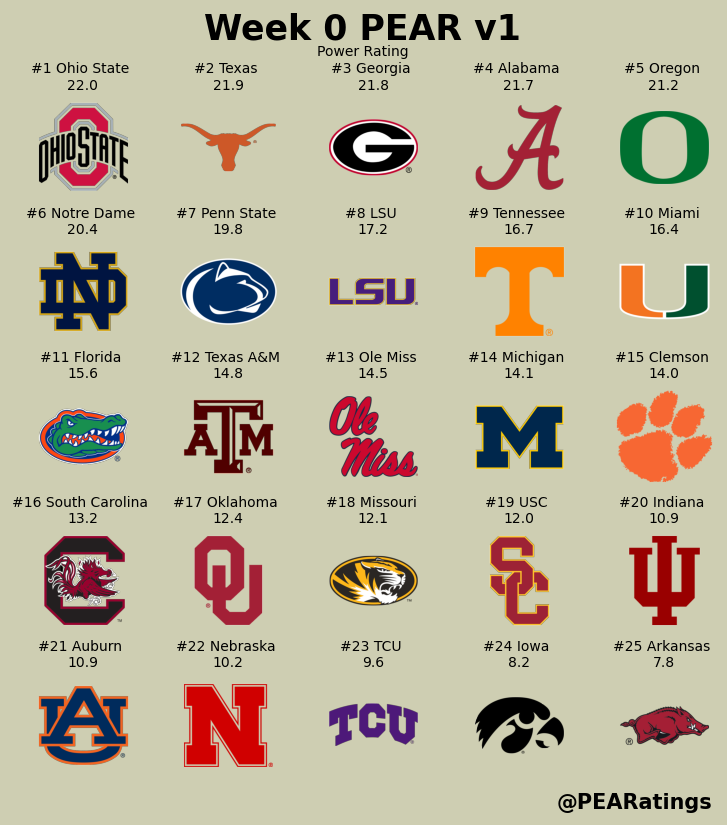

In [ ]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
top_25 = all_data[:25]
last_week_data = pd.read_csv(f"./PEAR/PEAR Football/y{current_year}/Ratings/PEAR_week{current_week-1}.csv")

fig, axs = plt.subplots(5, 5, figsize=(7, 7),dpi=125)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.patch.set_facecolor('#CECEB2')
plt.suptitle(f"Week {current_week} PEAR", fontsize=20, fontweight='bold', color='black')
fig.text(0.5, 0.93, "Power Rating (Position Change)", fontsize=8, ha='center', color='black')
fig.text(0.9, 0.07, "@PEARatings", fontsize=12, ha='right', color='black', fontweight='bold')

for i, ax in enumerate(axs.ravel()):
    team = top_25.loc[i, 'team']
    logo_url = logos[logos['team'] == team]['logo'].values[0][0]
    response = requests.get(logo_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.set_facecolor('#CECEB2')
    power_rating = top_25.loc[i, 'power_rating']
    last_week_index = last_week_data[last_week_data['team'] == team].index[0]
    #  ({round(power_rating-last_week_pr, 1)}) <- shows change from last week. Currently irrelevant
    ax.set_title(f"#{i+1} {team} \n{round(power_rating,1)} ({round(last_week_index - i, 1)})", fontsize=8)
    ax.axis('off')
plt.show()

### Group of 5 Top 25

In [ ]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

group_of_5 = ['Conference USA', 'Mid-American', 'Sun Belt', 'American Athletic', 'Mountain West']
filtered_data = all_data[all_data['conference'].isin(group_of_5)]
top_25 = filtered_data.head(25).reset_index(drop=True)

fig, axs = plt.subplots(5, 5, figsize=(7, 7),dpi=125)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.patch.set_facecolor('#CECEB2')
plt.suptitle(f"Week {current_week} GO5 PEAR", fontsize=20, fontweight='bold', color='black')
fig.text(0.9, 0.07, "@PEARatings", fontsize=12, ha='right', color='black', fontweight='bold')

for i, ax in enumerate(axs.ravel()):
    team = top_25.loc[i, 'team']
    logo_url = logos[logos['team'] == team]['logo'].values[0][0]
    response = requests.get(logo_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.set_facecolor('#CECEB2')
    ax.set_title(f"#{i+1} {team} \n{round(top_25.loc[i, 'power_rating'],1)}", fontsize=8)
    ax.axis('off')
# plt.savefig(f"./PEAR/Visuals/GO5 Top 25/go5_top25_week{current_week}", bbox_inches='tight',dpi=300)
plt.show()

### All Teams Graphed

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
# Define the number of rows and columns
n_teams = len(all_data)
n_columns = (n_teams // 20) + (1 if n_teams % 20 != 0 else 0)

# Plot configuration
fig, axes = plt.subplots(nrows=20, ncols=n_columns, figsize=(20, 10),dpi=125)
plt.subplots_adjust(hspace=0.5)
fig.patch.set_facecolor('#CECEB2')
plt.suptitle(f'Week {current_week} PEAR. 0.0 is the average FBS team.', fontsize=14, y=0.92, x=0.55)

min_rating = all_data['power_rating'].min()
max_rating = all_data['power_rating'].max()
rating_range = max_rating-min_rating


cmap = LinearSegmentedColormap.from_list('dark_gradient_orange', ['#660000', '#8B0000', '#CC5500', '#2C5E00', '#1D4D00'], N=rating_range)

def get_color(value, vmin=min_rating, vmax=max_rating):
    norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
    return cmap(norm_value)  # Get the color from the colormap

# Define a colormap from red to green
cmap = plt.get_cmap('RdYlGn')

def get_color(power_rating):
    """Return a color based on the power rating normalized to a range between 0 and 1."""
    norm_rating = (power_rating - min_rating) / (max_rating - min_rating)
    return cmap(norm_rating)

# Iterate through the data to plot
for idx, team in all_data.iterrows():
    power_rating = team['power_rating']
    team_name = team['team']
    logo_url = logos[logos['team'] == team_name]['logo'].values[0][0]
    row = idx % 20
    col = idx // 20
    
    ax = axes[row, col]
    ax.axis('off')  # Turn off the axis
    
    # Fetch the logo image from URL and display it
    response = requests.get(logo_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)

    # Get the color for the current power rating
    color = get_color(power_rating)

    text_ax = ax.inset_axes([0.2, 0.3, 0.75, 0.5])  # Move the text box to the right of the logo
    text_ax.axis('off')  # Turn off the text axis

    # Get the color for the current power rating
    color = get_color(power_rating)

    # Display the rank
    text_ax.text(-1.2, 0.5, f"#{idx + 1}", ha='center', va='center', fontsize=8, color='black', transform=text_ax.transAxes, fontweight='bold')

    # Display the team name to the right of the logo
    text_ax.text(1.5, 0.5, f"{team_name}", ha='left', va='center', fontsize=6, color='black', transform=text_ax.transAxes)

    # Display the power rating in a separate line with its color
    text_ax.text(6.5, 0.5, f"{power_rating:.2f}", ha='left', va='center', fontsize=8, color='black', transform=text_ax.transAxes, fontweight='bold')

    text_ax.text(9, 0.9, "|", ha='left', va='center', fontsize=14, color='black', transform=text_ax.transAxes, fontweight='bold')
    text_ax.text(9, -0.6, "|", ha='left', va='center', fontsize=14, color='black', transform=text_ax.transAxes, fontweight='bold')
    

if n_teams % 20 != 0:
    for empty_row in range(n_teams % 20, 20):
        axes[empty_row, n_columns - 1].axis('off')
# plt.savefig(f'./PEAR/Visuals/Visual PR/team_pr_week{current_week}', bbox_inches='tight', dpi=500)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Fill in missing colors with black
all_data['color'] = all_data['color'].fillna('#000000')

# Calculate the average power rating
average_power_rating = all_data['power_rating'].mean()

plt.figure(figsize=(20, 10),dpi=125)
plt.bar(all_data['team'], all_data['power_rating'], color=all_data['color'])
plt.title('Team Power Ratings', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Team', fontsize=12, color='black')
plt.ylabel('Power Rating', fontsize=12, color='black')
plt.gca().set_facecolor('#CECEB2')
plt.gcf().set_facecolor('#CECEB2')
plt.xticks(rotation=45, ha='right', fontsize=8, color='black')
plt.ylim(-25, 35)

# Add a horizontal line for the average power rating
plt.axhline(y=0, color='white', linestyle='--', linewidth=2, alpha=1)

# Add vertical lines every 25 teams
for i in range(25, len(all_data), 25):
    plt.axvline(x=i - 0.5, color='black', linestyle='--', linewidth=0.8, alpha=1)
plt.grid(False)

plt.tight_layout()
# plt.savefig(f'./PEAR/Visuals/Visual PR/bar_chart_pr_week{current_week}', bbox_inches='tight', dpi=300)
plt.show()

### Individual Conference Ratings

In [ ]:
import matplotlib.pyplot as plt 
import requests
from PIL import Image
from io import BytesIO
import math
import pandas as pd

# Set the current week
current_week = 6
conference_figures = []
# Loop through each unique conference and create a plot for all teams in that conference
unique_conferences = all_data['conference'].unique()

for conference in unique_conferences:
    # Filter all teams in the current conference
    conference_teams = all_data[all_data['conference'] == conference].reset_index(drop=True)
    num_teams = len(conference_teams)
    
    # Set up the figure with a fixed number of spaces (5 columns and 5 rows)
    cols = 5
    rows = 4  # Fixed number of rows to accommodate 25 spaces
    
    fig, axs = plt.subplots(rows, cols, figsize=(5, 5),dpi=125)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    fig.patch.set_facecolor('#CECEB2')  # Background color for the entire figure
    plt.suptitle(f"Week {current_week} PEAR - {conference}", fontsize=10, fontweight='bold', color='black')

    # Flatten the axes array
    axs = axs.ravel()

    # Plot each team's logo
    plot_index = 0  # Index for keeping track of where to plot
    for i in range(num_teams):
        
        ax = axs[plot_index]  # Get the next available axis for plotting
        
        # if conference_teams.loc[i, 'team'] == "Charlotte":
        #     # Set the background color from team_data['color']
        #     ax.set_facecolor(conference_teams.loc[i, 'color'] if pd.notna(conference_teams.loc[i, 'color']) else '#f0f0f0')
            
        #     # Set title as the team name with rank
        #     ax.set_title(f"#{plot_index + 1} {conference_teams.loc[i, 'team']}", fontsize=5, fontweight='bold')
        #     ax.axis('off')
            
        #     plot_index += 1  # Increment the plot index
        #     continue  # Skip "Charlotte"

        # Fetch team logo
        if conference_teams.loc[i, 'logo'] is not None:
            logo_url = logos[logos['team'] == conference_teams.loc[i, 'team']]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
        else:
            # Set the background color from team_data['color']
            ax.set_facecolor(conference_teams.loc[i, 'color'] if pd.notna(conference_teams.loc[i, 'color']) else '#f0f0f0')
        
            # Set title as the team name with rank
            ax.set_title(f"#{plot_index + 1} {conference_teams.loc[i, 'team']}", fontsize=5, fontweight='bold')
            ax.axis('off')
        
            plot_index += 1  # Increment the plot index
            ax.axis('off')  # Turn off axis if no logo available
            continue
        
        # Set the background color from team_data['color']
        ax.set_facecolor(conference_teams.loc[i, 'color'] if pd.notna(conference_teams.loc[i, 'color']) else '#f0f0f0')
        
        # Set title as the team name with rank
        ax.set_title(f"#{plot_index + 1} {conference_teams.loc[i, 'team']}", fontsize=5, fontweight='bold')
        ax.axis('off')
        
        plot_index += 1  # Increment the plot index

        # If we reach 25 spaces, we stop plotting
        if plot_index >= len(axs):
            break
    
    # Hide any remaining subplots that weren't used
    for j in range(plot_index, len(axs)):
        axs[j].axis('off')
    
    # Save the figure to the conference_figures list
    conference_figures.append(fig)

# Optional: Display all the figures at once (if needed)
for fig in conference_figures:
    plt.show(fig)

### Conference Average

In [ ]:
import matplotlib.pyplot as plt

conference_stats = all_data.groupby('conference')['power_rating'].agg(['mean', 'min', 'max']).reset_index()
conference_stats = conference_stats.sort_values(by='mean', ascending=False)

plt.figure(figsize=(8, 4), facecolor='#CECEB2',dpi=125)
bars = plt.bar(conference_stats['conference'], conference_stats['mean'], 
                color='#A74C54', 
                yerr=[conference_stats['mean'] - conference_stats['min'], 
                      conference_stats['max'] - conference_stats['mean']], 
                capsize=5)
ax = plt.gca()
ax.set_facecolor('#CECEB2')
for spine in ax.spines.values():
    spine.set_color('#CECEB2')  # Set the border color
    spine.set_linewidth(2)  # Adjust the border thickness if needed
ax.xaxis.set_tick_params(color='black')  # X-axis ticks
ax.yaxis.set_tick_params(color='black')  # Y-axis ticks
ax.spines['bottom'].set_color('black')  # Bottom spine
ax.spines['left'].set_color('black')  # Left spine
ax.spines['top'].set_color('none')  # Top spine
ax.spines['right'].set_color('none')  # Right spine

plt.axhline(y=0, color = 'black', linestyle='--')
plt.xlabel('Conference', fontsize=12, color='black')
plt.ylabel('Average Power Rating', fontsize=12, color='black')
plt.title('Average Power Rating by Conference', fontsize=14, fontweight='bold', color='black')
plt.xticks(rotation=45, ha='right', color='black', fontsize=8)
plt.yticks(color='black', fontsize=8)
plt.text(-1.8, 28.5, "@PEARatings", fontsize=12, color='black', fontweight='bold', ha='left')
plt.tight_layout()
# plt.savefig(f"./PEAR/Visuals/Average Conference Rating/average_power_conference_week{current_week}.png")
plt.show()

### All Conferences

In [ ]:
import matplotlib.pyplot as plt 
import requests
from PIL import Image
from io import BytesIO
import math
import pandas as pd
import matplotlib.pyplot as plt 
import requests
from PIL import Image
from io import BytesIO
import pandas as pd

# Loop through each unique conference and create a plot for all teams in that conference
unique_conferences = all_data['conference'].unique()
conference_figures = []  # List to store figures

for conference in unique_conferences:
    # Filter all teams in the current conference
    conference_teams = all_data[all_data['conference'] == conference].reset_index(drop=True)
    num_teams = len(conference_teams)
    
    # Set up the figure with a larger size and fewer rows/columns
    cols = 4  # Adjusted number of columns
    rows = math.ceil(num_teams / cols)  # Calculate rows based on number of teams

    # Increase figure size
    fig, axs = plt.subplots(rows, cols, figsize=(12, 10),dpi=125)  # Adjusted figure size
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjusted spacing
    fig.patch.set_facecolor('#CECEB2')  # Background color for the entire figure
    plt.suptitle(f"Week {current_week} PEAR - {conference}", fontsize=25, fontweight='bold', color='black')

    # Flatten the axes array
    axs = axs.ravel()

    # Plot each team's logo
    plot_index = 0  # Index for keeping track of where to plot
    for i in range(num_teams):
        
        ax = axs[plot_index]  # Get the next available axis for plotting
        
        # if conference_teams.loc[i, 'team'] == "Charlotte":
        #     # Set the background color from team_data['color']
        #     ax.set_facecolor(conference_teams.loc[i, 'color'] if pd.notna(conference_teams.loc[i, 'color']) else '#f0f0f0')
            
        #     # Set title as the team name with rank
        #     ax.set_title(f"#{plot_index + 1} {conference_teams.loc[i, 'team']}", fontsize=16, fontweight='bold')
        #     ax.axis('off')
            
        #     plot_index += 1  # Increment the plot index
        #     continue  # Skip "Charlotte"

        # Fetch team logo
        if conference_teams.loc[i, 'logo'] is not None:
            logo_url = logos[logos['team'] == conference_teams.loc[i, 'team']]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
        else:
            # Set the background color from team_data['color']
            ax.set_facecolor(conference_teams.loc[i, 'color'] if pd.notna(conference_teams.loc[i, 'color']) else '#f0f0f0')
        
            # Set title as the team name with rank
            ax.set_title(f"#{plot_index + 1} {conference_teams.loc[i, 'team']}", fontsize=16, fontweight='bold')
            ax.axis('off')
        
            plot_index += 1  # Increment the plot index
            ax.axis('off')  # Turn off axis if no logo available
            continue
        
        # Set the background color from team_data['color']
        ax.set_facecolor(conference_teams.loc[i, 'color'] if pd.notna(conference_teams.loc[i, 'color']) else '#f0f0f0')
        
        # Set title as the team name with rank
        ax.set_title(f"#{plot_index + 1} {conference_teams.loc[i, 'team']}", fontsize=16, fontweight='bold')
        ax.axis('off')
        
        plot_index += 1  # Increment the plot index

        # If we reach the maximum number of plots, we stop plotting
        if plot_index >= len(axs):
            break
    
    # Hide any remaining subplots that weren't used
    for j in range(plot_index, len(axs)):
        axs[j].axis('off')
    
    # Save the plot for this conference to the list
    conference_figures.append(fig)

import matplotlib.pyplot as plt
import os
from PIL import Image

# Create a list to hold the paths of saved images
image_paths = []

# Save each conference figure to a temporary image
for idx, conf_fig in enumerate(conference_figures):
    temp_image_path = f"temp_conference_fig_{idx}.png"
    conf_fig.savefig(temp_image_path, bbox_inches='tight', dpi=300)
    image_paths.append(temp_image_path)

# Determine the number of figures
num_figures = len(image_paths)

# Define the number of rows and columns for the new display figure
cols = 3  # Number of columns you want
rows = (num_figures + cols - 1) // cols  # Calculate number of rows needed

# Create a new figure for displaying all conference figures
display_fig, display_axs = plt.subplots(rows, cols, figsize=(10, 3 * rows))
display_fig.subplots_adjust(hspace=0.1, wspace=0.1)
display_fig.patch.set_facecolor('#CECEB2') 

# Flatten the axes array for easier indexing
display_axs = display_axs.ravel()

# Loop through each image path and display it in the display axes
for i in range(num_figures):
    ax = display_axs[i]  # Get the corresponding subplot axis
    img = Image.open(image_paths[i])  # Open the saved image
    ax.imshow(img)  # Display the image
    ax.axis('off')  # Turn off the axis

# Hide any remaining subplots that weren't used
for j in range(num_figures, len(display_axs)):
    display_axs[j].axis('off')

# Show the final display figure
# display_fig.savefig(f'./PEAR/Visuals/Conference Ratings/conference_ratings_week{current_week}.png', bbox_inches='tight', dpi=300)
plt.show(display_fig)

# Optional: Clean up the temporary images after displaying
for image_path in image_paths:
    os.remove(image_path)  # Delete the temporary image files


### Playoff Projection

In [ ]:
conference_list = ['SEC', 'Big Ten', 'Big 12', 'ACC', 'Pac-12', 'Conference USA', 'Mid-American', 'Sun Belt', 'American Athletic', 'Mountain West']
top_4_seeds = all_data[all_data['conference'].isin(conference_list)].groupby('conference').first().sort_values('power_rating', ascending=False).reset_index()[0:4]
autobid_5 = all_data[all_data['conference'].isin(conference_list)].groupby('conference').first().sort_values('power_rating', ascending=False).reset_index()[4:5]
excluded_teams = list(top_4_seeds['team']) + list(autobid_5['team'])
at_large_bids = all_data[~all_data['team'].isin(excluded_teams)].head(7).reset_index(drop=True)
at_large_bids = pd.concat([at_large_bids, autobid_5]).reset_index(drop=True)
# Creating a dictionary for at_large_bids starting from seed 5
at_large_dict = {i + 5: team for i, team in enumerate(at_large_bids['team'])}
power_5_dict = {i + 1: team for i, team in enumerate(top_4_seeds['team'])}
seeding = {**power_5_dict, **at_large_dict}
draw_playoff_bracket(seeding, "Projected Playoff Bracket")

### Best and Worst Visuals

In [ ]:
# Turnovers
best_and_worst(all_data, logos, 'total_turnovers_scaled', "Turnover Margin Percentiles", "Percentile Based: 100 is best, 1 is worst")

# Offenses
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['offensive_total'] = scaler100.fit_transform(all_data[['offensive_total']])
best_and_worst(all_data, logos, 'offensive_total', "PEAR Raw Offenses: Best and Worst 25", "Percentile Based: 100 is best, 1 is worst")

# Defenses
all_data['defensive_total'] = scaler100.fit_transform(all_data[['defensive_total']])
best_and_worst(all_data, logos, 'defensive_total', "PEAR Raw Defenses: Best and Worst 25", "100 is the best raw defense, 1 is the worst")

# Special Teams
all_data['STM_scaled'] = scaler100.fit_transform(all_data[['STM']])
best_and_worst(all_data, logos, 'STM_scaled', "PEAR Special Teams", "Percentile Based: 100 is best, 1 is worst")

# Penalty Burden Ratio
pbr_min = all_data['PBR'].min()
pbr_max = all_data['PBR'].max()
all_data['PBR_scaled'] = 100 - (all_data['PBR'] - pbr_min) * (99 / (pbr_max - pbr_min))
best_and_worst(all_data, logos, 'PBR_scaled', "PEAR Penalty Burden Ratio", "How Penalties Impact Success - 100 is best, 1 is worst")

# Drive Control Efficiency
all_data['DCE_scaled'] = scaler100.fit_transform(all_data[['DCE']])
best_and_worst(all_data, logos, 'DCE_scaled', "PEAR Drive Control Efficiency", "How Well You Control the Ball - 100 is best, 1 is worst")

# Drive Disruption Efficiency
all_data['DDE_scaled'] = scaler100.fit_transform(all_data[['DDE']])
best_and_worst(all_data, logos, 'DDE_scaled', "PEAR Drive Disruption Efficiency", "How Well You Disrupt the Offense - 100 is best, 1 is worst")

# Average Metric Rank
columns_to_average = ["offensive_rank", "defensive_rank", "STM_rank", "PBR_rank", "DCE_rank", "DDE_rank"]
all_data["average_metric_rank"] = round(all_data[columns_to_average].mean(axis=1),1)
best_and_worst(all_data, logos, 'average_metric_rank', "PEAR Average Metric Ranking", "Average OFF, DEF, ST, PBR, DCE, DDE Ranking - Lower is Better")

# Talent Production
all_data['most_deserving_scaled'] = scaler100.fit_transform(all_data[['most_deserving_wins']])
all_data['talent_performance'] = (all_data['most_deserving_scaled'] - all_data['avg_talent']) / math.sqrt(2)
best_and_worst(all_data, logos, 'talent_performance', "PEAR Talent Performance Gap", "Is Your Team Outperforming or Underperforming Its Roster?")

# Dependence Scores
all_data['defensive_total'] = scaler100.fit_transform(all_data[['defensive_total']])
all_data['offensive_total'] = scaler100.fit_transform(all_data[['offensive_total']])
all_data['dependence_score'] = (all_data['offensive_total'] - all_data['defensive_total']) / (all_data['offensive_total'] + all_data['defensive_total'])
best_and_worst(all_data, logos, 'dependence_score', 'PEAR Unit Dependence', 'Values near 1 indicate offensive dependence, while values near -1 indicate defensive dependence')

### Other Best and Worst Visuals

In [ ]:
# Most Deserving
other_best_and_worst(most_deserving, logos, 'wins_above_average', f'Week {current_week} Most Deserving', "Performance Against Schedule Relative to the No. 12 Power Rated Team")

# Strength of Schedule
other_best_and_worst(SOS, logos, 'avg_expected_wins', f'Week {current_week} PEAR SOS', "If An Elite Team Played Your Schedule, They Would Have __ Wins")

# Strength of Record
other_best_and_worst(SOR, logos, 'wins_above_good', f'Week {current_week} PEAR SOR', "Wins Above or Below a Good Team")

# Margin of Victory Performance
other_best_and_worst(RTP, logos, 'RTP', f'PEAR Margin of Victory', "If You Are Expected to Win by 10 Points, Your Average MOV is __ Points")

### Offense vs. Defense

In [ ]:
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['offensive_total'] = scaler100.fit_transform(all_data[['offensive_total']])
all_data['offensive_total'] = all_data['offensive_total'] - all_data['offensive_total'].mean()
all_data['defensive_total'] = scaler100.fit_transform(all_data[['defensive_total']])
all_data['defensive_total'] = all_data['defensive_total'] - all_data['defensive_total'].mean()

# Create the plot
fig, ax = plt.subplots(figsize=(15, 9),dpi=125)
plt.gca().set_facecolor('#CECEB2')
plt.gcf().set_facecolor('#CECEB2')
# Set the size of the logos (adjust the numbers to make logos smaller or larger)
logo_size = 2  # Half the size of the logo to create spacing

# Loop through the team_data DataFrame to plot logos
for i in range(len(all_data)):
    # Get the logo image from the URL
    logo_url = logos[logos['team'] == all_data.loc[i,'team']]['logo'].values[0][0]
    response = requests.get(logo_url)
    img = mpimg.imread(BytesIO(response.content), format='png')

    # Calculate the extent for the logo
    # Here we use logo_size for both sides to center the logo at the specific coordinates
    ax.imshow(img, aspect='auto', 
              extent=(all_data['defensive_total'].iloc[i] - (logo_size-0.5),
                      all_data['defensive_total'].iloc[i] + (logo_size-0.5),
                      all_data['offensive_total'].iloc[i] - logo_size,
                      all_data['offensive_total'].iloc[i] + logo_size))

# Set axis labels
ax.set_xlabel('Total Defense')
ax.set_ylabel('Total Offense')
ax.set_title('Team Offense vs Defense', fontweight='bold', fontsize=14)

# Show the plot
plt.xlim(all_data['defensive_total'].min() - 5, all_data['defensive_total'].max() + 5)  # Adjust x-axis limits for visibility
plt.ylim(all_data['offensive_total'].min() - 5, all_data['offensive_total'].max() + 5)  # Adjust y-axis limits for visibility
plt.grid(False)  # Turn off the grid
plt.axhline(0, linestyle='--', color='black', alpha = 0.3)
plt.axvline(0, linestyle='--', color='black', alpha = 0.3)
plt.text(45, 50, "Good Offense, Good Defense", fontsize=10, fontweight='bold', ha='center')
plt.text(-30, 50, "Good Offense, Bad Defense", fontsize=10, fontweight='bold', ha='center')
plt.text(45, -50, "Bad Offense, Good Defense", fontsize=10, fontweight='bold', ha='center')
plt.text(-30, -50, "Bad Offense, Bad Defense", fontsize=10, fontweight='bold', ha='center')
plt.figure(dpi=500)
plt.show()

### Drive Control Efficiency vs. Drive Disruption Efficiency

In [ ]:
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['DCE'] = scaler100.fit_transform(all_data[['DCE']])
all_data['DCE'] = all_data['DCE'] - all_data['DCE'].mean()
all_data['DDE'] = scaler100.fit_transform(all_data[['DDE']])
all_data['DDE'] = all_data['DDE'] - all_data['DDE'].mean()

# Create the plot
fig, ax = plt.subplots(figsize=(15, 9),dpi=125)
plt.gca().set_facecolor('#CECEB2')
plt.gcf().set_facecolor('#CECEB2')
# Set the size of the logos (adjust the numbers to make logos smaller or larger)
logo_size = 2  # Half the size of the logo to create spacing

# Loop through the team_data DataFrame to plot logos
for i in range(len(all_data)):
    # Get the logo image from the URL
    logo_url = logos[logos['team'] == all_data.loc[i,'team']]['logo'].values[0][0]
    response = requests.get(logo_url)
    img = mpimg.imread(BytesIO(response.content), format='png')

    # Calculate the extent for the logo
    # Here we use logo_size for both sides to center the logo at the specific coordinates
    ax.imshow(img, aspect='auto', 
              extent=(all_data['DDE'].iloc[i] - (logo_size-0.5),
                      all_data['DDE'].iloc[i] + (logo_size-0.5),
                      all_data['DCE'].iloc[i] - logo_size,
                      all_data['DCE'].iloc[i] + logo_size))

# Set axis labels
ax.set_xlabel('Drive Disruption Efficiency')
ax.set_ylabel('Drive Control Efficiency')
ax.set_title('DCE vs. DDE', fontweight='bold', fontsize=14)

# Show the plot
plt.xlim(all_data['DDE'].min() - 5, all_data['DDE'].max() + 5)  # Adjust x-axis limits for visibility
plt.ylim(all_data['DCE'].min() - 5, all_data['DCE'].max() + 5)  # Adjust y-axis limits for visibility
plt.grid(False)  # Turn off the grid
plt.axhline(0, linestyle='--', color='black', alpha = 0.3)
plt.axvline(0, linestyle='--', color='black', alpha = 0.3)
plt.text(45, 50, "Good DCE, Good DDE", fontsize=10, fontweight='bold', ha='center')
plt.text(-30, 50, "Good DCE, Bad DDE", fontsize=10, fontweight='bold', ha='center')
plt.text(45, -50, "Bad DCE, Good DDE", fontsize=10, fontweight='bold', ha='center')
plt.text(-30, -50, "Bad DCE, Bad DDE", fontsize=10, fontweight='bold', ha='center')
plt.figure(dpi=500)
plt.show()

### Ratings vs. Resume

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(15, 9),dpi=125)
plt.gca().set_facecolor('#CECEB2')
plt.gcf().set_facecolor('#CECEB2')
# Set the size of the logos (adjust the numbers to make logos smaller or larger)
logo_size = 0.9  # Half the size of the logo to create spacing
# Loop through the team_data DataFrame to plot logos
for i in range(len(all_data)):
    # Get the logo image from the URL
    logo_url = logos[logos['team'] == all_data.loc[i,'team']]['logo'].values[0][0]
    response = requests.get(logo_url)
    img = mpimg.imread(BytesIO(response.content), format='png')

    # Calculate the extent for the logo
    # Here we use logo_size for both sides to center the logo at the specific coordinates
    ax.imshow(img, aspect='auto', 
              extent=(all_data['most_deserving_wins'].iloc[i] - (logo_size-0.7),
                      all_data['most_deserving_wins'].iloc[i] + (logo_size-0.7),
                      all_data['power_rating'].iloc[i] - logo_size,
                      all_data['power_rating'].iloc[i] + logo_size))

# Set axis labels
ax.set_xlabel('Resume (Record Strength)', fontweight='bold')
ax.set_ylabel('Ratings (Team Strength)', fontweight='bold')
ax.set_title('Resume vs. Ratings', fontweight='bold', fontsize=14)

# Show the plot
plt.xlim(all_data['most_deserving_wins'].min() - 1, all_data['most_deserving_wins'].max() + 1)  # Adjust x-axis limits for visibility
plt.ylim(all_data['power_rating'].min() - 3, all_data['power_rating'].max() + 3)  # Adjust y-axis limits for visibility
plt.grid(False)  # Turn off the grid

elite_team_pr = all_data['power_rating'].mean() + (2*all_data['power_rating'].std())
elite_team_resume = all_data['most_deserving_wins'].mean() + (2*all_data['most_deserving_wins'].std())
good_team_pr = all_data['power_rating'].mean() + (1*all_data['power_rating'].std())
good_team_resume = all_data['most_deserving_wins'].mean() + (1*all_data['most_deserving_wins'].std())
avg_team_pr = all_data['power_rating'].mean() + (0*all_data['power_rating'].std())
avg_team_resume = all_data['most_deserving_wins'].mean() + (0*all_data['most_deserving_wins'].std())
below_avg_team_pr = all_data['power_rating'].mean() + (-1*all_data['power_rating'].std())
below_avg_team_resume = all_data['most_deserving_wins'].mean() + (-1*all_data['most_deserving_wins'].std())


# Get the data ranges for normalization
x_min, x_max = all_data['most_deserving_wins'].min()-1, all_data['most_deserving_wins'].max()+1
y_min, y_max = all_data['power_rating'].min()-3, all_data['power_rating'].max()+3
plt.plot([elite_team_resume, x_max], [elite_team_pr, elite_team_pr], linestyle='--', color='darkgreen', alpha=0.6)  # Horizontal line
plt.plot([elite_team_resume, elite_team_resume], [elite_team_pr, y_max], linestyle='--', color='darkgreen', alpha=0.6)  # Vertical line
plt.plot([good_team_resume, x_max], [good_team_pr, good_team_pr], linestyle='--', color='yellow', alpha=0.6)  # Horizontal line
plt.plot([good_team_resume, good_team_resume], [good_team_pr, y_max], linestyle='--', color='yellow', alpha=0.6)  # Vertical line
# plt.plot([avg_team_resume, x_max], [avg_team_pr, avg_team_pr], linestyle='--', color='black', alpha=0.6)  # Horizontal line
# plt.plot([avg_team_resume, avg_team_resume], [avg_team_pr, y_max], linestyle='--', color='black', alpha=0.6)  # Vertical line
# plt.plot([below_avg_team_resume, x_max], [below_avg_team_pr, below_avg_team_pr], linestyle='--', color='red', alpha=0.6)  # Horizontal line
# plt.plot([below_avg_team_resume, below_avg_team_resume], [below_avg_team_pr, y_max], linestyle='--', color='red', alpha=0.6)  # Vertical line
plt.figure(dpi=500)
plt.tight_layout()
plt.show()

### Talent vs. Production

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9),dpi=125)
plt.gca().set_facecolor('#CECEB2')
plt.gcf().set_facecolor('#CECEB2')
# Set the size of the logos (adjust the numbers to make logos smaller or larger)
logo_size = 2  # Half the size of the logo to create spacing
# Loop through the team_data DataFrame to plot logos
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['most_deserving_scaled'] = scaler100.fit_transform(all_data[['most_deserving_wins']])
for i in range(len(all_data)):
    # Get the logo image from the URL
    logo_url = logos[logos['team'] == all_data.loc[i,'team']]['logo'].values[0][0]
    response = requests.get(logo_url)
    img = mpimg.imread(BytesIO(response.content), format='png')

    # Calculate the extent for the logo
    # Here we use logo_size for both sides to center the logo at the specific coordinates
    ax.imshow(img, aspect='auto', 
              extent=(all_data['avg_talent'].iloc[i] - (logo_size-0.5),
                      all_data['avg_talent'].iloc[i] + (logo_size-0.5),
                      all_data['most_deserving_scaled'].iloc[i] - logo_size,
                      all_data['most_deserving_scaled'].iloc[i] + logo_size))

ax.plot(
    [all_data['avg_talent'].min()-3, all_data['avg_talent'].max()+3],
    [all_data['avg_talent'].min()-3, all_data['avg_talent'].max()+3],
    color='black', linestyle='--'
)

# Set axis labels
ax.set_xlabel('Talent Percentile', fontweight='bold')
ax.set_ylabel('Resume Percentile', fontweight='bold')
ax.set_title('Production vs. Talent', fontweight='bold', fontsize=14)

# Show the plot
plt.xlim(all_data['avg_talent'].min() - 3, all_data['avg_talent'].max() + 3)  # Adjust x-axis limits for visibility
plt.ylim(all_data['most_deserving_scaled'].min() - 3, all_data['most_deserving_scaled'].max() + 3)  # Adjust y-axis limits for visibility
plt.grid(False)  # Turn off the grid

plt.text(1, 98, "Production Outperforming Talent", fontsize=10, fontweight='bold', ha='left')
plt.text(100, 2, "Production Underperforming Talent", fontsize=10, fontweight='bold', ha='right')

plt.figure(dpi=500)
plt.tight_layout()
plt.show()

### All Game Previews for Week

In [ ]:
if postseason:
    games = []
    response = games_api.get_games(year=current_year, division = 'fbs', season_type='postseason')
    games = [*games, *response]
else:
    games = []
    response = games_api.get_games(year=current_year, week = current_week, division = 'fbs')
    games = [*games, *response]

games = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_conference=g.home_conference,
            home_points=g.home_points,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_conference=g.away_conference,
            away_points=g.away_points,
            away_elo=g.away_pregame_elo,
            neutral = g.neutral_site
            ) for g in games if g.home_pregame_elo is not None and g.away_pregame_elo is not None]
games.sort(key=date_sort)
week_games = pd.DataFrame(games)

for i, game in week_games.iterrows():
    away_team = game['away_team'].strip()
    home_team = game['home_team'].strip()
    neutral = game['neutral']
    plot_matchup(win_thresholds_in_season, all_conference_wins, 
                        logos, team_data, last_week_data, last_month_data, 
                        start_season_data, all_data, year_long_schedule, records, SOS, SOR, most_deserving, home_team, away_team, neutral)

### All Most Deserving Teams

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
# Define the number of rows and columns
n_teams = len(team_data)
n_columns = (n_teams // 20) + (1 if n_teams % 20 != 0 else 0)

# Plot configuration
fig, axes = plt.subplots(nrows=20, ncols=n_columns, figsize=(20, 10),dpi=125)
plt.subplots_adjust(hspace=0.5)
fig.patch.set_facecolor('#CECEB2')
plt.suptitle(f'Week {current_week} PEAR Most Deserving Ratings.', fontsize=14, y=0.92, x=0.55)

min_rating = most_deserving['wins_above_average'].min()
max_rating = most_deserving['wins_above_average'].max()
rating_range = max_rating-min_rating


cmap = LinearSegmentedColormap.from_list('dark_gradient_orange', ['#660000', '#8B0000', '#CC5500', '#2C5E00', '#1D4D00'], N=rating_range)

def get_color(value, vmin=min_rating, vmax=max_rating):
    norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
    return cmap(norm_value)  # Get the color from the colormap

# Define a colormap from red to green
cmap = plt.get_cmap('RdYlGn')

def get_color(power_rating):
    """Return a color based on the power rating normalized to a range between 0 and 1."""
    norm_rating = (power_rating - min_rating) / (max_rating - min_rating)
    return cmap(norm_rating)

# Iterate through the data to plot
for idx, team in most_deserving.iterrows():
    power_rating = team['wins_above_average']
    team_name = team['team']
    logo_url = logos[logos['team'] == team_name]['logo'].values[0][0]
    row = idx % 20
    col = idx // 20
    
    ax = axes[row, col]
    ax.axis('off')  # Turn off the axis
    
    # Fetch the logo image from URL and display it
    response = requests.get(logo_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)

    # Get the color for the current power rating
    color = get_color(power_rating)

    text_ax = ax.inset_axes([0.2, 0.3, 0.75, 0.5])  # Move the text box to the right of the logo
    text_ax.axis('off')  # Turn off the text axis

    # Get the color for the current power rating
    color = get_color(power_rating)

    # Display the rank
    text_ax.text(-1.2, 0.5, f"#{idx + 1}", ha='center', va='center', fontsize=8, color='black', transform=text_ax.transAxes, fontweight='bold')

    # Display the team name to the right of the logo
    text_ax.text(1.5, 0.5, f"{team_name}", ha='left', va='center', fontsize=6, color='black', transform=text_ax.transAxes)

    # Display the power rating in a separate line with its color
    text_ax.text(6.5, 0.5, f"{power_rating:.2f}", ha='left', va='center', fontsize=8, color='black', transform=text_ax.transAxes, fontweight='bold')

    text_ax.text(9, 0.9, "|", ha='left', va='center', fontsize=14, color='black', transform=text_ax.transAxes, fontweight='bold')
    text_ax.text(9, -0.6, "|", ha='left', va='center', fontsize=14, color='black', transform=text_ax.transAxes, fontweight='bold')
    

if n_teams % 20 != 0:
    for empty_row in range(n_teams % 20, 20):
        axes[empty_row, n_columns - 1].axis('off')

### Most Deserving Playoff

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

most_deserving_playoff = most_deserving.merge(team_data[['team', 'conference']], on='team', how='left')
# most_deserving_playoff = most_deserving_playoff[~(most_deserving_playoff['team'] == 'BYU')][0:25]
# most_deserving_playoff = most_deserving_playoff[~(most_deserving_playoff['team'] == 'Army')][0:25]
conference_list = ['SEC', 'Big Ten', 'Big 12', 'ACC', 'Conference USA', 'Mid-American', 'Sun Belt', 'American Athletic', 'Mountain West']


# top_4_seeds = most_deserving_playoff[most_deserving_playoff['conference'].isin(conference_list)].groupby('conference').first().sort_values('wins_above_average', ascending=False).reset_index()[0:4]
# autobid_5 = most_deserving_playoff[most_deserving_playoff['conference'].isin(conference_list)].groupby('conference').first().sort_values('wins_above_average', ascending=False).reset_index()[4:5]


conference_champs = ['Oregon', 'Georgia', 'Boise State', 'Arizona State', 'Clemson', 'Army']
top_4_seeds = most_deserving_playoff[most_deserving_playoff['team'].isin(conference_champs)].sort_values('wins_above_average', ascending=False).reset_index()[0:4]
autobid_5 = most_deserving_playoff[most_deserving_playoff['team'].isin(conference_champs)].sort_values('wins_above_average', ascending=False).reset_index()[4:5]

excluded_teams = list(top_4_seeds['team']) + list(autobid_5['team'])
at_large_bids = most_deserving_playoff[~most_deserving_playoff['team'].isin(excluded_teams)].head(7).reset_index(drop=True)
at_large_bids = pd.concat([at_large_bids, autobid_5]).reset_index(drop=True)
first_four_out = most_deserving_playoff[~most_deserving_playoff['team'].isin(excluded_teams)].head(11).reset_index(drop=True)[7:]
next_four_out = most_deserving_playoff[~most_deserving_playoff['team'].isin(excluded_teams)].head(15).reset_index(drop=True)[11:]
# Creating a dictionary for at_large_bids starting from seed 5
at_large_dict = {i + 5: team for i, team in enumerate(at_large_bids['team'])}
power_5_dict = {i + 1: team for i, team in enumerate(top_4_seeds['team'])}
seeding = {**power_5_dict, **at_large_dict}
draw_playoff_bracket(seeding, "Most Deserving Playoff Bracket")

### Power Rating Team Pyramid

In [ ]:
average_pr = round(team_data['power_rating'].mean(), 2)
good_team_pr = round(team_data['power_rating'].std() + team_data['power_rating'].mean(), 2)
elite_team_pr = round(2 * team_data['power_rating'].std() + team_data['power_rating'].mean(), 2)
super_team_pr = round(3 * team_data['power_rating'].std() + team_data['power_rating'].mean(), 2)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

# Merge team_data with logos to include the logo column
team_data_logo = team_data.merge(logos, on='team', how='left')

# Categorize teams
super_teams = team_data_logo[team_data_logo['power_rating'] > super_team_pr].reset_index(drop=True)
elite_teams = team_data_logo[team_data_logo['power_rating'] > elite_team_pr].reset_index(drop=True)
good_teams = team_data_logo[
    (team_data_logo['power_rating'] > good_team_pr) & (team_data_logo['power_rating'] <= elite_team_pr)
].reset_index(drop=True)
average_teams = team_data_logo[
    (team_data_logo['power_rating'] > average_pr) & (team_data_logo['power_rating'] <= good_team_pr)
].reset_index(drop=True)
below_average_teams = team_data_logo[team_data_logo['power_rating'] <= average_pr].reset_index(drop=True)

# Plotting
fig, ax = plt.subplots(figsize=(11, 15))
fig.patch.set_facecolor('#CECEB2')

# Plot logos with adjusted spacing
plot_team_logos(ax, elite_teams, -0.2, spacing_factor=1, row_spacing = 0.4, max_teams_per_row=max(len(elite_teams) // 2, 1)+1)
plot_team_logos(ax, good_teams, 0.7, spacing_factor=1, row_spacing = 0.4, max_teams_per_row=max(len(good_teams) // 3, 1)+1)
plot_team_logos(ax, average_teams, 2, spacing_factor=1, row_spacing = 0.5, max_teams_per_row=max(len(average_teams) // 4, 1)+1)
plot_team_logos(ax, below_average_teams, 4.1, spacing_factor=1, row_spacing = 0.5, max_teams_per_row=max(len(below_average_teams) // 4, 1)+1)

ax.hlines(y=-0.5, xmin=-2.5, xmax=2.5, colors='black', linewidth=3)
ax.hlines(y=-1.75, xmin=-6.5, xmax=6.5, colors='black', linewidth=3)
ax.hlines(y=-3.8, xmin=-9, xmax=9, colors='black', linewidth=3)
ax.hlines(y=-5.9, xmin=-9, xmax=9, colors='black', linewidth=3)

ax.text(-2.5, -0.45, "Elite Teams", ha='left', fontsize=14, fontweight='bold', color='black')
ax.text(-6.5, -1.7, "Good Teams", ha='left', fontsize=14, fontweight='bold', color='black')
ax.text(-9, -3.75, "Average Teams", ha='left', fontsize=14, fontweight='bold', color='black')
ax.text(-9, -5.85, "Below Average Teams", ha='left', fontsize=14, fontweight='bold', color='black')
# ax.text(0, -6.3, "Below Average Teams", ha='center', fontsize=12, fontweight='bold', color='black')

# Adjust plot limits and formatting
ax.set_xlim(-9.5, 9.5)  # Center based on the widest row
ax.set_ylim(-5.5, 1)  # Extend y-axis to fit all levels
ax.set_yticks([-0.75, -2.25, -4, -6])
ax.set_yticklabels(["Elite Teams", "Good Teams", "Average Teams", "Below Average Teams"])
ax.text(0, 0.67, "Team Pyramid", ha='center', fontsize=24, fontweight='bold')
ax.text(0, 0.5, "Teams Listed in Descending Order Within Each Row", fontsize = 16, ha='center')
ax.axis("off")  # Remove axis lines

plt.tight_layout()
plt.show()

### Most Deserving Team Pyramid

In [ ]:
average_pr = round(most_deserving['wins_above_average'].mean(), 2)
good_team_pr = round(most_deserving['wins_above_average'].std() + most_deserving['wins_above_average'].mean(), 2)
elite_team_pr = round(2 * most_deserving['wins_above_average'].std() + most_deserving['wins_above_average'].mean(), 2)

# Merge team_data with logos to include the logo column
team_data_logo = most_deserving.merge(logos, on='team', how='left')

# Categorize teams
elite_teams = team_data_logo[team_data_logo['wins_above_average'] > elite_team_pr].reset_index(drop=True)
good_teams = team_data_logo[
    (team_data_logo['wins_above_average'] > good_team_pr) & (team_data_logo['wins_above_average'] <= elite_team_pr)
].reset_index(drop=True)
average_teams = team_data_logo[
    (team_data_logo['wins_above_average'] > average_pr) & (team_data_logo['wins_above_average'] <= good_team_pr)
].reset_index(drop=True)
below_average_teams = team_data_logo[team_data_logo['wins_above_average'] <= average_pr].reset_index(drop=True)

# Plotting
fig, ax = plt.subplots(figsize=(11, 15))
fig.patch.set_facecolor('#CECEB2')

# Plot logos with adjusted spacing
plot_team_logos(ax, elite_teams, -0.2, spacing_factor=1, row_spacing = 0.4, max_teams_per_row=max(len(elite_teams) // 2, 1))
plot_team_logos(ax, good_teams, 0.7, spacing_factor=1, row_spacing = 0.4, max_teams_per_row=max(len(good_teams) // 3, 1))
plot_team_logos(ax, average_teams, 2, spacing_factor=1, row_spacing = 0.5, max_teams_per_row=max(len(average_teams) // 4, 1)+1)
plot_team_logos(ax, below_average_teams, 4.1, spacing_factor=1, row_spacing = 0.5, max_teams_per_row=max(len(below_average_teams) // 4, 1)+1)

ax.hlines(y=-0.5, xmin=-2.5, xmax=2.5, colors='black', linewidth=3)
ax.hlines(y=-1.75, xmin=-6.5, xmax=6.5, colors='black', linewidth=3)
ax.hlines(y=-3.8, xmin=-9, xmax=9, colors='black', linewidth=3)
ax.hlines(y=-5.9, xmin=-9, xmax=9, colors='black', linewidth=3)

ax.text(-2.5, -0.45, "2+ SD", ha='left', fontsize=14, fontweight='bold', color='black')
ax.text(-6.5, -1.7, "1+ SD", ha='left', fontsize=14, fontweight='bold', color='black')
ax.text(-9, -3.75, "0+ SD", ha='left', fontsize=14, fontweight='bold', color='black')
ax.text(-9, -5.85, "<0 SD", ha='left', fontsize=14, fontweight='bold', color='black')
# ax.text(0, -6.3, "Below Average Teams", ha='center', fontsize=12, fontweight='bold', color='black')

# Adjust plot limits and formatting
ax.set_xlim(-9.5, 9.5)  # Center based on the widest row
ax.set_ylim(-5.5, 1)  # Extend y-axis to fit all levels
ax.set_yticks([-0.75, -2.25, -4, -6])
ax.set_yticklabels(["Elite Teams", "Good Teams", "Average Teams", "Below Average Teams"])
ax.text(0, 0.67, "Most Deserving Team Pyramid", ha='center', fontsize=24, fontweight='bold')
ax.text(0, 0.5, "Teams Listed in Descending Order Within Each Row", fontsize = 16, ha='center')
ax.axis("off")  # Remove axis lines

plt.tight_layout()
plt.show()

### Playoffs Simulation

#### Probability to Advance

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.offsetbox as offsetbox
from urllib.request import urlopen
from PIL import Image as PILImage

seeding = {1: 'Oregon',
 2: 'Georgia',
 3: 'Boise State',
 4: 'Arizona State',
 5: 'Texas',
 6: 'Penn State',
 7: 'Notre Dame',
 8: 'Ohio State',
 9: 'Tennessee',
 10: 'Indiana',
 11: 'SMU',
 12: 'Clemson'}

# Parameters
n_simulations = 10000  # Number of simulations

first_round_games = [
    (seeding[8], seeding[9]),
    (seeding[7], seeding[10]),
    (seeding[6], seeding[11]),
    (seeding[5], seeding[12]),
]

advancement_counts = {seeding[seed]: 0 for seed in range(5, 13)}
for _ in range(n_simulations):
    for game in first_round_games:
        t1, t2 = game
        pr_t1 = team_data[team_data['team'] == t1]['power_rating'].values[0] + 1
        pr_t2 = team_data[team_data['team'] == t2]['power_rating'].values[0]
        prob_t1_wins = PEAR_Win_Prob(pr_t1, pr_t2)
        # Simulate the game outcome
        winner = t1 if 100 * np.random.rand() < prob_t1_wins else t2
        advancement_counts[winner] += 1
advance_to_quarters = {team: count / n_simulations for team, count in advancement_counts.items()}

quarterfinal_games = [
    (seeding[1], seeding[8], seeding[9]),
    (seeding[2], seeding[7], seeding[10]),
    (seeding[3], seeding[6], seeding[11]),
    (seeding[4], seeding[5], seeding[12]),
]

second_advancement_counts = {seeding[seed]: 0 for seed in range(1,13)}
for _ in range(n_simulations):
    for game in quarterfinal_games:
        t1, t2, t3 = game
        t2_advancement_prob = advance_to_quarters[t2]
        opponent = t2 if np.random.rand() < t2_advancement_prob else t3
        pr_t1 = team_data[team_data['team'] == t1]['power_rating'].values[0]
        pr_t2 = team_data[team_data['team'] == opponent]['power_rating'].values[0]
        prob_t1_wins = PEAR_Win_Prob(pr_t1, pr_t2)
        winner = t1 if 100 * np.random.rand() < prob_t1_wins else opponent
        second_advancement_counts[winner] += 1
advance_to_semis = {team: count / n_simulations for team, count in second_advancement_counts.items()}

semifinal_games = [
    (seeding[1], seeding[8], seeding[9], seeding[4], seeding[5], seeding[12]),
    (seeding[2], seeding[7], seeding[10], seeding[3], seeding[6], seeding[11]),
]

third_advancement_counts = {seeding[seed]: 0 for seed in range(1,13)}
for _ in range(n_simulations):
    for game in semifinal_games:
        t1,t2,t3,t4,t5,t6 = game
        t1_advance_prob = advance_to_semis[t1]
        t2_advance_prob = advance_to_semis[t2]
        t3_advance_prob = (t1_advance_prob + t2_advance_prob)
        t4_advance_prob = advance_to_semis[t4]
        t5_advance_prob = advance_to_semis[t5]
        t6_advance_prob = (t4_advance_prob + t5_advance_prob)
        random_val = np.random.rand()
        other_val = np.random.rand()
        if random_val < t1_advance_prob:
            team_one = t1
        elif random_val > t3_advance_prob:
            team_one = t3
        else:
            team_one = t2
        if other_val < t4_advance_prob:
            team_two = t4
        elif other_val > t6_advance_prob:
            team_two = t6
        else:
            team_two = t5
        pr_t1 = team_data[team_data['team'] == team_one]['power_rating'].values[0]
        pr_t2 = team_data[team_data['team'] == team_two]['power_rating'].values[0]
        prob_t1_wins = PEAR_Win_Prob(pr_t1, pr_t2)
        winner = team_one if 100 * np.random.rand() < prob_t1_wins else team_two
        third_advancement_counts[winner] += 1
advance_to_finals = {team: count / n_simulations for team, count in third_advancement_counts.items()}
        
championship_game = [
    (seeding[1], seeding[8], seeding[9], seeding[4], seeding[5], seeding[12], seeding[2], seeding[7], seeding[10], seeding[3], seeding[6], seeding[11]),
]

fourth_advancement_counts = {seeding[seed]: 0 for seed in range(1,13)}
for _ in range(n_simulations):
    for game in championship_game:
        t1,t2,t3,t4,t5,t6, t7,t8,t9,t10,t11,t12 = game
        t1_advance_prob = advance_to_finals[t1]
        t2_advance_prob = t1_advance_prob + advance_to_finals[t2]
        t3_advance_prob = t2_advance_prob + advance_to_finals[t3]
        t4_advance_prob = t3_advance_prob + advance_to_finals[t4]
        t5_advance_prob = t4_advance_prob + advance_to_finals[t5]

        t6_advance_prob = advance_to_finals[t6]
        t7_advance_prob = t6_advance_prob + advance_to_finals[t7]
        t8_advance_prob = t7_advance_prob + advance_to_finals[t8]
        t9_advance_prob = t8_advance_prob + advance_to_finals[t9]
        t10_advance_prob = t9_advance_prob + advance_to_finals[t10]
        t11_advance_prob = t10_advance_prob + advance_to_finals[t11]

        rand_val = np.random.rand()
        other_val = np.random.rand()

        if rand_val < t1_advance_prob:
            team_one = t1
        elif rand_val < t2_advance_prob:
            team_one = t2
        elif rand_val < t3_advance_prob:
            team_one = t3
        elif rand_val < t4_advance_prob:
            team_one = t4
        elif rand_val < t5_advance_prob:
            team_one = t5
        else:
            team_one = t6

        if other_val < t6_advance_prob:
            team_two = t6
        elif other_val < t7_advance_prob:
            team_two = t7
        elif other_val < t8_advance_prob:
            team_two = t8
        elif other_val < t9_advance_prob:
            team_two = t9
        elif other_val < t10_advance_prob:
            team_two = t10
        elif other_val < t11_advance_prob:
            team_two = t11
        else:
            team_two = t12
                
        pr_t1 = team_data[team_data['team'] == team_one]['power_rating'].values[0]
        pr_t2 = team_data[team_data['team'] == team_two]['power_rating'].values[0]
        prob_t1_wins = PEAR_Win_Prob(pr_t1, pr_t2)
        winner = team_one if 100 * np.random.rand() < prob_t1_wins else team_two
        fourth_advancement_counts[winner] += 1
win_championship = {team: count / n_simulations for team, count in fourth_advancement_counts.items()}

all_teams = set(advance_to_quarters.keys()) | set(advance_to_semis.keys()) | set(advance_to_finals.keys()) | set(win_championship.keys())
final_results_df = pd.DataFrame([
    {
        "Seed": next((seed for seed, name in seeding.items() if name == team), None),  # Get the seeding for the team
        "Team": team,
        "Quarterfinals": round(advance_to_quarters.get(team, 1) * 100),
        "Semifinals": round(advance_to_semis.get(team, 0) * 100),
        "NC Game": round(advance_to_finals.get(team, 0) * 100),
        "Win NC": round(win_championship.get(team, 0) * 100),
    }
    for team in sorted(all_teams)  # Sort teams alphabetically for consistency
])
final_results_df = final_results_df.sort_values('Seed')

def normalize(val, min_val, max_val):
    return (val - min_val) / (max_val - min_val)

min_value = final_results_df.iloc[:, 2:].min().min()
max_value = final_results_df.iloc[:, 2:].max().max()
fig, ax = plt.subplots(figsize=(8, 6),dpi=125)
fig.patch.set_facecolor('#CECEB2')

ax.axis('tight')
ax.axis('off')

# Add the table
table = ax.table(
    cellText=final_results_df.values,
    colLabels=final_results_df.columns,
    cellLoc='center',
    loc='center',
    colColours=['#CECEB2'] * len(final_results_df.columns)  # Set the header background color
)

table.auto_set_font_size(False)
table.set_fontsize(14)  # Bigger font size
table.auto_set_column_width(col=list(range(len(final_results_df.columns))))
cmap = LinearSegmentedColormap.from_list('custom_green', [(0, '#d5f5e3'), (1, '#006400')])  # Lighter green to dark green
# Add the gradient to the cells based on the value
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1.2)

    # Set header row background color
    if i == 0:
        cell.set_facecolor('#CECEB2')  # Set header row to #CECEB2
        cell.set_text_props(fontsize=14, color='black')  # White text in header
    # Set 'Team' and 'Seeding' columns to #CECEB2
    elif j == 0 or j == 1:  # Team column (index 0) and Seeding column (index 1)
        cell.set_facecolor('#CECEB2')  # Set background color for "Team" and "Seeding" columns
        cell.set_text_props(fontsize=14, weight='bold', color='black')  # White text for these columns
    else:
        # Normalize the value for gradient color
        value = final_results_df.iloc[i-1, j]  # Get the cell value (skip header)
        
        # If the value is 0, replace it with "<1"
        if value == 0:
            display_value = "<1%"
        else:
            display_value = f"{value:}%"


        normalized_value = normalize(value, min_value, max_value)
        color = cmap(normalized_value)  # Get the color from colormap

        # Set the cell background color
        cell.set_facecolor(color)
        cell.set_text_props(fontsize=14, fontweight='bold', color='black')  # Increase text size
        cell.get_text().set_text(display_value)
    

    cell.set_height(0.1)  # Adjust this value for vertical spacing

fig.suptitle('Probability To Advance To Each Round', fontsize=18, weight='bold', color='black', y=1.05)
plt.show()

#### Probability to Advance from Semis In

In [ ]:
seeding = {1: 'Ohio State',
 2: 'Notre Dame',
 3: 'Penn State',
 4: 'Texas'}

# Parameters
n_simulations = 10000  # Number of simulations

first_round_games = [
    (seeding[1], seeding[4]),
    (seeding[2], seeding[3])
]

advancement_counts = {seeding[seed]: 0 for seed in range(1, 5)}
for _ in range(n_simulations):
    for game in first_round_games:
        t1, t2 = game
        pr_t1 = team_data[team_data['team'] == t1]['power_rating'].values[0] + 1
        pr_t2 = team_data[team_data['team'] == t2]['power_rating'].values[0]
        prob_t1_wins = PEAR_Win_Prob(pr_t1, pr_t2)
        # Simulate the game outcome
        winner = t1 if 100 * np.random.rand() < prob_t1_wins else t2
        advancement_counts[winner] += 1
advance_to_championship = {team: count / n_simulations for team, count in advancement_counts.items()}

final_games = [
    (seeding[1], seeding[2], seeding[3], seeding[4])
]

second_advancement_counts = {seeding[seed]: 0 for seed in range(1,5)}
for _ in range(n_simulations):
    for game in final_games:
        t1, t2, t3, t4 = game

        t1_advancement_prob = advance_to_championship[t1]
        team1 = t1 if np.random.rand() < t1_advancement_prob else t4
        t2_advancement_prob = advance_to_championship[t2]
        team2 = t2 if np.random.rand() < t2_advancement_prob else t3
        pr_t1 = team_data[team_data['team'] == team1]['power_rating'].values[0]
        pr_t2 = team_data[team_data['team'] == team2]['power_rating'].values[0]
        prob_t1_wins = PEAR_Win_Prob(pr_t1, pr_t2)
        winner = team1 if 100 * np.random.rand() < prob_t1_wins else team2
        second_advancement_counts[winner] += 1
win_nc = {team: count / n_simulations for team, count in second_advancement_counts.items()}

all_teams = set(advance_to_championship.keys()) | set(win_nc.keys())
final_results_df = pd.DataFrame([
    {
        "Seed": next((seed for seed, name in seeding.items() if name == team), None),  # Get the seeding for the team
        "Team": team,
        "NC Game": round(advance_to_championship.get(team, 0) * 100),
        "Win NC": round(win_nc.get(team, 0) * 100),
    }
    for team in sorted(all_teams)  # Sort teams alphabetically for consistency
])
final_results_df = final_results_df.sort_values('Seed')

def normalize(val, min_val, max_val):
    return (val - min_val) / (max_val - min_val)

min_value = final_results_df.iloc[:, 2:].min().min()
max_value = final_results_df.iloc[:, 2:].max().max()
fig, ax = plt.subplots(figsize=(8, 6),dpi=125)
fig.patch.set_facecolor('#CECEB2')

ax.axis('tight')
ax.axis('off')

# Add the table
table = ax.table(
    cellText=final_results_df.values,
    colLabels=final_results_df.columns,
    cellLoc='center',
    loc='center',
    colColours=['#CECEB2'] * len(final_results_df.columns)  # Set the header background color
)

table.auto_set_font_size(False)
table.set_fontsize(14)  # Bigger font size
table.auto_set_column_width(col=list(range(len(final_results_df.columns))))
cmap = LinearSegmentedColormap.from_list('custom_green', [(0, '#d5f5e3'), (1, '#006400')])  # Lighter green to dark green
# Add the gradient to the cells based on the value
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1.2)

    # Set header row background color
    if i == 0:
        cell.set_facecolor('#CECEB2')  # Set header row to #CECEB2
        cell.set_text_props(fontsize=14, color='black')  # White text in header
    # Set 'Team' and 'Seeding' columns to #CECEB2
    elif j == 0 or j == 1:  # Team column (index 0) and Seeding column (index 1)
        cell.set_facecolor('#CECEB2')  # Set background color for "Team" and "Seeding" columns
        cell.set_text_props(fontsize=14, weight='bold', color='black')  # White text for these columns
    else:
        # Normalize the value for gradient color
        value = final_results_df.iloc[i-1, j]  # Get the cell value (skip header)
        
        # If the value is 0, replace it with "<1"
        if value == 0:
            display_value = "<1%"
        else:
            display_value = f"{value:}%"


        normalized_value = normalize(value, min_value, max_value)
        color = cmap(normalized_value)  # Get the color from colormap

        # Set the cell background color
        cell.set_facecolor(color)
        cell.set_text_props(fontsize=14, fontweight='bold', color='black')  # Increase text size
        cell.get_text().set_text(display_value)
    

    cell.set_height(0.1)  # Adjust this value for vertical spacing

fig.suptitle('Probability To Advance To Each Round', fontsize=14, weight='bold', color='black', y=0.75)
plt.tight_layout()
plt.show()

### Conference Standings Projections

In [ ]:
all_figs = conference_standings()

# Spreads

### prep work

In [70]:
import pandas as pd
import cfbd
import statistics
from sklearn.preprocessing import MinMaxScaler
import datetime
current_week = 1
current_year = 2025
post_season_week = 1
postseason = False
team_data = pd.read_csv(f'./PEAR/PEAR Football/y{current_year}/Ratings/PEAR_week{current_week}.csv').drop(columns=['Unnamed: 0'])
all_data = pd.read_csv(f"./PEAR/PEAR Football/y{current_year}/Data/team_data_week{current_week}.csv").drop(columns=['Unnamed: 0'])
configuration = cfbd.Configuration(
    access_token = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
)
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)
def date_sort(game):
    start_date = game['start_date']
    if isinstance(start_date, str):
        start_date = datetime.strptime(start_date, "%Y-%m-%dT%H:%M:%S.000Z")
    return start_date

if postseason:
    games = []
    response = games_api.get_games(year=current_year, classification = 'fbs', season_type='postseason')
    games = [*games, *response]
else:
    games = []
    response = games_api.get_games(year=current_year, week = current_week, classification = 'fbs')
    games = [*games, *response]


games_dict = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_conference=g.home_conference,
            home_points=g.home_points,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_conference=g.away_conference,
            away_points=g.away_points,
            away_elo=g.away_pregame_elo,
            neutral = g.neutral_site
            ) for g in games]
games_dict.sort(key=date_sort)
week_games = pd.DataFrame(games_dict)

elo_ratings_list = [*ratings_api.get_elo(year=2024)]
elo_ratings_dict = [dict(
    team = e.team,
    elo = e.elo
) for e in elo_ratings_list]
elo_ratings = pd.DataFrame(elo_ratings_dict)

week_games['home_elo'] = week_games.apply(
    lambda row: elo_ratings.loc[elo_ratings['team'] == row['home_team'], 'elo'].values[0]
    if pd.isna(row['home_elo']) else row['home_elo'], axis=1
)

# Update `away_elo` where it is NaN or None
week_games['away_elo'] = week_games.apply(
    lambda row: elo_ratings.loc[elo_ratings['team'] == row['away_team'], 'elo'].values[0]
    if not elo_ratings.loc[elo_ratings['team'] == row['away_team'], 'elo'].empty else None, axis=1
)

In [71]:
import numpy as np
import math
missing_rating = round(team_data['power_rating'].mean() - 1.5*team_data['power_rating'].std(),1)
team_data.fillna(missing_rating, inplace=True)
def round_to_nearest_half(x):
    return np.round(x * 2) / 2
week_games = week_games.merge(
    team_data[['team', 'power_rating']],
    left_on='home_team',
    right_on='team',
    how='left'
).rename(columns={'power_rating': 'home_pr'})
week_games = week_games.merge(
    team_data[['team', 'power_rating']],
    left_on='away_team',
    right_on='team',
    how='left'
).rename(columns={'power_rating': 'away_pr'})
week_games = week_games.drop(columns=['team_x', 'team_y'])

def adjust_home_pr(home_win_prob):
    return ((home_win_prob - 50) / 50) * 5
week_games['home_win_prob'] = round((10**((week_games['home_elo'] - week_games['away_elo']) / 400)) / ((10**((week_games['home_elo'] - week_games['away_elo']) / 400)) + 1)*100,2)
week_games['pr_spread'] = (4.6 + week_games['home_pr'] + (week_games['home_win_prob'].apply(adjust_home_pr)) - week_games['away_pr']).round(1)
week_games['pr_spread'] = np.where(week_games['neutral'], week_games['pr_spread'] - 4.6, week_games['pr_spread']).round(1)
# week_games['pr_spread'] = week_games['pr_spread'].apply(round_to_nearest_half)

from sklearn.preprocessing import MinMaxScaler
scaler10 = MinMaxScaler(feature_range=(1,10))
week_games['game_quality'] = ((week_games['home_pr'] + week_games['away_pr']) / 2) - abs(week_games['pr_spread'] * 0.5)
week_games['game_quality'] = round(week_games['game_quality'], 1)

### betting info

Total Difference from Vegas Spread: 207.0
Average Difference from Vegas Spread: 4.4


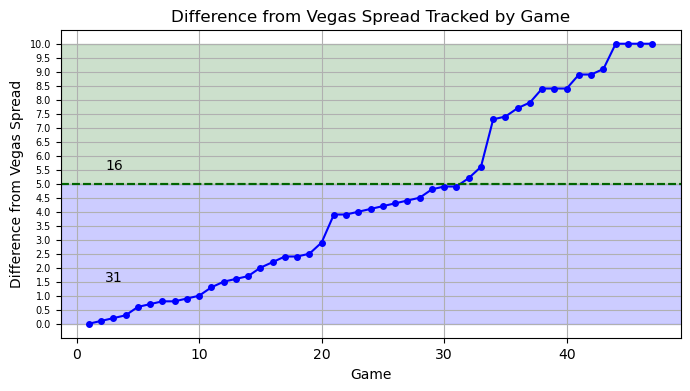

In [72]:
import matplotlib.pyplot as plt
# Comparing Prediction to Vegas Spread

if postseason:
    betting = []
    response = betting_api.get_lines(year=current_year, season_type="postseason")
    betting.extend(response)  # Use extend for list concatenation
else:
    betting = []
    response = betting_api.get_lines(year=current_year, week=current_week)
    betting.extend(response)  # Use extend for list concatenation


betting_info_list = []

for bet in betting:
    data = bet.to_dict() if hasattr(bet, 'to_dict') else vars(bet)
    lines = pd.DataFrame(data['lines'])

    if not lines.empty:
        # Try to get consensus lines first
        consensus_lines = lines[lines['provider'] == 'consensus']
        
        if consensus_lines.empty:
            consensus_lines = lines[lines['provider'] == 'DraftKings']
        if consensus_lines.empty:
            consensus_lines = lines[lines['provider'] == 'ESPN Bet']
        if consensus_lines.empty:
            consensus_lines = lines[lines['provider'] == 'Bovada']
        


        if not consensus_lines.empty:
            consensus_lines = consensus_lines[['spread', 'formattedSpread','spreadOpen', 'overUnder']]
            combined_data = {
                'id': data['id'],
                'season_type': data['seasonType']
            }
            df = pd.DataFrame([combined_data])
            full_df = pd.concat([df.reset_index(drop=True), consensus_lines.reset_index(drop=True)], axis=1)
            betting_info_list.append(full_df)

betting_info = pd.concat(betting_info_list, ignore_index=True)
week_games = pd.merge(week_games, betting_info, on='id', how='left')
week_games['spread'] = week_games['spread'] * -1
week_games['spreadOpen'] = week_games['spreadOpen'] * -1

# if current_week == 7:
#     week_games.loc[week_games['home_team'] == 'Western Kentucky', 'pr_spread'] += 0.5

# Capping predictions that are more than 15 points away from the Vegas Spread
threshold = 10
capped_preds = np.clip(week_games['pr_spread'], week_games['spread'] - threshold, week_games['spread'] + threshold)
week_games['pr_spread'] = capped_preds

# Function to find out if PR predicts the favorite or underdog
def calculate_pr_prediction(row, pr_spread_col, vegas_spread_col):
    if (row[vegas_spread_col] < 0) and (row[pr_spread_col] < 0) and (row[pr_spread_col] < row[vegas_spread_col]):
        return 'Favorite'
    elif (row[vegas_spread_col] > 0) and (row[pr_spread_col] > 0) and (row[pr_spread_col] > row[vegas_spread_col]):
        return 'Favorite'
    elif (row[vegas_spread_col] == row[pr_spread_col]):
        return 'Exact'
    else:
        return 'Underdog'

week_games['formatted_open'] = week_games.apply(
    lambda row: f"{row['away_team']} {row['spreadOpen']}" if row['spreadOpen'] < 0 
                else f"{row['home_team']} -{row['spreadOpen']}", axis=1
)

# Use the above function
def add_pr_prediction(week_games, pr_spread_col, vegas_spread_col, prediction_col_name='pr_prediction'):
    week_games[prediction_col_name] = week_games.apply(calculate_pr_prediction, axis=1, args=(pr_spread_col,vegas_spread_col,))
    return week_games
week_games = add_pr_prediction(week_games, 'pr_spread', 'spread', 'pr_prediction')
week_games = add_pr_prediction(week_games, 'pr_spread', 'spreadOpen', 'opening_spread_prediction')

# Formatting the KRATOS Power Rating Spread
week_games['PEAR'] = week_games.apply(
    lambda row: f"{row['away_team']} {-abs(row['pr_spread'])}" if ((row['pr_spread'] <= 0)) 
    else f"{row['home_team']} {-abs(row['pr_spread'])}", axis=1)

week_games['difference'] = abs(week_games['pr_spread'] - week_games['spread'])
week_games['opening_difference'] = abs(week_games['pr_spread'] - week_games['spreadOpen'])
week_games = week_games.sort_values(by=["difference", "home_win_prob"], ascending=False).reset_index(drop=True)
week_games = week_games.drop_duplicates(subset='home_team')
prediction_information = week_games[['home_team', 'away_team', 'game_quality', 'home_win_prob','difference', 'formatted_open', 'formattedSpread', 'PEAR', 'pr_prediction', 'home_pr', 'away_pr']]
prediction_information = prediction_information.dropna()
print("Total Difference from Vegas Spread:", round(sum(prediction_information['difference']),1))
print("Average Difference from Vegas Spread:", round(sum(prediction_information['difference'])/len(prediction_information), 2))

# Graphing the spread
spreads_sorted = prediction_information['difference'].sort_values()
count_below_3 = len(spreads_sorted[spreads_sorted <= 5])
count_above_7 = len(spreads_sorted[spreads_sorted > 5])
x_values = range(1, len(spreads_sorted) + 1)
y_min = spreads_sorted.min()
y_max = spreads_sorted.max()
y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + 0.5, 0.5)
plt.figure(figsize=(8, 4))  # Increase figure size for better visibility
plt.plot(x_values, spreads_sorted, marker='o', linestyle='-', color='b', markersize=4)
plt.axhspan(ymin=y_min, ymax=5, color='blue', alpha=0.2)  # Green shade for y < 3
plt.axhline(y=5, linestyle = '--', color = 'darkgreen')
if y_max > 4.5:
    plt.axhspan(ymin=5, ymax=y_max, color='darkgreen', alpha=0.2)     # Red shade for y > 7
    plt.axhline(y=5, linestyle = '--', color = 'darkgreen')
    plt.text(len(x_values) * 0.05, 5.5, f'{count_above_7}', color='black', fontsize=10)
# Display the count of games in each range on the plot
plt.text(len(x_values) * 0.05, 1.5, f'{count_below_3}', color='black', fontsize=10)
plt.title('Difference from Vegas Spread Tracked by Game')
plt.xlabel('Game')
plt.ylabel('Difference from Vegas Spread')
plt.grid(True)
plt.yticks(y_ticks)
plt.tick_params(axis='y', labelsize=7)
plt.show()

### metrics

In [55]:
import math
from sklearn.metrics import explained_variance_score
week_games['actual_margin'] = week_games['home_points'] - week_games['away_points']
def calculate_margin_team(row):
    if row['actual_margin'] > 0:
        return f"{row['home_team']} -{row['actual_margin']}"  # If actual_margin is positive
    elif row['actual_margin'] < 0:
        return f"{row['away_team']} {row['actual_margin']}"  # If actual_margin is negative
    else:
        return ''
week_games['actual_spread'] = week_games.apply(calculate_margin_team, axis=1)
week_games = add_pr_prediction(week_games, 'actual_margin', 'spread', 'CLOSE ATS RESULT')
week_games = add_pr_prediction(week_games, 'actual_margin', 'spreadOpen', 'OPEN ATS RESULT')

def check_prediction_correct(row, prediction_col, ats_tester):
    if row['actual_spread'] == '':
        return ''
    if row[prediction_col] == row[ats_tester]:
        return 1
    elif 'Exact' in (row[prediction_col], row[ats_tester]):
        return 1
    else:
        return 0
# Apply the check prediction function and store the result in a new column
week_games['PEAR ATS CLOSE'] = week_games.apply(lambda row: check_prediction_correct(row, 'pr_prediction', 'CLOSE ATS RESULT'), axis=1)
week_games['PEAR ATS OPEN'] = week_games.apply(lambda row: check_prediction_correct(row, 'opening_spread_prediction', 'OPEN ATS RESULT'), axis=1)

def check_straight_up(row, prediction_col):
    if row['actual_spread'] == '':
        return ''
    if (row['actual_margin'] < 0) and (row[prediction_col] < 0):
        return 1
    elif (row['actual_margin'] > 0) and (row[prediction_col] > 0):
        return 1
    else:
        return 0
week_games['PEAR SU'] = week_games.apply(lambda row: check_straight_up(row, 'pr_spread'), axis = 1)
game_completion_info = week_games[['home_team', 'away_team', 'difference', 'formatted_open', 'formattedSpread', 'PEAR', 'spread', 'actual_margin', 'actual_spread', 'PEAR ATS OPEN', 'PEAR ATS CLOSE', 'PEAR SU']]
completed = game_completion_info[game_completion_info["PEAR ATS CLOSE"] != '']
no_pushes = completed[completed['difference'] != 0]
no_pushes = no_pushes[no_pushes['spread'] != no_pushes['actual_margin']]

X = 10
if len(completed) > 0:
    win_difference = completed.loc[completed["PEAR ATS CLOSE"] == 1, "difference"].sum()
    total_difference = completed['difference'].sum()
    MAE = round(abs(week_games['actual_margin'] - week_games['pr_spread']).mean(),2)
    DAE = round(abs(week_games['actual_margin'] - week_games['pr_spread']).median(),2)
    RMSE = round(math.sqrt(((week_games['actual_margin'] - week_games['pr_spread']) ** 2).mean()),2)
    count = (abs(week_games['actual_margin'] - week_games['pr_spread']) < X).sum()
    MAE_plus = 0.5 * MAE + 0.25 * DAE + 0.25 * RMSE
    wATS = round(win_difference/total_difference * 100, 2)
    print(f"SU: {round(100*sum(completed['PEAR SU'] / len(completed)),2)}%  -  {sum(completed['PEAR SU'])}/{len(completed)}")
    print(f"ATS: {round(100 * sum(no_pushes['PEAR ATS CLOSE']) / len(no_pushes),2)}%  -  {sum(no_pushes['PEAR ATS CLOSE'])}/{len(no_pushes)}")
    print(f'wATS: {wATS}%')
    print(f"MAE: {MAE}")
    print(f"DAE: {DAE}")
    print(f"RMSE: {RMSE}")
    print(f"MAE+: {round(100-MAE_plus,2)}%")
    print(f"AE < {X}: {round(count/len(completed)*100,2)}%")

In [ ]:
game_completion_info.to_excel(f'./PEAR/PEAR Football/y{current_year}/Spreads/spreads_tracker_week{current_week}.xlsx')

# Pre-Season Ratings

## Prep Work

In [160]:
import pandas as pd
import cfbd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

configuration = cfbd.Configuration(
    access_token = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
)
# configuration = cfbd.Configuration()
# configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
# configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)

production_list = []

for year in range(2015, 2026):
    try:
        response = players_api.get_returning_production(year=year)
        # Filter out entries that have None for required fields
        cleaned_response = [
            r for r in response
            if r.percent_ppa is not None and r.usage is not None
        ]
        production_list.extend(cleaned_response)
    except Exception as e:
        print(f"Error for year {year}: {e}")

# Now safely construct the DataFrame
production_dict = [dict(
    season=r.season,
    team=r.team,
    returning_ppa=r.percent_ppa,
    returning_usage=r.usage
) for r in production_list]

returning_production = pd.DataFrame(production_dict)

talent_list = []
for year in range(2015, 2025):
    response = teams_api.get_talent(year=year)
    talent_list = [*talent_list, *response]

talent_dict = [dict(
    team=t.team,
    season=t.year,
    talent=t.talent
) for t in talent_list]
talent = pd.DataFrame(talent_dict)

recruiting_list = []
for year in range(2012, 2026):
    response = recruiting_api.get_team_recruiting_rankings(year=year)
    recruiting_list = [*recruiting_list, *response]

recruiting_dict = [
    dict(
        team = t.team,
        season = t.year,
        recruiting_points = t.points
    ) for t in recruiting_list]
recruiting = pd.DataFrame(recruiting_dict)

Error for year 2017: 1 validation error for ReturningProduction
percentPassingPPA
  none is not an allowed value (type=type_error.none.not_allowed)


In [161]:
import pandas as pd
df = recruiting.copy()
df_lag1 = df.copy()
df_lag1['season'] += 1
df_lag1.rename(columns={'recruiting_points': 'points_lag1'}, inplace=True)
df_lag2 = df.copy()
df_lag2['season'] += 2
df_lag2.rename(columns={'recruiting_points': 'points_lag2'}, inplace=True)
df_lag3 = df.copy()
df_lag3['season'] += 3
df_lag3.rename(columns={'recruiting_points': 'points_lag3'}, inplace=True)
merged = df.merge(df_lag1, on=['team', 'season'], how='left')
merged = merged.merge(df_lag2, on=['team', 'season'], how='left')
merged = merged.merge(df_lag3, on=['team', 'season'], how='left')
merged[['points_lag1', 'points_lag2', 'points_lag3']] = merged[['points_lag1', 'points_lag2', 'points_lag3']].fillna(0)
merged = merged[merged['season'] >= 2015]
recruiting_2025 = merged[merged['season'] == 2025]
recruiting_and_talent = talent.merge(merged, on=['team', 'season'], how='left')
recruiting_and_talent = recruiting_and_talent[recruiting_and_talent['talent'] != 0]

In [162]:
from sklearn.model_selection import train_test_split

# Define features and target
X = recruiting_and_talent[['recruiting_points', 'points_lag1', 'points_lag2', 'points_lag3']]
y = recruiting_and_talent['talent']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define your base model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define your grid of parameters to search
param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up grid search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
X_2025 = recruiting_2025[['recruiting_points', 'points_lag1', 'points_lag2', 'points_lag3']]
recruiting_2025['predicted_talent'] = best_model.predict(X_2025)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [170]:
import os
import pandas as pd

# Define the root folder path
root_folder = "./PEAR/PEAR Football"

# Initialize a list to store data from the selected files
combined_data = []

# Loop through year folders like 'y2024', 'y2025', etc.
for year_folder in os.listdir(root_folder):
    if year_folder != 'y2013' and year_folder.startswith("y"):
        data_folder = os.path.join(root_folder, year_folder, "Data")
        
        if os.path.isdir(data_folder):
            max_week = -1
            max_week_file = None
            
            # Find the file with the highest week value
            for file in os.listdir(data_folder):
                if file.startswith("team_data_week") and file.endswith(".csv"):
                    try:
                        week_number = int(file.split("team_data_week")[1].split(".csv")[0])
                        if week_number > max_week:
                            max_week = week_number
                            max_week_file = os.path.join(data_folder, file)
                    except ValueError:
                        print(f"Skipping file with invalid week number: {file}")
            
            # Read the file with the highest week value
            if max_week_file:
                try:
                    data = pd.read_csv(max_week_file)
                    combined_data.append(data)
                except Exception as e:
                    print(f"Failed to read file {max_week_file}: {e}")

# Combine all selected data into a single DataFrame
combined_dataset = pd.concat(combined_data, ignore_index=True)
combined_dataset = combined_dataset.sort_values('power_rating', ascending=False).reset_index(drop=True).drop(columns=['Unnamed: 0'], errors='ignore')

# Perform z-score normalization grouped by "season"
combined_dataset['norm_power_rank'] = combined_dataset.groupby('season')['power_rating'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Sort and re-normalize to a 55-point range centered at 0
combined_dataset = combined_dataset.sort_values('norm_power_rank', ascending=False).reset_index(drop=True)
combined_dataset['norm_pr'] = combined_dataset['norm_power_rank'] - combined_dataset['norm_power_rank'].mean()
current_range = combined_dataset['norm_pr'].max() - combined_dataset['norm_pr'].min()
desired_range = 55
scaling_factor = desired_range / current_range
combined_dataset['norm_pr'] = round(combined_dataset['norm_pr'] * scaling_factor, 2)

year_ratings = combined_dataset[['team', 'power_rating', 'season']]

# Sort for consistent shift
year_ratings_sorted = year_ratings.sort_values(by=["team", "season"])

# Add previous season ratings
year_ratings_sorted["previous_season"] = year_ratings_sorted.groupby("team")["season"].shift(1)
year_ratings_sorted["previous_rating"] = year_ratings_sorted.groupby("team")["power_rating"].shift(1)

# Add rating from two seasons ago
year_ratings_sorted["prev_rating2"] = year_ratings_sorted.groupby("team")["power_rating"].shift(2)

# Drop rows without previous season
df_merged = year_ratings_sorted.dropna(subset=["previous_season"]).copy()

# Rename and select
df_merged = df_merged.rename(columns={"season": "new_season", "power_rating": "new_rating"})
df_merged = df_merged[["team", "previous_rating", "prev_rating2", "previous_season", "new_rating", "new_season"]]

# Merge in other features
df_final = df_merged.merge(
    returning_production, left_on=["team", "new_season"], right_on=["team", "season"], how="left"
).merge(
    talent, left_on=["team", "new_season"], right_on=["team", "season"], how="left"
).merge(
    combined_dataset[["team", "season", "avg_expected_wins"]],
    left_on=["team", "previous_season"],
    right_on=["team", "season"],
    how="left"
)

# Final cleanup and prep
prepped_data = df_final.drop(columns=["season_x", "season_y", "season"])
prepped_data['rank'] = prepped_data.groupby('new_season')['new_rating'].rank(method='min', ascending=False)
prepped_data['returning_ppa'] = prepped_data['returning_ppa'].fillna(prepped_data['returning_ppa'].mean())
prepped_data['returning_usage'] = prepped_data['returning_usage'].fillna(prepped_data['returning_usage'].mean())

mean_talent = prepped_data['talent'].mean()
std_talent = prepped_data['talent'].std()
replacement_value = mean_talent - 0.75 * std_talent
prepped_data['talent'] = prepped_data['talent'].replace(0, replacement_value)

prepped_data['approx_returning_talent'] = prepped_data["talent"] * prepped_data["returning_ppa"]
prepped_data = prepped_data.dropna()

Skipping file with invalid week number: team_data_week17_no_adjustments.csv
Skipping file with invalid week number: team_data_week17_sagarin.csv


## Modeling

In [186]:
import pandas as pd
import numpy as np
from scipy.optimize import differential_evolution
from scipy.stats import zscore, spearmanr
from tqdm import tqdm

# --- Step 1: Z-score normalize relevant columns ---
mean_exp_wins = prepped_data['avg_expected_wins'].mean()
std_exp_wins = prepped_data['avg_expected_wins'].std()
prepped_data['z_sos_adj'] = -(prepped_data['avg_expected_wins'] - mean_exp_wins) / std_exp_wins

features = ['returning_ppa', 'returning_usage', 'previous_rating', 'prev_rating2', 'talent', 'z_sos_adj']
for col in features:
    if col not in prepped_data.columns or col.startswith('z_'):
        continue
    prepped_data[f'z_{col}'] = zscore(prepped_data[col].fillna(prepped_data[col].mean()))

z_features = [f'z_{col}' if not col.startswith('z_') else col for col in features]

# --- Step 2: Optimization setup ---
pbar = tqdm(total=1000, desc="Optimization Progress")

def progress_callback(xk, convergence):
    pbar.update(1)
    if convergence < 1e-6:
        pbar.close()

def objective(weights):
    weights = np.array(weights)
    weights = weights / weights.sum()  # Normalize weights to sum to 1

    # Weighted composite score
    prepped_data['power_score'] = prepped_data[z_features].values @ weights

    # Generate ranks and compare to ground-truth 'rank'
    prepped_data['predicted_rank'] = prepped_data.groupby('new_season')['power_score'].rank(ascending=False, method='average')
    corr = prepped_data[['predicted_rank', 'rank']].corr(method='spearman').iloc[0, 1]

    return -corr  # We want to maximize Spearman correlation

# --- Step 3: Differential evolution ---
bounds = [(0, 1)] * len(z_features)
result = differential_evolution(
    objective,
    bounds,
    strategy='best1bin',
    maxiter=1000,
    popsize=20,
    mutation=(0.3, 1.5),
    recombination=0.5,
    init='sobol',
    seed=42,
    callback=progress_callback
)

optimized_weights = result.x / result.x.sum()  # Final normalized weights

Optimization Progress:   1%|          | 6/1000 [00:10<27:48,  1.68s/it]


In [210]:
returning_2025 = returning_production[returning_production['season'] == 2025][['team', 'returning_ppa', 'returning_usage']]
power_2024 = combined_dataset[combined_dataset['season'] == 2024][['team', 'power_rating', 'avg_expected_wins']].copy()
power_2024.rename(columns={'power_rating': 'prev_rating'}, inplace=True)
power_2023 = combined_dataset[combined_dataset['season'] == 2023][['team', 'power_rating']].copy()
power_2023.rename(columns={'power_rating': 'prev_rating2'}, inplace=True)
power_2025 = returning_2025.merge(power_2024, on='team', how='left')
power_2025 = power_2025.merge(power_2023, on='team', how='left')
power_2025 = power_2025.merge(recruiting_2025[['team', 'predicted_talent']], on='team', how='left')
input_cols = ['returning_ppa', 'returning_usage', 'prev_rating', 'prev_rating2', 'predicted_talent', 'avg_expected_wins']
means = prepped_data[['returning_ppa', 'returning_usage', 'previous_rating', 'prev_rating2', 'talent', 'avg_expected_wins']].mean()
stds = prepped_data[['returning_ppa', 'returning_usage', 'previous_rating', 'prev_rating2', 'talent', 'avg_expected_wins']].std()
rename_map = {
    'prev_rating': 'previous_rating',
    'predicted_talent': 'talent'
}
z_power_2025 = (power_2025[input_cols].rename(columns=rename_map) - means) / stds
power_2025['power_rating'] = (z_power_2025.values @ optimized_weights) * 15
power_2025['power_rating'] = round(power_2025['power_rating'],1)

In [ ]:
power_2025.loc[power_2025['team'] == 'Boise State', 'power_rating'] = 5.6
power_2025 = power_2025[['team', 'power_rating']].sort_values('power_rating', ascending=False).reset_index(drop=True)
power_2025['week'] = 1
power_2025['season'] = 2025

In [212]:
power_2025[0:30]

,team,power_rating,week,season
0,Ohio State,22.4,0,2025
1,Penn State,21.6,0,2025
2,Alabama,20.7,0,2025
3,Georgia,19.3,0,2025
4,Notre Dame,18.6,0,2025
5,LSU,17.9,0,2025
6,Texas,17.8,0,2025
7,Clemson,16.8,0,2025
8,Oregon,16.8,0,2025
9,Texas A&M,16.7,0,2025


In [ ]:
power_2025.to_csv("./PEAR/PEAR Football/y2025/Ratings/PEAR_week1.csv")

## Pre-Season Metrics?

In [95]:
from scipy.optimize import minimize # type: ignore
from scipy.optimize import differential_evolution # type: ignore
from tqdm import tqdm # type: ignore
import matplotlib.pyplot as plt # type: ignore
import requests # type: ignore
from PIL import Image # type: ignore
from scipy.stats import norm # type: ignore
import requests
from PIL import Image
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor, as_completed # type: ignore
from io import BytesIO # type: ignore
from matplotlib.lines import Line2D # type: ignore
import cfbd # type: ignore
import pandas as pd # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
import matplotlib.pyplot as plt # type: ignore
import requests # type: ignore
from PIL import Image # type: ignore
from io import BytesIO # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as mpimg # type: ignore
import requests # type: ignore
from PIL import Image # type: ignore
from matplotlib.offsetbox import OffsetImage, AnnotationBbox # type: ignore
from matplotlib import gridspec # type: ignore
import os
import math # type: ignore
import matplotlib.patches as patches # type: ignore
from unittest import result
import datetime
import numpy as np # type: ignore
from PIL import ImageGrab # type: ignore
from base64 import b64decode # type: ignore
import PIL # type: ignore
import warnings
import seaborn as sns # type: ignore
from matplotlib.colors import LinearSegmentedColormap # type: ignore
import pytz # type: ignore
from datetime import datetime
import matplotlib.colors as mcolors # type: ignore
import matplotlib.font_manager as fm # type: ignore
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
import numpy as np
import math
checkmark_font = fm.FontProperties(family='DejaVu Sans')
# Suppress all warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
configuration = cfbd.Configuration(
    access_token = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
)
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)

elo_ratings_list = [*ratings_api.get_elo(year=2024)]
elo_ratings_dict = [dict(
    team = e.team,
    elo = e.elo
) for e in elo_ratings_list]
elo_ratings = pd.DataFrame(elo_ratings_dict)

def adjust_home_pr(home_win_prob):
    if home_win_prob is None or (isinstance(home_win_prob, float) and math.isnan(home_win_prob)):
        return 0
    return ((home_win_prob - 50) / 50) * 5

def round_to_nearest_half(x):
    return np.round(x * 2) / 2

def date_sort(game):
    start_date = game['start_date']
    if isinstance(start_date, str):
        start_date = datetime.strptime(start_date, "%Y-%m-%dT%H:%M:%S.000Z")
    return start_date

def PEAR_Win_Prob(home_power_rating, away_power_rating):
    return round((1 / (1 + 10 ** ((away_power_rating - (home_power_rating)) / 20.5))) * 100, 2)

In [96]:
team_data = pd.read_csv(f'./PEAR/PEAR Football/y2025/Ratings/PEAR_week1.csv')

In [98]:
start_week = 1
end_week = 16
games_list = []
for week in range(start_week,end_week):
    response = games_api.get_games(year=2025, week=week,classification = 'fbs')
    games_list = [*games_list, *response]
games = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_elo=g.away_pregame_elo,
            home_points = g.home_points,
            away_points = g.away_points,
            neutral = g.neutral_site
            ) for g in games_list]
games.sort(key=date_sort)
year_long_schedule = pd.DataFrame(games)
year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']], 
                                    left_on='home_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'home_pr'})
year_long_schedule = year_long_schedule.drop(columns=['team'])
year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']], 
                                    left_on='away_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'away_pr'})
year_long_schedule = year_long_schedule.drop(columns=['team'])
missing_rating =round(team_data['power_rating'].mean() - 1.5*team_data['power_rating'].std(),2)
year_long_schedule['home_pr'].fillna(missing_rating, inplace=True)
year_long_schedule['away_pr'].fillna(missing_rating, inplace=True)
year_long_schedule['PEAR_win_prob'] = year_long_schedule.apply(
    lambda row: PEAR_Win_Prob(row['home_pr'], row['away_pr'])/100, axis=1
)
year_long_schedule['home_win_prob'] = round((10**((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) / ((10**((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) + 1)*100,2)

year_long_schedule['pr_spread'] = (4.6 + year_long_schedule['home_pr'] + (year_long_schedule['home_win_prob'].apply(adjust_home_pr)) - year_long_schedule['away_pr']).round(1)
year_long_schedule['pr_spread'] = np.where(year_long_schedule['neutral'], year_long_schedule['pr_spread'] - 4.6, year_long_schedule['pr_spread']).round(1)
year_long_schedule['PEAR'] = year_long_schedule.apply(
    lambda row: f"{row['away_team']} {-abs(row['pr_spread'])}" if ((row['pr_spread'] <= 0)) 
    else f"{row['home_team']} {-abs(row['pr_spread'])}", axis=1)

In [99]:
home_wins = year_long_schedule.groupby('home_team')['PEAR_win_prob'].sum().reset_index()
home_wins.columns = ['team', 'home_win_exp']
away_wins = year_long_schedule.groupby('away_team')['PEAR_win_prob'].apply(lambda x: (1 - x).sum()).reset_index()
away_wins.columns = ['team', 'away_win_exp']
total_wins = pd.merge(home_wins, away_wins, on='team', how='outer').fillna(0)
total_wins['win_total'] = round(total_wins['home_win_exp'] + total_wins['away_win_exp'],1)
result = total_wins[['team', 'win_total']].sort_values('win_total', ascending=False).reset_index(drop=True)

In [104]:
average_elo = elo_ratings['elo'].mean()
average_pr = round(team_data['power_rating'].mean(), 2)
good_team_pr = round(team_data['power_rating'].std() + team_data['power_rating'].mean(),2)
elite_team_pr = round(2*team_data['power_rating'].std() + team_data['power_rating'].mean(),2)
expected_wins_list = []
for team in team_data['team']:
    schedule = year_long_schedule[(year_long_schedule['home_team'] == team) | (year_long_schedule['away_team'] == team)]
    df = average_team_distribution(1000, schedule, elite_team_pr, team)
    expected_wins = df['expected_wins'].values[0]
    expected_wins_list.append(expected_wins)
SOS = pd.DataFrame(zip(team_data['team'], expected_wins_list), columns=['team', 'avg_expected_wins'])
SOS = SOS.sort_values('avg_expected_wins').reset_index(drop = True)
SOS['SOS'] = SOS.index + 1

In [105]:
all_data = team_data.merge(SOS, on='team', how='left')
all_data = all_data.merge(result, on='team', how='left')

In [109]:
all_data.to_csv("./PEAR/PEAR Football/y2025/Data/team_data_week1.csv")

# New Formula Testing

In [ ]:
from scipy.optimize import minimize # type: ignore
from scipy.optimize import differential_evolution # type: ignore
from tqdm import tqdm # type: ignore
import matplotlib.pyplot as plt # type: ignore
import requests # type: ignore
from PIL import Image # type: ignore
from io import BytesIO # type: ignore
from matplotlib.lines import Line2D # type: ignore
import cfbd # type: ignore
import pandas as pd # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
import matplotlib.pyplot as plt # type: ignore
import requests # type: ignore
from PIL import Image # type: ignore
from io import BytesIO # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as mpimg # type: ignore
import requests # type: ignore
from PIL import Image # type: ignore
from matplotlib.offsetbox import OffsetImage, AnnotationBbox # type: ignore
from matplotlib import gridspec # type: ignore
import os
import math # type: ignore
import matplotlib.patches as patches # type: ignore
from unittest import result
import datetime
import numpy as np # type: ignore
from PIL import ImageGrab # type: ignore
from base64 import b64decode # type: ignore
import PIL # type: ignore
import warnings
import seaborn as sns # type: ignore
from matplotlib.colors import LinearSegmentedColormap # type: ignore
import pytz # type: ignore
import matplotlib.colors as mcolors # type: ignore
import matplotlib.font_manager as fm # type: ignore
checkmark_font = fm.FontProperties(family='DejaVu Sans')
# Suppress all warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

configuration = cfbd.Configuration(
    access_token = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
)
# configuration = cfbd.Configuration()
# configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
# configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)

current_time = datetime.datetime.now(pytz.UTC)
if current_time.month < 6:
    calendar_year = current_time.year - 1
else:
    calendar_year = current_time.year
week_start_list = [*games_api.get_calendar(year = calendar_year)]
calendar_dict = [dict(
    first_game_start = c.first_game_start,
    last_game_start = c.last_game_start,
    season = c.season,
    season_type = c.season_type,
    week = c.week
) for c in week_start_list]
calendar = pd.DataFrame(calendar_dict)
calendar['first_game_start'] = pd.to_datetime(calendar['first_game_start'])
calendar['last_game_start'] = pd.to_datetime(calendar['last_game_start'])
current_year = int(calendar.loc[0, 'season'])

first_game_start = calendar['first_game_start'].iloc[0]
last_game_start = calendar['last_game_start'].iloc[-1]
current_week = None
if current_time < first_game_start:
    current_week = 1
    postseason = False
elif current_time > last_game_start:
    current_week = calendar.iloc[-2, -1] + 1
    postseason = True
else:
    condition_1 = (calendar['first_game_start'] <= current_time) & (calendar['last_game_start'] >= current_time)
    condition_2 = (calendar['last_game_start'].shift(1) < current_time) & (calendar['first_game_start'] > current_time)

    # Combine conditions
    result = calendar[condition_1 | condition_2].reset_index(drop=True)
    if result['season_type'][0] == 'regular':
        current_week = result['week'][0]
        postseason = False
    else:
        current_week = calendar.iloc[-2, -1] + 1
        postseason = True

current_year = int(current_year)
current_week = int(current_week)
print(f"Current Week: {current_week}, Current Year: {current_year}")
print("Double Check The Current Week To Make Sure It Is Correct")

def date_sort(game):
    return game['start_date']

def PEAR_Win_Prob(home_power_rating, away_power_rating):
    return round((1 / (1 + 10 ** ((away_power_rating - (home_power_rating)) / 20.5))) * 100, 2)

def average_team_distribution(num_simulations, schedules, average, team_name):

    def simulate_game_average(win_prob):
        random_outcome = np.random.random() * 100  # Generates a number between 0 and 100
        if random_outcome < win_prob:
            return "W"  # Home team wins, Away team loses
        else:
            return "L"  # Away team wins, Home team loses
        
    def simulate_season_average(schedules, team_name, average):
        wins = 0
        losses = 0
        for _, game in schedules.iterrows():
            if game['home_team'] == team_name:
                opponent_team = game['away_team']
                opponent_pr = game['away_pr']
                win_prob = PEAR_Win_Prob(average, opponent_pr)

                # opponent_elo = game['away_elo']
                # win_prob = round((10**((average-opponent_elo) / 400)) / ((10**((average-opponent_elo) / 400)) + 1)*100, 2)
            else:
                opponent_team = game['home_team']
                opponent_pr = game['home_pr']
                win_prob = 100 - PEAR_Win_Prob(opponent_pr, average)

                # opponent_elo = game['home_elo']
                # win_prob = 100 - round((10**((opponent_elo-average) / 400)) / ((10**((opponent_elo-average) / 400)) + 1)*100, 2)
            
            outcome = simulate_game_average(win_prob)
            if outcome == "W":
                wins += 1
            else:
                losses += 1

        return wins, losses
        
    def monte_carlo_simulation_average(num_simulations, schedules, average, team_name):
        """Runs a Monte Carlo simulation for an average team over multiple seasons."""
        win_results = []
        loss_results = []

        for _ in range(num_simulations):
            wins, losses = simulate_season_average(schedules, team_name, average)
            win_results.append(wins)
            loss_results.append(losses)
        
        return win_results, loss_results

    import statistics
    from collections import Counter
    def analyze_simulation_average(win_results, loss_results, schedules):
        games_played = len(schedules)
        if games_played == 11:
            win_results = [x + .948 for x in win_results]
        elif games_played == 10:
            win_results = [x + (2 * .948) for x in win_results]
    
        avg_wins = statistics.mean(win_results)
        avg_loss = statistics.mean(loss_results)
        most_common_win = statistics.mode(win_results)
        most_common_loss = statistics.mode(loss_results)


        win_counts = Counter(win_results)    
        total_simulations = len(win_results)
        win_percentages = {f"win_{wins}": (win_counts[wins] / total_simulations) for wins in range(13)}
        win_thresholds = pd.DataFrame([win_percentages])
        
        # win_thresholds = {}
        # for wins in range(13):  # 0 to 12 wins
        #     win_thresholds[f'win_{wins}'] = win_df.apply(lambda x: (x == wins).sum() / len(x), axis=0)

        win_thresholds['WIN6%'] = win_thresholds.loc[:, 'win_6':'win_12'].sum(axis=1)
        win_thresholds['expected_wins'] = avg_wins
        win_thresholds['expected_losses'] = avg_loss
        win_thresholds['projected_wins'] = most_common_win
        win_thresholds['projected_losses'] = most_common_loss

        return win_thresholds
    
    avg_win, avg_loss = monte_carlo_simulation_average(num_simulations, schedules, average, team_name)
    win_thresholds = analyze_simulation_average(avg_win, avg_loss,schedules)
    return win_thresholds

if postseason:
    elo_ratings_list = [*ratings_api.get_elo(year=current_year)]
else:
    elo_ratings_list = [*ratings_api.get_elo(year=current_year, week=current_week)]
elo_ratings_dict = [dict(
    team = e.team,
    elo = e.elo
) for e in elo_ratings_list]
elo_ratings = pd.DataFrame(elo_ratings_dict)

# team records
records_list = []
response = games_api.get_records(year=current_year)
records_list = [*records_list, *response]
records_dict = [dict(
    team = r.team,
    games_played = r.total.games,
    wins = r.total.wins,
    losses = r.total.losses,
    conference_games = r.conference_games.games,
    conference_wins = r.conference_games.wins,
    conference_losses = r.conference_games.losses
) for r in records_list]
records = pd.DataFrame(records_dict)

# fpi ranks
team_fpi_list = []
response = ratings_api.get_fpi(year = current_year)
team_fpi_list = [*team_fpi_list, *response]
team_fpi_dict = [dict(
    team = f.team,
    fpi = f.fpi,
    fpi_rank = f.resume_ranks.fpi,
    fpi_sor = f.resume_ranks.strength_of_record,
    fpi_sos = f.resume_ranks.strength_of_schedule,
    def_eff = f.efficiencies.defense,
    off_eff = f.efficiencies.offense,
    special_eff = f.efficiencies.special_teams
) for f in team_fpi_list]
team_fpi = pd.DataFrame(team_fpi_dict)

# sp ranks
team_sp_list = []
response = ratings_api.get_sp(year=current_year)
team_sp_list = [*team_sp_list, *response]
team_sp_dict = [dict(
    team = t.team,
    ranking = t.ranking,
    sp_rating = t.rating
) for t in team_sp_list]
team_sp = pd.DataFrame(team_sp_dict).dropna()

# logo info
logos_info_list = []
response = teams_api.get_teams()
logos_info_list = [*logos_info_list, *response]
logos_info_dict = [dict(
    team = l.school,
    color = l.color,
    alt_color = l.alternate_color,
    logo = l.logos
) for l in logos_info_list]
logos_info = pd.DataFrame(logos_info_dict)
logos_info = logos_info.dropna(subset=['logo', 'color'])

# advanced metrics
advanced_metrics_response = []
response = advanced_instance.get_advanced_season_stats(year = current_year)
advanced_metrics_response = [*advanced_metrics_response, *response]
advanced_metrics = pd.DataFrame()
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)
for i in range(len(advanced_metrics_response)):
    data = advanced_metrics_response[i].to_dict() if hasattr(advanced_metrics_response[i], 'to_dict') else vars(advanced_metrics_response[i])

    offense_stats = flatten_dict(data['offense'], parent_key='Offense')
    defense_stats = flatten_dict(data['defense'], parent_key='Defense')
    combined_data = {
        'team':data['team'],
        **offense_stats,
        **defense_stats
    }
    df = pd.DataFrame([combined_data])
    advanced_metrics = pd.concat([advanced_metrics, df], ignore_index=True)
columns_to_keep = ['team', 'Offense_explosiveness', 'Defense_explosiveness', 'Offense_ppa', 'Defense_ppa', 'Defense_havoc_total',
                   'Offense_successRate','Defense_successRate','Offense_powerSuccess','Defense_powerSuccess',
                   'Offense_stuffRate','Defense_stuffRate','Offense_pointsPerOpportunity','Defense_pointsPerOpportunity',
                   'Offense_fieldPosition_averagePredictedPoints','Defense_fieldPosition_averagePredictedPoints',
                   'Offense_fieldPosition_averageStart','Defense_fieldPosition_averageStart']
metrics = advanced_metrics[columns_to_keep]

# conference sp
conference_sp = []
response = ratings_api.get_conference_sp(year=current_year)
conference_sp = [*conference_sp, *response]

sp_conf = [dict(
    conference=c.conference,
    season=c.year,
    sp_conf_rating=c.rating
) for c in conference_sp]
conference_sp_rating = pd.DataFrame(sp_conf)

# team stats
team_stats_list = []
response = advanced_instance.get_team_stats(year=current_year)
team_stats_list = [*team_stats_list, *response]
team_stats_dict = [dict(
    team = s.team,
    stat_name = s.stat_name,
    stat_value = s.stat_value.actual_instance
) for s in team_stats_list]
team_stats = pd.DataFrame(team_stats_dict)
team_stats = team_stats.pivot(index='team', columns='stat_name', values='stat_value').reset_index().fillna(0)
team_stats['total_turnovers'] = team_stats['fumblesRecovered'] + team_stats['passesIntercepted'] - team_stats['turnovers']
team_stats['thirdDownConversionRate'] = round(team_stats['thirdDownConversions'] / team_stats['thirdDowns'],4)
team_stats['fourthDownConversionRate'] = round(team_stats['fourthDownConversions'] / team_stats['fourthDowns'], 4)
team_stats['possessionTimeMinutes'] = round(team_stats['possessionTime'] / 60,2)

# team talent
talent_list = []
for year in range(current_year-3, current_year+1):
    response = teams_api.get_talent(year=year)
    talent_list = [*talent_list, *response]
talent_dict = [dict(
    team=t.team,
    season=t.year,
    talent=t.talent
) for t in talent_list]
talent = pd.DataFrame(talent_dict)

# team info
team_info_list = [*teams_api.get_fbs_teams()]
team_dict = [dict(
    team = t.school,
    conference = t.conference
) for t in team_info_list]
team_info = pd.DataFrame(team_dict)

# team recruiting
recruiting_info_list = []
for year in range(current_year-3, current_year+1):
    response = recruiting_api.get_team_recruiting_rankings(year=year)
    recruiting_info_list = [*recruiting_info_list, *response]
recruiting_info_dict = [dict(
    team = r.team,
    year = r.year,
    points = r.points
) for r in recruiting_info_list]
recruiting = pd.DataFrame(recruiting_info_dict)

print("Data Load Done")

Current Week: 14, Current Year: 2024
Double Check The Current Week To Make Sure It Is Correct
Data Load Done


In [101]:
start_week = 1
end_week = current_week - 1
games_list = []
for week in range(start_week,end_week):
    response = games_api.get_games(year=current_year, week=week,classification = 'fbs')
    games_list = [*games_list, *response]
games = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_elo=g.away_pregame_elo,
            home_points = g.home_points,
            away_points = g.away_points,
            neutral = g.neutral_site
            ) for g in games_list]
games.sort(key=date_sort)
year_long_schedule = pd.DataFrame(games)

In [102]:
# Step 1: Create a dictionary for quick PPA lookup
team_ppa = team_data.set_index('team')[['Offense_ppa', 'Defense_ppa']]
adjusted_ppa_list = []
for _, row in year_long_schedule.iterrows():
    home = row['home_team']
    away = row['away_team']
    if home not in team_ppa.index or away not in team_ppa.index:
        continue
    adjusted_ppa_list.append({
        'team': home,
        'opp_offense_ppa': team_ppa.loc[away, 'Offense_ppa'],
        'opp_defense_ppa': team_ppa.loc[away, 'Defense_ppa']
    })
    adjusted_ppa_list.append({
        'team': away,
        'opp_offense_ppa': team_ppa.loc[home, 'Offense_ppa'],
        'opp_defense_ppa': team_ppa.loc[home, 'Defense_ppa']
    })
adjusted_df = pd.DataFrame(adjusted_ppa_list)
opp_ppa_summary = adjusted_df.groupby('team').agg(
    avg_opp_offense_ppa = ('opp_offense_ppa', 'mean'),
    avg_opp_defense_ppa = ('opp_defense_ppa', 'mean')
).reset_index()

In [103]:
# entire talent profile for the team over the last three years
last_three_rows = talent.groupby('team').tail(3)
avg_talent_per_team = last_three_rows.groupby('team')['talent'].mean().reset_index()
avg_talent_per_team.columns = ['team', 'avg_talent']

# Recruiting points over the last 4 years
last_three = recruiting.groupby('team').tail(3)
recruiting_per_team = last_three.groupby('team')['points'].sum().reset_index()
recruiting_per_team.columns = ['team', 'avg_points']
recruiting_per_team['avg_points'] = recruiting_per_team['avg_points'] + 150

intermediate_1 = pd.merge(team_info, avg_talent_per_team, how='left', on='team')
intermediate_2 = pd.merge(intermediate_1, conference_sp_rating, how='left', on='conference')
intermediate_3 = pd.merge(intermediate_2, team_stats, how='left', on='team')
intermediate_4 = pd.merge(intermediate_3, logos_info, how='left', on='team')
intermediate_6 = pd.merge(intermediate_4, team_fpi, how='left', on='team')
intermediate_7 = pd.merge(intermediate_6, records, how='left', on='team')
team_data = pd.merge(intermediate_7, metrics, how='left', on='team')
team_data = pd.merge(team_data, opp_ppa_summary, on='team', how='left')
team_data['adj_offense_ppa'] = (
    team_data['Offense_ppa'] - team_data['avg_opp_defense_ppa']
)

team_data['adj_defense_ppa'] = (
    team_data['Defense_ppa'] - team_data['avg_opp_offense_ppa']
)

# For military schools and new FBS schools, use recruiting points instead of team talent
# New FBS Schools - you get on here for 3 years
target_teams = ['Air Force', 'Army', 'Navy', 'Kennesaw State', 'Jacksonville State', 'Sam Houston']
mask = team_data['team'].isin(target_teams)
team_data.loc[mask, 'avg_talent'] = team_data.loc[mask, 'team'].map(
    recruiting_per_team.set_index('team')['avg_points']
)
team_data = team_data.drop_duplicates(subset=["team"]).reset_index(drop=True)

print("Data Formatting Done")
print("Starting Optimization")

Data Formatting Done
Starting Optimization


In [104]:
from scipy.stats import zscore, rankdata, spearmanr
from scipy.optimize import differential_evolution
import numpy as np
import pandas as pd

# Clean dataset
team_data = team_data[~team_data['team'].isin(['Missouri State', 'Delaware'])]

# Define raw metrics
off_ppa = team_data['adj_offense_ppa']
def_ppa = -team_data['adj_defense_ppa']
turnover_margin = (team_data['turnovers'] - team_data['turnoversOpponent']) / team_data['games_played']
off_ppo = team_data['Offense_pointsPerOpportunity']
def_ppo = -team_data['Defense_pointsPerOpportunity']
talent = team_data['avg_talent']

# Assemble metric dataframe
metrics = pd.DataFrame({
    'off_ppa': off_ppa,
    'def_ppa': def_ppa,
    'off_ppo': off_ppo,
    'def_ppo': def_ppo,
    'talent': talent
})

# Z-score the inputs
z_metrics = metrics.apply(lambda col: zscore(col, nan_policy='omit')).fillna(0)

# Target: FPI rankings (lower rank = better team)
fpi_ranks = rankdata(-team_data['fpi'].values, method='ordinal')  # negative because higher FPI is better

fixed_scale = 12.5
lambda_reg = 0.01  # Try 0.05, 0.1, 0.2 etc.

def objective(weights):
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    model_output = z_metrics.values @ weights * fixed_scale
    model_ranks = rankdata(-model_output, method='ordinal')

    rank_diff = np.abs(model_ranks - fpi_ranks)
    l1_penalty = lambda_reg * np.sum(np.abs(weights))
    
    return rank_diff.mean() + l1_penalty

# Optimize weights (no scale)
bounds = [(0, 1)] * 5
result = differential_evolution(objective, bounds, strategy='best1bin', maxiter=1000, seed=42)

# Get best weights
opt_weights = result.x / sum(result.x)

# Apply final rating
team_data['power_rating'] = (z_metrics @ opt_weights) * fixed_scale

# Show results
print("Best weights:", dict(zip(z_metrics.columns, opt_weights)))
print("Fixed scale factor:", fixed_scale)

Best weights: {'off_ppa': 0.16175462335868346, 'def_ppa': 0.2270414342178214, 'off_ppo': 0.16626911373019446, 'def_ppo': 0.10686126967509557, 'talent': 0.33807355901820507}
Fixed scale factor: 12.5


In [105]:
team_data[['team', 'power_rating']].sort_values('power_rating', ascending=False)

,team,power_rating
81,Ohio State,27.7369
2,Alabama,22.9769
79,Notre Dame,20.5961
34,Georgia,20.3117
88,Penn State,19.1030
...,...,...
10,Ball State,-16.3759
74,New Mexico State,-17.4205
99,Southern Miss,-18.2057
48,Kennesaw State,-18.3366
